In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 30
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_glcm_Contrast_glcm_Correlation_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortR

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 558)
(657450, 8)
validation
(74368, 558)
(74368, 8)
test
(91684, 558)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 558)]             0         


 dense (Dense)               (None, 1024)              572416    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1262472 (4.82 MB)


Trainable params: 1262472 (4.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:46 - loss: 2.3429 - STD: 0.0916 - MAE: 0.2242

 4/66 [>.............................] - ETA: 1s - loss: 1.7618 - STD: 0.1169 - MAE: 0.1873  

 6/66 [=>............................] - ETA: 1s - loss: 1.6321 - STD: 0.1532 - MAE: 0.1691

 8/66 [==>...........................] - ETA: 1s - loss: 1.5656 - STD: 0.1745 - MAE: 0.1589

10/66 [===>..........................] - ETA: 1s - loss: 1.5183 - STD: 0.1844 - MAE: 0.1536

12/66 [====>.........................] - ETA: 1s - loss: 1.4875 - STD: 0.1869 - MAE: 0.1518

14/66 [=====>........................] - ETA: 1s - loss: 1.4660 - STD: 0.1858 - MAE: 0.1516

16/66 [======>.......................] - ETA: 1s - loss: 1.4513 - STD: 0.1843 - MAE: 0.1518

18/66 [=======>......................] - ETA: 1s - loss: 1.4387 - STD: 0.1839 - MAE: 0.1516

20/66 [========>.....................] - ETA: 1s - loss: 1.4282 - STD: 0.1849 - MAE: 0.1509

22/66 [=========>....................] - ETA: 1s - loss: 1.4191 - STD: 0.1868 - MAE: 0.1499

24/66 [=========>....................] - ETA: 1s - loss: 1.4101 - STD: 0.1890 - MAE: 0.1487

26/66 [==========>...................] - ETA: 1s - loss: 1.4038 - STD: 0.1909 - MAE: 0.1478

28/66 [===========>..................] - ETA: 1s - loss: 1.3976 - STD: 0.1921 - MAE: 0.1472

30/66 [============>.................] - ETA: 1s - loss: 1.3926 - STD: 0.1926 - MAE: 0.1469

32/66 [=============>................] - ETA: 1s - loss: 1.3884 - STD: 0.1924 - MAE: 0.1469

34/66 [==============>...............] - ETA: 1s - loss: 1.3847 - STD: 0.1918 - MAE: 0.1470

36/66 [===============>..............] - ETA: 1s - loss: 1.3804 - STD: 0.1912 - MAE: 0.1471

38/66 [================>.............] - ETA: 1s - loss: 1.3759 - STD: 0.1909 - MAE: 0.1471

40/66 [=================>............] - ETA: 0s - loss: 1.3723 - STD: 0.1909 - MAE: 0.1470

42/66 [==================>...........] - ETA: 0s - loss: 1.3694 - STD: 0.1912 - MAE: 0.1468

44/66 [===================>..........] - ETA: 1s - loss: 1.3671 - STD: 0.1916 - MAE: 0.1466

47/66 [====================>.........] - ETA: 1s - loss: 1.3623 - STD: 0.1920 - MAE: 0.1463

50/66 [=====================>........] - ETA: 0s - loss: 1.3593 - STD: 0.1921 - MAE: 0.1462

52/66 [======================>.......] - ETA: 0s - loss: 1.3571 - STD: 0.1920 - MAE: 0.1462

54/66 [=======================>......] - ETA: 0s - loss: 1.3554 - STD: 0.1918 - MAE: 0.1462

56/66 [========================>.....] - ETA: 0s - loss: 1.3539 - STD: 0.1916 - MAE: 0.1463

58/66 [=========================>....] - ETA: 0s - loss: 1.3524 - STD: 0.1915 - MAE: 0.1463

60/66 [==========================>...] - ETA: 0s - loss: 1.3510 - STD: 0.1916 - MAE: 0.1462

62/66 [===========================>..] - ETA: 0s - loss: 1.3498 - STD: 0.1916 - MAE: 0.1462

64/66 [============================>.] - ETA: 0s - loss: 1.3487 - STD: 0.1917 - MAE: 0.1461

66/66 [==============================] - ETA: 0s - loss: 1.3472 - STD: 0.1917 - MAE: 0.1461

66/66 [==============================] - 6s 62ms/step - loss: 1.3472 - STD: 0.1917 - MAE: 0.1461 - val_loss: 1.2445 - val_STD: 0.1911 - val_MAE: 0.1422


Epoch 2/10000


 1/66 [..............................] - ETA: 4s - loss: 1.3212 - STD: 0.1911 - MAE: 0.1460

 3/66 [>.............................] - ETA: 2s - loss: 1.3121 - STD: 0.1906 - MAE: 0.1458

 5/66 [=>............................] - ETA: 2s - loss: 1.3092 - STD: 0.1904 - MAE: 0.1458

 7/66 [==>...........................] - ETA: 2s - loss: 1.3086 - STD: 0.1904 - MAE: 0.1456

 9/66 [===>..........................] - ETA: 2s - loss: 1.3072 - STD: 0.1908 - MAE: 0.1454

11/66 [====>.........................] - ETA: 2s - loss: 1.3068 - STD: 0.1914 - MAE: 0.1452

13/66 [====>.........................] - ETA: 2s - loss: 1.3081 - STD: 0.1918 - MAE: 0.1451

15/66 [=====>........................] - ETA: 2s - loss: 1.3094 - STD: 0.1920 - MAE: 0.1451

17/66 [======>.......................] - ETA: 1s - loss: 1.3104 - STD: 0.1918 - MAE: 0.1452

19/66 [=======>......................] - ETA: 1s - loss: 1.3097 - STD: 0.1915 - MAE: 0.1453

21/66 [========>.....................] - ETA: 1s - loss: 1.3090 - STD: 0.1914 - MAE: 0.1453

23/66 [=========>....................] - ETA: 1s - loss: 1.3089 - STD: 0.1914 - MAE: 0.1453

25/66 [==========>...................] - ETA: 1s - loss: 1.3089 - STD: 0.1916 - MAE: 0.1452

27/66 [===========>..................] - ETA: 1s - loss: 1.3084 - STD: 0.1918 - MAE: 0.1451

29/66 [============>.................] - ETA: 1s - loss: 1.3092 - STD: 0.1918 - MAE: 0.1451

31/66 [=============>................] - ETA: 1s - loss: 1.3091 - STD: 0.1918 - MAE: 0.1451

33/66 [==============>...............] - ETA: 1s - loss: 1.3091 - STD: 0.1917 - MAE: 0.1452

35/66 [==============>...............] - ETA: 1s - loss: 1.3084 - STD: 0.1916 - MAE: 0.1452

37/66 [===============>..............] - ETA: 1s - loss: 1.3093 - STD: 0.1916 - MAE: 0.1452

39/66 [================>.............] - ETA: 1s - loss: 1.3095 - STD: 0.1916 - MAE: 0.1452

41/66 [=================>............] - ETA: 1s - loss: 1.3100 - STD: 0.1916 - MAE: 0.1453

43/66 [==================>...........] - ETA: 0s - loss: 1.3100 - STD: 0.1916 - MAE: 0.1453

45/66 [===================>..........] - ETA: 0s - loss: 1.3088 - STD: 0.1915 - MAE: 0.1452

47/66 [====================>.........] - ETA: 0s - loss: 1.3077 - STD: 0.1916 - MAE: 0.1452

49/66 [=====================>........] - ETA: 0s - loss: 1.3068 - STD: 0.1917 - MAE: 0.1451

51/66 [======================>.......] - ETA: 0s - loss: 1.3066 - STD: 0.1918 - MAE: 0.1450

53/66 [=======================>......] - ETA: 0s - loss: 1.3059 - STD: 0.1919 - MAE: 0.1450

55/66 [========================>.....] - ETA: 0s - loss: 1.3057 - STD: 0.1919 - MAE: 0.1449

57/66 [========================>.....] - ETA: 0s - loss: 1.3056 - STD: 0.1919 - MAE: 0.1449

59/66 [=========================>....] - ETA: 0s - loss: 1.3051 - STD: 0.1919 - MAE: 0.1449

61/66 [==========================>...] - ETA: 0s - loss: 1.3049 - STD: 0.1919 - MAE: 0.1449

63/66 [===========================>..] - ETA: 0s - loss: 1.3042 - STD: 0.1919 - MAE: 0.1448

65/66 [============================>.] - ETA: 0s - loss: 1.3040 - STD: 0.1919 - MAE: 0.1449

66/66 [==============================] - 3s 43ms/step - loss: 1.3033 - STD: 0.1918 - MAE: 0.1448 - val_loss: 1.2175 - val_STD: 0.1913 - val_MAE: 0.1408


Epoch 3/10000


 1/66 [..............................] - ETA: 4s - loss: 1.2873 - STD: 0.1918 - MAE: 0.1441

 3/66 [>.............................] - ETA: 2s - loss: 1.2892 - STD: 0.1927 - MAE: 0.1438

 5/66 [=>............................] - ETA: 2s - loss: 1.2878 - STD: 0.1928 - MAE: 0.1438

 7/66 [==>...........................] - ETA: 2s - loss: 1.2814 - STD: 0.1925 - MAE: 0.1435

 9/66 [===>..........................] - ETA: 2s - loss: 1.2812 - STD: 0.1927 - MAE: 0.1434

11/66 [====>.........................] - ETA: 2s - loss: 1.2810 - STD: 0.1926 - MAE: 0.1435

13/66 [====>.........................] - ETA: 2s - loss: 1.2805 - STD: 0.1922 - MAE: 0.1436

15/66 [=====>........................] - ETA: 2s - loss: 1.2785 - STD: 0.1922 - MAE: 0.1435

17/66 [======>.......................] - ETA: 1s - loss: 1.2767 - STD: 0.1928 - MAE: 0.1432

19/66 [=======>......................] - ETA: 1s - loss: 1.2751 - STD: 0.1928 - MAE: 0.1432

21/66 [========>.....................] - ETA: 1s - loss: 1.2749 - STD: 0.1926 - MAE: 0.1433

23/66 [=========>....................] - ETA: 1s - loss: 1.2727 - STD: 0.1930 - MAE: 0.1430

25/66 [==========>...................] - ETA: 1s - loss: 1.2699 - STD: 0.1933 - MAE: 0.1428

27/66 [===========>..................] - ETA: 1s - loss: 1.2680 - STD: 0.1932 - MAE: 0.1427

29/66 [============>.................] - ETA: 1s - loss: 1.2663 - STD: 0.1937 - MAE: 0.1425

31/66 [=============>................] - ETA: 1s - loss: 1.2646 - STD: 0.1937 - MAE: 0.1424

33/66 [==============>...............] - ETA: 1s - loss: 1.2626 - STD: 0.1938 - MAE: 0.1423

35/66 [==============>...............] - ETA: 1s - loss: 1.2606 - STD: 0.1942 - MAE: 0.1421

37/66 [===============>..............] - ETA: 1s - loss: 1.2583 - STD: 0.1942 - MAE: 0.1420

39/66 [================>.............] - ETA: 1s - loss: 1.2559 - STD: 0.1945 - MAE: 0.1418

41/66 [=================>............] - ETA: 1s - loss: 1.2542 - STD: 0.1945 - MAE: 0.1418

43/66 [==================>...........] - ETA: 0s - loss: 1.2520 - STD: 0.1947 - MAE: 0.1417

45/66 [===================>..........] - ETA: 0s - loss: 1.2498 - STD: 0.1948 - MAE: 0.1415

47/66 [====================>.........] - ETA: 0s - loss: 1.2472 - STD: 0.1950 - MAE: 0.1414

49/66 [=====================>........] - ETA: 0s - loss: 1.2447 - STD: 0.1951 - MAE: 0.1413

51/66 [======================>.......] - ETA: 0s - loss: 1.2421 - STD: 0.1953 - MAE: 0.1411

53/66 [=======================>......] - ETA: 0s - loss: 1.2405 - STD: 0.1955 - MAE: 0.1410

55/66 [========================>.....] - ETA: 0s - loss: 1.2380 - STD: 0.1956 - MAE: 0.1409

57/66 [========================>.....] - ETA: 0s - loss: 1.2360 - STD: 0.1956 - MAE: 0.1408

59/66 [=========================>....] - ETA: 0s - loss: 1.2341 - STD: 0.1956 - MAE: 0.1408

61/66 [==========================>...] - ETA: 0s - loss: 1.2322 - STD: 0.1959 - MAE: 0.1407

63/66 [===========================>..] - ETA: 0s - loss: 1.2299 - STD: 0.1959 - MAE: 0.1406

65/66 [============================>.] - ETA: 0s - loss: 1.2274 - STD: 0.1961 - MAE: 0.1405

66/66 [==============================] - 3s 43ms/step - loss: 1.2262 - STD: 0.1962 - MAE: 0.1404 - val_loss: 1.0964 - val_STD: 0.2026 - val_MAE: 0.1326


Epoch 4/10000


 1/66 [..............................] - ETA: 4s - loss: 1.1441 - STD: 0.1996 - MAE: 0.1370

 3/66 [>.............................] - ETA: 2s - loss: 1.1535 - STD: 0.2001 - MAE: 0.1372

 5/66 [=>............................] - ETA: 2s - loss: 1.1510 - STD: 0.1995 - MAE: 0.1374

 7/66 [==>...........................] - ETA: 2s - loss: 1.1480 - STD: 0.1998 - MAE: 0.1372

 9/66 [===>..........................] - ETA: 2s - loss: 1.1493 - STD: 0.1992 - MAE: 0.1375

11/66 [====>.........................] - ETA: 2s - loss: 1.1484 - STD: 0.1997 - MAE: 0.1373

13/66 [====>.........................] - ETA: 2s - loss: 1.1463 - STD: 0.1995 - MAE: 0.1373

15/66 [=====>........................] - ETA: 1s - loss: 1.1452 - STD: 0.1997 - MAE: 0.1372

17/66 [======>.......................] - ETA: 1s - loss: 1.1423 - STD: 0.1998 - MAE: 0.1371

19/66 [=======>......................] - ETA: 1s - loss: 1.1405 - STD: 0.1999 - MAE: 0.1370

21/66 [========>.....................] - ETA: 1s - loss: 1.1390 - STD: 0.2002 - MAE: 0.1368

23/66 [=========>....................] - ETA: 1s - loss: 1.1376 - STD: 0.2001 - MAE: 0.1368

25/66 [==========>...................] - ETA: 1s - loss: 1.1366 - STD: 0.2000 - MAE: 0.1368

27/66 [===========>..................] - ETA: 1s - loss: 1.1345 - STD: 0.2002 - MAE: 0.1367

29/66 [============>.................] - ETA: 1s - loss: 1.1335 - STD: 0.2005 - MAE: 0.1365

31/66 [=============>................] - ETA: 1s - loss: 1.1312 - STD: 0.2004 - MAE: 0.1365

33/66 [==============>...............] - ETA: 1s - loss: 1.1293 - STD: 0.2006 - MAE: 0.1363

35/66 [==============>...............] - ETA: 1s - loss: 1.1283 - STD: 0.2010 - MAE: 0.1361

37/66 [===============>..............] - ETA: 1s - loss: 1.1266 - STD: 0.2008 - MAE: 0.1361

39/66 [================>.............] - ETA: 1s - loss: 1.1245 - STD: 0.2011 - MAE: 0.1359

41/66 [=================>............] - ETA: 0s - loss: 1.1229 - STD: 0.2014 - MAE: 0.1357

43/66 [==================>...........] - ETA: 0s - loss: 1.1210 - STD: 0.2014 - MAE: 0.1357

45/66 [===================>..........] - ETA: 0s - loss: 1.1193 - STD: 0.2017 - MAE: 0.1354

47/66 [====================>.........] - ETA: 0s - loss: 1.1172 - STD: 0.2019 - MAE: 0.1353

49/66 [=====================>........] - ETA: 0s - loss: 1.1154 - STD: 0.2020 - MAE: 0.1351

51/66 [======================>.......] - ETA: 0s - loss: 1.1138 - STD: 0.2023 - MAE: 0.1350

53/66 [=======================>......] - ETA: 0s - loss: 1.1120 - STD: 0.2023 - MAE: 0.1349

55/66 [========================>.....] - ETA: 0s - loss: 1.1102 - STD: 0.2026 - MAE: 0.1347

57/66 [========================>.....] - ETA: 0s - loss: 1.1087 - STD: 0.2026 - MAE: 0.1346

59/66 [=========================>....] - ETA: 0s - loss: 1.1069 - STD: 0.2030 - MAE: 0.1344

61/66 [==========================>...] - ETA: 0s - loss: 1.1052 - STD: 0.2030 - MAE: 0.1343

63/66 [===========================>..] - ETA: 0s - loss: 1.1035 - STD: 0.2035 - MAE: 0.1341

65/66 [============================>.] - ETA: 0s - loss: 1.1021 - STD: 0.2034 - MAE: 0.1340

66/66 [==============================] - 3s 40ms/step - loss: 1.1014 - STD: 0.2037 - MAE: 0.1339 - val_loss: 0.9951 - val_STD: 0.2157 - val_MAE: 0.1222


Epoch 5/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0384 - STD: 0.2078 - MAE: 0.1294

 3/66 [>.............................] - ETA: 2s - loss: 1.0491 - STD: 0.2071 - MAE: 0.1301

 5/66 [=>............................] - ETA: 2s - loss: 1.0466 - STD: 0.2088 - MAE: 0.1294

 7/66 [==>...........................] - ETA: 2s - loss: 1.0449 - STD: 0.2100 - MAE: 0.1288

 9/66 [===>..........................] - ETA: 2s - loss: 1.0445 - STD: 0.2094 - MAE: 0.1290

11/66 [====>.........................] - ETA: 2s - loss: 1.0436 - STD: 0.2097 - MAE: 0.1288

13/66 [====>.........................] - ETA: 2s - loss: 1.0418 - STD: 0.2100 - MAE: 0.1287

15/66 [=====>........................] - ETA: 2s - loss: 1.0405 - STD: 0.2109 - MAE: 0.1282

17/66 [======>.......................] - ETA: 1s - loss: 1.0394 - STD: 0.2106 - MAE: 0.1282

19/66 [=======>......................] - ETA: 1s - loss: 1.0377 - STD: 0.2107 - MAE: 0.1281

21/66 [========>.....................] - ETA: 1s - loss: 1.0362 - STD: 0.2112 - MAE: 0.1278

23/66 [=========>....................] - ETA: 1s - loss: 1.0360 - STD: 0.2110 - MAE: 0.1279

25/66 [==========>...................] - ETA: 1s - loss: 1.0340 - STD: 0.2115 - MAE: 0.1275

27/66 [===========>..................] - ETA: 1s - loss: 1.0332 - STD: 0.2118 - MAE: 0.1273

29/66 [============>.................] - ETA: 1s - loss: 1.0325 - STD: 0.2118 - MAE: 0.1273

31/66 [=============>................] - ETA: 1s - loss: 1.0306 - STD: 0.2121 - MAE: 0.1271

33/66 [==============>...............] - ETA: 1s - loss: 1.0298 - STD: 0.2121 - MAE: 0.1270

35/66 [==============>...............] - ETA: 1s - loss: 1.0290 - STD: 0.2124 - MAE: 0.1269

37/66 [===============>..............] - ETA: 1s - loss: 1.0280 - STD: 0.2126 - MAE: 0.1267

39/66 [================>.............] - ETA: 1s - loss: 1.0268 - STD: 0.2125 - MAE: 0.1267

41/66 [=================>............] - ETA: 0s - loss: 1.0264 - STD: 0.2126 - MAE: 0.1266

43/66 [==================>...........] - ETA: 0s - loss: 1.0253 - STD: 0.2131 - MAE: 0.1264

45/66 [===================>..........] - ETA: 0s - loss: 1.0249 - STD: 0.2127 - MAE: 0.1265

47/66 [====================>.........] - ETA: 0s - loss: 1.0245 - STD: 0.2132 - MAE: 0.1263

49/66 [=====================>........] - ETA: 0s - loss: 1.0239 - STD: 0.2131 - MAE: 0.1263

51/66 [======================>.......] - ETA: 0s - loss: 1.0229 - STD: 0.2134 - MAE: 0.1261

53/66 [=======================>......] - ETA: 0s - loss: 1.0223 - STD: 0.2134 - MAE: 0.1261

55/66 [========================>.....] - ETA: 0s - loss: 1.0213 - STD: 0.2137 - MAE: 0.1259

57/66 [========================>.....] - ETA: 0s - loss: 1.0204 - STD: 0.2138 - MAE: 0.1258

59/66 [=========================>....] - ETA: 0s - loss: 1.0195 - STD: 0.2139 - MAE: 0.1257

61/66 [==========================>...] - ETA: 0s - loss: 1.0188 - STD: 0.2140 - MAE: 0.1256

63/66 [===========================>..] - ETA: 0s - loss: 1.0177 - STD: 0.2141 - MAE: 0.1255

65/66 [============================>.] - ETA: 0s - loss: 1.0169 - STD: 0.2143 - MAE: 0.1254

66/66 [==============================] - 3s 42ms/step - loss: 1.0164 - STD: 0.2143 - MAE: 0.1254 - val_loss: 0.9288 - val_STD: 0.2253 - val_MAE: 0.1148


Epoch 6/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9936 - STD: 0.2214 - MAE: 0.1213

 3/66 [>.............................] - ETA: 2s - loss: 0.9905 - STD: 0.2176 - MAE: 0.1228

 5/66 [=>............................] - ETA: 2s - loss: 0.9899 - STD: 0.2184 - MAE: 0.1223

 7/66 [==>...........................] - ETA: 2s - loss: 0.9885 - STD: 0.2180 - MAE: 0.1223

 9/66 [===>..........................] - ETA: 2s - loss: 0.9849 - STD: 0.2189 - MAE: 0.1218

11/66 [====>.........................] - ETA: 2s - loss: 0.9838 - STD: 0.2182 - MAE: 0.1220

13/66 [====>.........................] - ETA: 2s - loss: 0.9819 - STD: 0.2188 - MAE: 0.1216

15/66 [=====>........................] - ETA: 1s - loss: 0.9829 - STD: 0.2183 - MAE: 0.1219

17/66 [======>.......................] - ETA: 1s - loss: 0.9832 - STD: 0.2187 - MAE: 0.1218

19/66 [=======>......................] - ETA: 1s - loss: 0.9821 - STD: 0.2185 - MAE: 0.1218

21/66 [========>.....................] - ETA: 1s - loss: 0.9812 - STD: 0.2186 - MAE: 0.1216

23/66 [=========>....................] - ETA: 1s - loss: 0.9797 - STD: 0.2189 - MAE: 0.1214

25/66 [==========>...................] - ETA: 1s - loss: 0.9793 - STD: 0.2187 - MAE: 0.1215

27/66 [===========>..................] - ETA: 1s - loss: 0.9780 - STD: 0.2192 - MAE: 0.1212

29/66 [============>.................] - ETA: 1s - loss: 0.9769 - STD: 0.2191 - MAE: 0.1212

31/66 [=============>................] - ETA: 1s - loss: 0.9757 - STD: 0.2191 - MAE: 0.1211

33/66 [==============>...............] - ETA: 1s - loss: 0.9741 - STD: 0.2193 - MAE: 0.1210

35/66 [==============>...............] - ETA: 1s - loss: 0.9726 - STD: 0.2194 - MAE: 0.1209

37/66 [===============>..............] - ETA: 1s - loss: 0.9716 - STD: 0.2195 - MAE: 0.1208

39/66 [================>.............] - ETA: 1s - loss: 0.9710 - STD: 0.2197 - MAE: 0.1206

41/66 [=================>............] - ETA: 1s - loss: 0.9696 - STD: 0.2196 - MAE: 0.1206

43/66 [==================>...........] - ETA: 0s - loss: 0.9689 - STD: 0.2197 - MAE: 0.1205

45/66 [===================>..........] - ETA: 0s - loss: 0.9683 - STD: 0.2199 - MAE: 0.1204

47/66 [====================>.........] - ETA: 0s - loss: 0.9676 - STD: 0.2198 - MAE: 0.1205

49/66 [=====================>........] - ETA: 0s - loss: 0.9662 - STD: 0.2200 - MAE: 0.1203

51/66 [======================>.......] - ETA: 0s - loss: 0.9651 - STD: 0.2201 - MAE: 0.1202

53/66 [=======================>......] - ETA: 0s - loss: 0.9641 - STD: 0.2201 - MAE: 0.1202

55/66 [========================>.....] - ETA: 0s - loss: 0.9632 - STD: 0.2203 - MAE: 0.1201

57/66 [========================>.....] - ETA: 0s - loss: 0.9624 - STD: 0.2204 - MAE: 0.1200

59/66 [=========================>....] - ETA: 0s - loss: 0.9613 - STD: 0.2203 - MAE: 0.1200

61/66 [==========================>...] - ETA: 0s - loss: 0.9606 - STD: 0.2205 - MAE: 0.1199

63/66 [===========================>..] - ETA: 0s - loss: 0.9597 - STD: 0.2205 - MAE: 0.1198

65/66 [============================>.] - ETA: 0s - loss: 0.9587 - STD: 0.2206 - MAE: 0.1197

66/66 [==============================] - 3s 42ms/step - loss: 0.9586 - STD: 0.2206 - MAE: 0.1198 - val_loss: 0.8867 - val_STD: 0.2315 - val_MAE: 0.1099


Epoch 7/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9334 - STD: 0.2273 - MAE: 0.1162

 3/66 [>.............................] - ETA: 2s - loss: 0.9315 - STD: 0.2231 - MAE: 0.1178

 5/66 [=>............................] - ETA: 2s - loss: 0.9306 - STD: 0.2242 - MAE: 0.1173

 7/66 [==>...........................] - ETA: 2s - loss: 0.9286 - STD: 0.2236 - MAE: 0.1174

 9/66 [===>..........................] - ETA: 2s - loss: 0.9256 - STD: 0.2238 - MAE: 0.1173

11/66 [====>.........................] - ETA: 2s - loss: 0.9254 - STD: 0.2237 - MAE: 0.1173

13/66 [====>.........................] - ETA: 2s - loss: 0.9236 - STD: 0.2241 - MAE: 0.1170

15/66 [=====>........................] - ETA: 2s - loss: 0.9222 - STD: 0.2237 - MAE: 0.1171

17/66 [======>.......................] - ETA: 1s - loss: 0.9198 - STD: 0.2246 - MAE: 0.1166

19/66 [=======>......................] - ETA: 1s - loss: 0.9192 - STD: 0.2243 - MAE: 0.1167

21/66 [========>.....................] - ETA: 1s - loss: 0.9183 - STD: 0.2247 - MAE: 0.1164

23/66 [=========>....................] - ETA: 1s - loss: 0.9188 - STD: 0.2245 - MAE: 0.1166

25/66 [==========>...................] - ETA: 1s - loss: 0.9182 - STD: 0.2245 - MAE: 0.1166

27/66 [===========>..................] - ETA: 1s - loss: 0.9175 - STD: 0.2247 - MAE: 0.1164

29/66 [============>.................] - ETA: 1s - loss: 0.9164 - STD: 0.2247 - MAE: 0.1164

31/66 [=============>................] - ETA: 1s - loss: 0.9159 - STD: 0.2246 - MAE: 0.1164

33/66 [==============>...............] - ETA: 1s - loss: 0.9146 - STD: 0.2248 - MAE: 0.1163

35/66 [==============>...............] - ETA: 1s - loss: 0.9136 - STD: 0.2250 - MAE: 0.1162

37/66 [===============>..............] - ETA: 1s - loss: 0.9127 - STD: 0.2249 - MAE: 0.1161

39/66 [================>.............] - ETA: 1s - loss: 0.9120 - STD: 0.2251 - MAE: 0.1160

41/66 [=================>............] - ETA: 0s - loss: 0.9116 - STD: 0.2252 - MAE: 0.1160

43/66 [==================>...........] - ETA: 0s - loss: 0.9108 - STD: 0.2252 - MAE: 0.1159

45/66 [===================>..........] - ETA: 0s - loss: 0.9100 - STD: 0.2253 - MAE: 0.1158

47/66 [====================>.........] - ETA: 0s - loss: 0.9095 - STD: 0.2255 - MAE: 0.1157

49/66 [=====================>........] - ETA: 0s - loss: 0.9086 - STD: 0.2256 - MAE: 0.1157

51/66 [======================>.......] - ETA: 0s - loss: 0.9086 - STD: 0.2254 - MAE: 0.1158

53/66 [=======================>......] - ETA: 0s - loss: 0.9078 - STD: 0.2256 - MAE: 0.1156

55/66 [========================>.....] - ETA: 0s - loss: 0.9072 - STD: 0.2256 - MAE: 0.1156

57/66 [========================>.....] - ETA: 0s - loss: 0.9067 - STD: 0.2256 - MAE: 0.1156

59/66 [=========================>....] - ETA: 0s - loss: 0.9061 - STD: 0.2258 - MAE: 0.1155

61/66 [==========================>...] - ETA: 0s - loss: 0.9057 - STD: 0.2257 - MAE: 0.1155

63/66 [===========================>..] - ETA: 0s - loss: 0.9052 - STD: 0.2257 - MAE: 0.1155

65/66 [============================>.] - ETA: 0s - loss: 0.9054 - STD: 0.2258 - MAE: 0.1155

66/66 [==============================] - 3s 41ms/step - loss: 0.9053 - STD: 0.2256 - MAE: 0.1155 - val_loss: 0.8776 - val_STD: 0.2428 - val_MAE: 0.1042


Epoch 8/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8910 - STD: 0.2404 - MAE: 0.1080

 3/66 [>.............................] - ETA: 2s - loss: 0.8956 - STD: 0.2280 - MAE: 0.1141

 5/66 [=>............................] - ETA: 2s - loss: 0.8928 - STD: 0.2306 - MAE: 0.1129

 7/66 [==>...........................] - ETA: 2s - loss: 0.8976 - STD: 0.2274 - MAE: 0.1146

 9/66 [===>..........................] - ETA: 2s - loss: 0.8957 - STD: 0.2287 - MAE: 0.1140

11/66 [====>.........................] - ETA: 2s - loss: 0.8943 - STD: 0.2278 - MAE: 0.1143

13/66 [====>.........................] - ETA: 2s - loss: 0.8953 - STD: 0.2272 - MAE: 0.1147

15/66 [=====>........................] - ETA: 2s - loss: 0.8952 - STD: 0.2282 - MAE: 0.1142

17/66 [======>.......................] - ETA: 1s - loss: 0.8955 - STD: 0.2268 - MAE: 0.1148

19/66 [=======>......................] - ETA: 1s - loss: 0.8951 - STD: 0.2277 - MAE: 0.1144

21/66 [========>.....................] - ETA: 1s - loss: 0.8927 - STD: 0.2273 - MAE: 0.1145

23/66 [=========>....................] - ETA: 1s - loss: 0.8918 - STD: 0.2277 - MAE: 0.1142

25/66 [==========>...................] - ETA: 1s - loss: 0.8917 - STD: 0.2276 - MAE: 0.1143

27/66 [===========>..................] - ETA: 1s - loss: 0.8916 - STD: 0.2277 - MAE: 0.1142

29/66 [============>.................] - ETA: 1s - loss: 0.8915 - STD: 0.2278 - MAE: 0.1142

31/66 [=============>................] - ETA: 1s - loss: 0.8909 - STD: 0.2277 - MAE: 0.1142

33/66 [==============>...............] - ETA: 1s - loss: 0.8903 - STD: 0.2279 - MAE: 0.1141

35/66 [==============>...............] - ETA: 1s - loss: 0.8898 - STD: 0.2276 - MAE: 0.1142

37/66 [===============>..............] - ETA: 1s - loss: 0.8887 - STD: 0.2279 - MAE: 0.1140

39/66 [================>.............] - ETA: 1s - loss: 0.8881 - STD: 0.2277 - MAE: 0.1140

41/66 [=================>............] - ETA: 1s - loss: 0.8876 - STD: 0.2280 - MAE: 0.1139

43/66 [==================>...........] - ETA: 0s - loss: 0.8868 - STD: 0.2278 - MAE: 0.1139

45/66 [===================>..........] - ETA: 0s - loss: 0.8862 - STD: 0.2280 - MAE: 0.1138

47/66 [====================>.........] - ETA: 0s - loss: 0.8862 - STD: 0.2281 - MAE: 0.1138

49/66 [=====================>........] - ETA: 0s - loss: 0.8858 - STD: 0.2281 - MAE: 0.1138

51/66 [======================>.......] - ETA: 0s - loss: 0.8848 - STD: 0.2283 - MAE: 0.1136

53/66 [=======================>......] - ETA: 0s - loss: 0.8843 - STD: 0.2282 - MAE: 0.1136

55/66 [========================>.....] - ETA: 0s - loss: 0.8838 - STD: 0.2284 - MAE: 0.1135

57/66 [========================>.....] - ETA: 0s - loss: 0.8832 - STD: 0.2282 - MAE: 0.1136

59/66 [=========================>....] - ETA: 0s - loss: 0.8828 - STD: 0.2284 - MAE: 0.1134

61/66 [==========================>...] - ETA: 0s - loss: 0.8825 - STD: 0.2283 - MAE: 0.1135

63/66 [===========================>..] - ETA: 0s - loss: 0.8820 - STD: 0.2284 - MAE: 0.1134

65/66 [============================>.] - ETA: 0s - loss: 0.8819 - STD: 0.2285 - MAE: 0.1134

66/66 [==============================] - 3s 42ms/step - loss: 0.8815 - STD: 0.2285 - MAE: 0.1133 - val_loss: 0.8270 - val_STD: 0.2288 - val_MAE: 0.1089


Epoch 9/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8593 - STD: 0.2256 - MAE: 0.1133

 3/66 [>.............................] - ETA: 2s - loss: 0.8585 - STD: 0.2293 - MAE: 0.1119

 5/66 [=>............................] - ETA: 2s - loss: 0.8637 - STD: 0.2295 - MAE: 0.1121

 7/66 [==>...........................] - ETA: 2s - loss: 0.8644 - STD: 0.2291 - MAE: 0.1123

 9/66 [===>..........................] - ETA: 2s - loss: 0.8662 - STD: 0.2293 - MAE: 0.1123

11/66 [====>.........................] - ETA: 2s - loss: 0.8647 - STD: 0.2297 - MAE: 0.1120

13/66 [====>.........................] - ETA: 2s - loss: 0.8645 - STD: 0.2297 - MAE: 0.1120

15/66 [=====>........................] - ETA: 2s - loss: 0.8639 - STD: 0.2300 - MAE: 0.1118

17/66 [======>.......................] - ETA: 1s - loss: 0.8645 - STD: 0.2299 - MAE: 0.1119

19/66 [=======>......................] - ETA: 1s - loss: 0.8645 - STD: 0.2299 - MAE: 0.1119

21/66 [========>.....................] - ETA: 1s - loss: 0.8654 - STD: 0.2299 - MAE: 0.1119

23/66 [=========>....................] - ETA: 1s - loss: 0.8663 - STD: 0.2299 - MAE: 0.1120

25/66 [==========>...................] - ETA: 1s - loss: 0.8662 - STD: 0.2299 - MAE: 0.1120

27/66 [===========>..................] - ETA: 1s - loss: 0.8663 - STD: 0.2299 - MAE: 0.1120

29/66 [============>.................] - ETA: 1s - loss: 0.8668 - STD: 0.2298 - MAE: 0.1120

31/66 [=============>................] - ETA: 1s - loss: 0.8678 - STD: 0.2297 - MAE: 0.1121

33/66 [==============>...............] - ETA: 1s - loss: 0.8676 - STD: 0.2299 - MAE: 0.1120

35/66 [==============>...............] - ETA: 1s - loss: 0.8685 - STD: 0.2299 - MAE: 0.1121

37/66 [===============>..............] - ETA: 1s - loss: 0.8693 - STD: 0.2298 - MAE: 0.1122

39/66 [================>.............] - ETA: 1s - loss: 0.8696 - STD: 0.2299 - MAE: 0.1121

41/66 [=================>............] - ETA: 0s - loss: 0.8690 - STD: 0.2299 - MAE: 0.1121

43/66 [==================>...........] - ETA: 0s - loss: 0.8684 - STD: 0.2299 - MAE: 0.1120

45/66 [===================>..........] - ETA: 0s - loss: 0.8677 - STD: 0.2300 - MAE: 0.1120

47/66 [====================>.........] - ETA: 0s - loss: 0.8674 - STD: 0.2301 - MAE: 0.1119

49/66 [=====================>........] - ETA: 0s - loss: 0.8672 - STD: 0.2301 - MAE: 0.1119

51/66 [======================>.......] - ETA: 0s - loss: 0.8671 - STD: 0.2301 - MAE: 0.1119

53/66 [=======================>......] - ETA: 0s - loss: 0.8663 - STD: 0.2302 - MAE: 0.1118

55/66 [========================>.....] - ETA: 0s - loss: 0.8660 - STD: 0.2303 - MAE: 0.1118

57/66 [========================>.....] - ETA: 0s - loss: 0.8655 - STD: 0.2303 - MAE: 0.1118

59/66 [=========================>....] - ETA: 0s - loss: 0.8650 - STD: 0.2304 - MAE: 0.1117

61/66 [==========================>...] - ETA: 0s - loss: 0.8645 - STD: 0.2304 - MAE: 0.1116

63/66 [===========================>..] - ETA: 0s - loss: 0.8640 - STD: 0.2304 - MAE: 0.1116

65/66 [============================>.] - ETA: 0s - loss: 0.8639 - STD: 0.2305 - MAE: 0.1115

66/66 [==============================] - 3s 42ms/step - loss: 0.8638 - STD: 0.2305 - MAE: 0.1115 - val_loss: 0.8160 - val_STD: 0.2329 - val_MAE: 0.1065


Epoch 10/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8503 - STD: 0.2288 - MAE: 0.1116

 3/66 [>.............................] - ETA: 2s - loss: 0.8456 - STD: 0.2318 - MAE: 0.1101

 5/66 [=>............................] - ETA: 2s - loss: 0.8485 - STD: 0.2322 - MAE: 0.1102

 7/66 [==>...........................] - ETA: 2s - loss: 0.8505 - STD: 0.2314 - MAE: 0.1106

 9/66 [===>..........................] - ETA: 2s - loss: 0.8491 - STD: 0.2320 - MAE: 0.1102

11/66 [====>.........................] - ETA: 2s - loss: 0.8501 - STD: 0.2316 - MAE: 0.1104

13/66 [====>.........................] - ETA: 2s - loss: 0.8505 - STD: 0.2316 - MAE: 0.1104

15/66 [=====>........................] - ETA: 1s - loss: 0.8514 - STD: 0.2318 - MAE: 0.1104

17/66 [======>.......................] - ETA: 1s - loss: 0.8504 - STD: 0.2318 - MAE: 0.1103

19/66 [=======>......................] - ETA: 1s - loss: 0.8506 - STD: 0.2314 - MAE: 0.1105

21/66 [========>.....................] - ETA: 1s - loss: 0.8509 - STD: 0.2317 - MAE: 0.1104

23/66 [=========>....................] - ETA: 1s - loss: 0.8505 - STD: 0.2319 - MAE: 0.1103

25/66 [==========>...................] - ETA: 1s - loss: 0.8502 - STD: 0.2318 - MAE: 0.1104

27/66 [===========>..................] - ETA: 1s - loss: 0.8505 - STD: 0.2317 - MAE: 0.1104

29/66 [============>.................] - ETA: 1s - loss: 0.8506 - STD: 0.2320 - MAE: 0.1103

31/66 [=============>................] - ETA: 1s - loss: 0.8504 - STD: 0.2319 - MAE: 0.1103

33/66 [==============>...............] - ETA: 1s - loss: 0.8504 - STD: 0.2318 - MAE: 0.1104

35/66 [==============>...............] - ETA: 1s - loss: 0.8497 - STD: 0.2320 - MAE: 0.1103

37/66 [===============>..............] - ETA: 1s - loss: 0.8504 - STD: 0.2318 - MAE: 0.1104

39/66 [================>.............] - ETA: 1s - loss: 0.8492 - STD: 0.2319 - MAE: 0.1102

41/66 [=================>............] - ETA: 0s - loss: 0.8493 - STD: 0.2321 - MAE: 0.1102

43/66 [==================>...........] - ETA: 0s - loss: 0.8490 - STD: 0.2320 - MAE: 0.1102

45/66 [===================>..........] - ETA: 0s - loss: 0.8489 - STD: 0.2320 - MAE: 0.1102

47/66 [====================>.........] - ETA: 0s - loss: 0.8489 - STD: 0.2322 - MAE: 0.1101

49/66 [=====================>........] - ETA: 0s - loss: 0.8492 - STD: 0.2322 - MAE: 0.1101

51/66 [======================>.......] - ETA: 0s - loss: 0.8491 - STD: 0.2321 - MAE: 0.1102

53/66 [=======================>......] - ETA: 0s - loss: 0.8494 - STD: 0.2322 - MAE: 0.1101

55/66 [========================>.....] - ETA: 0s - loss: 0.8497 - STD: 0.2323 - MAE: 0.1101

57/66 [========================>.....] - ETA: 0s - loss: 0.8502 - STD: 0.2321 - MAE: 0.1102

59/66 [=========================>....] - ETA: 0s - loss: 0.8499 - STD: 0.2321 - MAE: 0.1102

61/66 [==========================>...] - ETA: 0s - loss: 0.8495 - STD: 0.2322 - MAE: 0.1102

63/66 [===========================>..] - ETA: 0s - loss: 0.8493 - STD: 0.2321 - MAE: 0.1102

65/66 [============================>.] - ETA: 0s - loss: 0.8492 - STD: 0.2321 - MAE: 0.1102

66/66 [==============================] - 3s 41ms/step - loss: 0.8489 - STD: 0.2321 - MAE: 0.1102 - val_loss: 0.8078 - val_STD: 0.2418 - val_MAE: 0.1019


Epoch 11/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8313 - STD: 0.2384 - MAE: 0.1062

 3/66 [>.............................] - ETA: 2s - loss: 0.8334 - STD: 0.2345 - MAE: 0.1082

 5/66 [=>............................] - ETA: 2s - loss: 0.8346 - STD: 0.2342 - MAE: 0.1085

 7/66 [==>...........................] - ETA: 2s - loss: 0.8373 - STD: 0.2337 - MAE: 0.1089

 9/66 [===>..........................] - ETA: 2s - loss: 0.8391 - STD: 0.2338 - MAE: 0.1089

11/66 [====>.........................] - ETA: 2s - loss: 0.8404 - STD: 0.2335 - MAE: 0.1091

13/66 [====>.........................] - ETA: 2s - loss: 0.8407 - STD: 0.2331 - MAE: 0.1094

15/66 [=====>........................] - ETA: 2s - loss: 0.8416 - STD: 0.2332 - MAE: 0.1094

17/66 [======>.......................] - ETA: 1s - loss: 0.8411 - STD: 0.2336 - MAE: 0.1091

19/66 [=======>......................] - ETA: 1s - loss: 0.8419 - STD: 0.2332 - MAE: 0.1093

21/66 [========>.....................] - ETA: 1s - loss: 0.8432 - STD: 0.2329 - MAE: 0.1096

23/66 [=========>....................] - ETA: 1s - loss: 0.8434 - STD: 0.2334 - MAE: 0.1094

25/66 [==========>...................] - ETA: 1s - loss: 0.8432 - STD: 0.2332 - MAE: 0.1095

27/66 [===========>..................] - ETA: 1s - loss: 0.8429 - STD: 0.2331 - MAE: 0.1095

29/66 [============>.................] - ETA: 1s - loss: 0.8432 - STD: 0.2335 - MAE: 0.1093

31/66 [=============>................] - ETA: 1s - loss: 0.8429 - STD: 0.2330 - MAE: 0.1095

33/66 [==============>...............] - ETA: 1s - loss: 0.8432 - STD: 0.2332 - MAE: 0.1095

35/66 [==============>...............] - ETA: 1s - loss: 0.8425 - STD: 0.2333 - MAE: 0.1094

37/66 [===============>..............] - ETA: 1s - loss: 0.8420 - STD: 0.2332 - MAE: 0.1094

39/66 [================>.............] - ETA: 1s - loss: 0.8415 - STD: 0.2332 - MAE: 0.1094

41/66 [=================>............] - ETA: 0s - loss: 0.8412 - STD: 0.2333 - MAE: 0.1093

43/66 [==================>...........] - ETA: 0s - loss: 0.8413 - STD: 0.2333 - MAE: 0.1093

45/66 [===================>..........] - ETA: 0s - loss: 0.8412 - STD: 0.2333 - MAE: 0.1093

47/66 [====================>.........] - ETA: 0s - loss: 0.8408 - STD: 0.2332 - MAE: 0.1094

49/66 [=====================>........] - ETA: 0s - loss: 0.8409 - STD: 0.2332 - MAE: 0.1094

51/66 [======================>.......] - ETA: 0s - loss: 0.8407 - STD: 0.2333 - MAE: 0.1093

53/66 [=======================>......] - ETA: 0s - loss: 0.8402 - STD: 0.2334 - MAE: 0.1092

55/66 [========================>.....] - ETA: 0s - loss: 0.8402 - STD: 0.2333 - MAE: 0.1092

57/66 [========================>.....] - ETA: 0s - loss: 0.8398 - STD: 0.2334 - MAE: 0.1091

59/66 [=========================>....] - ETA: 0s - loss: 0.8395 - STD: 0.2335 - MAE: 0.1091

61/66 [==========================>...] - ETA: 0s - loss: 0.8397 - STD: 0.2335 - MAE: 0.1091

63/66 [===========================>..] - ETA: 0s - loss: 0.8393 - STD: 0.2335 - MAE: 0.1091

65/66 [============================>.] - ETA: 0s - loss: 0.8390 - STD: 0.2335 - MAE: 0.1091

66/66 [==============================] - 3s 41ms/step - loss: 0.8389 - STD: 0.2334 - MAE: 0.1091 - val_loss: 0.8182 - val_STD: 0.2513 - val_MAE: 0.0981


Epoch 12/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8513 - STD: 0.2480 - MAE: 0.1030

 3/66 [>.............................] - ETA: 2s - loss: 0.8449 - STD: 0.2355 - MAE: 0.1085

 5/66 [=>............................] - ETA: 2s - loss: 0.8404 - STD: 0.2347 - MAE: 0.1086

 7/66 [==>...........................] - ETA: 2s - loss: 0.8378 - STD: 0.2357 - MAE: 0.1080

 9/66 [===>..........................] - ETA: 2s - loss: 0.8368 - STD: 0.2349 - MAE: 0.1083

11/66 [====>.........................] - ETA: 2s - loss: 0.8377 - STD: 0.2342 - MAE: 0.1088

13/66 [====>.........................] - ETA: 2s - loss: 0.8376 - STD: 0.2349 - MAE: 0.1084

15/66 [=====>........................] - ETA: 2s - loss: 0.8376 - STD: 0.2349 - MAE: 0.1085

17/66 [======>.......................] - ETA: 1s - loss: 0.8358 - STD: 0.2344 - MAE: 0.1086

19/66 [=======>......................] - ETA: 1s - loss: 0.8362 - STD: 0.2346 - MAE: 0.1085

21/66 [========>.....................] - ETA: 1s - loss: 0.8361 - STD: 0.2346 - MAE: 0.1085

23/66 [=========>....................] - ETA: 1s - loss: 0.8358 - STD: 0.2340 - MAE: 0.1088

25/66 [==========>...................] - ETA: 1s - loss: 0.8355 - STD: 0.2346 - MAE: 0.1085

27/66 [===========>..................] - ETA: 1s - loss: 0.8354 - STD: 0.2342 - MAE: 0.1087

29/66 [============>.................] - ETA: 1s - loss: 0.8353 - STD: 0.2343 - MAE: 0.1086

31/66 [=============>................] - ETA: 1s - loss: 0.8347 - STD: 0.2344 - MAE: 0.1086

33/66 [==============>...............] - ETA: 1s - loss: 0.8348 - STD: 0.2341 - MAE: 0.1087

35/66 [==============>...............] - ETA: 1s - loss: 0.8349 - STD: 0.2343 - MAE: 0.1086

37/66 [===============>..............] - ETA: 1s - loss: 0.8342 - STD: 0.2341 - MAE: 0.1086

39/66 [================>.............] - ETA: 1s - loss: 0.8338 - STD: 0.2342 - MAE: 0.1086

41/66 [=================>............] - ETA: 0s - loss: 0.8338 - STD: 0.2343 - MAE: 0.1085

43/66 [==================>...........] - ETA: 0s - loss: 0.8335 - STD: 0.2341 - MAE: 0.1086

45/66 [===================>..........] - ETA: 0s - loss: 0.8328 - STD: 0.2343 - MAE: 0.1085

47/66 [====================>.........] - ETA: 0s - loss: 0.8328 - STD: 0.2342 - MAE: 0.1085

49/66 [=====================>........] - ETA: 0s - loss: 0.8333 - STD: 0.2342 - MAE: 0.1085

51/66 [======================>.......] - ETA: 0s - loss: 0.8333 - STD: 0.2343 - MAE: 0.1085

53/66 [=======================>......] - ETA: 0s - loss: 0.8327 - STD: 0.2343 - MAE: 0.1085

55/66 [========================>.....] - ETA: 0s - loss: 0.8326 - STD: 0.2344 - MAE: 0.1084

57/66 [========================>.....] - ETA: 0s - loss: 0.8326 - STD: 0.2343 - MAE: 0.1085

59/66 [=========================>....] - ETA: 0s - loss: 0.8323 - STD: 0.2343 - MAE: 0.1084

61/66 [==========================>...] - ETA: 0s - loss: 0.8320 - STD: 0.2344 - MAE: 0.1084

63/66 [===========================>..] - ETA: 0s - loss: 0.8315 - STD: 0.2344 - MAE: 0.1084

65/66 [============================>.] - ETA: 0s - loss: 0.8315 - STD: 0.2344 - MAE: 0.1084

66/66 [==============================] - 3s 42ms/step - loss: 0.8313 - STD: 0.2344 - MAE: 0.1083 - val_loss: 0.7951 - val_STD: 0.2389 - val_MAE: 0.1027


Epoch 13/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8208 - STD: 0.2359 - MAE: 0.1071

 3/66 [>.............................] - ETA: 2s - loss: 0.8176 - STD: 0.2362 - MAE: 0.1068

 5/66 [=>............................] - ETA: 2s - loss: 0.8155 - STD: 0.2349 - MAE: 0.1072

 7/66 [==>...........................] - ETA: 2s - loss: 0.8159 - STD: 0.2356 - MAE: 0.1070

 9/66 [===>..........................] - ETA: 2s - loss: 0.8196 - STD: 0.2354 - MAE: 0.1073

11/66 [====>.........................] - ETA: 2s - loss: 0.8203 - STD: 0.2350 - MAE: 0.1075

13/66 [====>.........................] - ETA: 2s - loss: 0.8199 - STD: 0.2356 - MAE: 0.1072

15/66 [=====>........................] - ETA: 1s - loss: 0.8213 - STD: 0.2355 - MAE: 0.1074

17/66 [======>.......................] - ETA: 1s - loss: 0.8212 - STD: 0.2354 - MAE: 0.1074

19/66 [=======>......................] - ETA: 1s - loss: 0.8197 - STD: 0.2357 - MAE: 0.1071

21/66 [========>.....................] - ETA: 1s - loss: 0.8193 - STD: 0.2354 - MAE: 0.1072

23/66 [=========>....................] - ETA: 1s - loss: 0.8210 - STD: 0.2354 - MAE: 0.1073

25/66 [==========>...................] - ETA: 1s - loss: 0.8212 - STD: 0.2356 - MAE: 0.1073

27/66 [===========>..................] - ETA: 1s - loss: 0.8206 - STD: 0.2353 - MAE: 0.1074

29/66 [============>.................] - ETA: 1s - loss: 0.8201 - STD: 0.2354 - MAE: 0.1073

31/66 [=============>................] - ETA: 1s - loss: 0.8203 - STD: 0.2354 - MAE: 0.1073

33/66 [==============>...............] - ETA: 1s - loss: 0.8200 - STD: 0.2355 - MAE: 0.1073

35/66 [==============>...............] - ETA: 1s - loss: 0.8210 - STD: 0.2357 - MAE: 0.1072

37/66 [===============>..............] - ETA: 1s - loss: 0.8221 - STD: 0.2354 - MAE: 0.1074

39/66 [================>.............] - ETA: 1s - loss: 0.8232 - STD: 0.2355 - MAE: 0.1074

41/66 [=================>............] - ETA: 0s - loss: 0.8232 - STD: 0.2357 - MAE: 0.1074

43/66 [==================>...........] - ETA: 0s - loss: 0.8247 - STD: 0.2354 - MAE: 0.1076

45/66 [===================>..........] - ETA: 0s - loss: 0.8239 - STD: 0.2355 - MAE: 0.1075

47/66 [====================>.........] - ETA: 0s - loss: 0.8242 - STD: 0.2354 - MAE: 0.1075

49/66 [=====================>........] - ETA: 0s - loss: 0.8238 - STD: 0.2354 - MAE: 0.1075

51/66 [======================>.......] - ETA: 0s - loss: 0.8235 - STD: 0.2355 - MAE: 0.1075

53/66 [=======================>......] - ETA: 0s - loss: 0.8235 - STD: 0.2354 - MAE: 0.1075

55/66 [========================>.....] - ETA: 0s - loss: 0.8233 - STD: 0.2353 - MAE: 0.1075

57/66 [========================>.....] - ETA: 0s - loss: 0.8231 - STD: 0.2353 - MAE: 0.1076

59/66 [=========================>....] - ETA: 0s - loss: 0.8230 - STD: 0.2353 - MAE: 0.1075

61/66 [==========================>...] - ETA: 0s - loss: 0.8230 - STD: 0.2353 - MAE: 0.1075

63/66 [===========================>..] - ETA: 0s - loss: 0.8225 - STD: 0.2354 - MAE: 0.1075

65/66 [============================>.] - ETA: 0s - loss: 0.8226 - STD: 0.2354 - MAE: 0.1075

66/66 [==============================] - 3s 42ms/step - loss: 0.8224 - STD: 0.2354 - MAE: 0.1074 - val_loss: 0.7755 - val_STD: 0.2351 - val_MAE: 0.1040


Epoch 14/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8103 - STD: 0.2312 - MAE: 0.1088

 3/66 [>.............................] - ETA: 2s - loss: 0.8162 - STD: 0.2359 - MAE: 0.1068

 5/66 [=>............................] - ETA: 2s - loss: 0.8180 - STD: 0.2358 - MAE: 0.1070

 7/66 [==>...........................] - ETA: 2s - loss: 0.8180 - STD: 0.2356 - MAE: 0.1071

 9/66 [===>..........................] - ETA: 2s - loss: 0.8161 - STD: 0.2358 - MAE: 0.1069

11/66 [====>.........................] - ETA: 2s - loss: 0.8149 - STD: 0.2355 - MAE: 0.1069

13/66 [====>.........................] - ETA: 2s - loss: 0.8157 - STD: 0.2358 - MAE: 0.1069

15/66 [=====>........................] - ETA: 2s - loss: 0.8155 - STD: 0.2358 - MAE: 0.1069

17/66 [======>.......................] - ETA: 1s - loss: 0.8149 - STD: 0.2354 - MAE: 0.1071

19/66 [=======>......................] - ETA: 1s - loss: 0.8136 - STD: 0.2358 - MAE: 0.1068

21/66 [========>.....................] - ETA: 1s - loss: 0.8145 - STD: 0.2358 - MAE: 0.1069

23/66 [=========>....................] - ETA: 1s - loss: 0.8134 - STD: 0.2359 - MAE: 0.1068

25/66 [==========>...................] - ETA: 1s - loss: 0.8134 - STD: 0.2359 - MAE: 0.1068

27/66 [===========>..................] - ETA: 1s - loss: 0.8128 - STD: 0.2360 - MAE: 0.1067

29/66 [============>.................] - ETA: 1s - loss: 0.8132 - STD: 0.2361 - MAE: 0.1067

31/66 [=============>................] - ETA: 1s - loss: 0.8128 - STD: 0.2362 - MAE: 0.1066

33/66 [==============>...............] - ETA: 1s - loss: 0.8123 - STD: 0.2361 - MAE: 0.1066

35/66 [==============>...............] - ETA: 1s - loss: 0.8120 - STD: 0.2361 - MAE: 0.1066

37/66 [===============>..............] - ETA: 1s - loss: 0.8123 - STD: 0.2362 - MAE: 0.1066

39/66 [================>.............] - ETA: 1s - loss: 0.8118 - STD: 0.2363 - MAE: 0.1065

41/66 [=================>............] - ETA: 0s - loss: 0.8118 - STD: 0.2361 - MAE: 0.1066

43/66 [==================>...........] - ETA: 0s - loss: 0.8119 - STD: 0.2362 - MAE: 0.1066

45/66 [===================>..........] - ETA: 0s - loss: 0.8121 - STD: 0.2362 - MAE: 0.1066

47/66 [====================>.........] - ETA: 0s - loss: 0.8120 - STD: 0.2359 - MAE: 0.1067

49/66 [=====================>........] - ETA: 0s - loss: 0.8121 - STD: 0.2361 - MAE: 0.1066

51/66 [======================>.......] - ETA: 0s - loss: 0.8121 - STD: 0.2362 - MAE: 0.1066

53/66 [=======================>......] - ETA: 0s - loss: 0.8117 - STD: 0.2361 - MAE: 0.1066

55/66 [========================>.....] - ETA: 0s - loss: 0.8115 - STD: 0.2362 - MAE: 0.1066

57/66 [========================>.....] - ETA: 0s - loss: 0.8119 - STD: 0.2362 - MAE: 0.1066

59/66 [=========================>....] - ETA: 0s - loss: 0.8124 - STD: 0.2361 - MAE: 0.1067

61/66 [==========================>...] - ETA: 0s - loss: 0.8124 - STD: 0.2363 - MAE: 0.1066

63/66 [===========================>..] - ETA: 0s - loss: 0.8128 - STD: 0.2362 - MAE: 0.1067

65/66 [============================>.] - ETA: 0s - loss: 0.8124 - STD: 0.2362 - MAE: 0.1066

66/66 [==============================] - 3s 41ms/step - loss: 0.8121 - STD: 0.2363 - MAE: 0.1066 - val_loss: 0.7974 - val_STD: 0.2438 - val_MAE: 0.1002


Epoch 15/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8228 - STD: 0.2408 - MAE: 0.1047

 3/66 [>.............................] - ETA: 2s - loss: 0.8083 - STD: 0.2384 - MAE: 0.1054

 5/66 [=>............................] - ETA: 2s - loss: 0.8068 - STD: 0.2388 - MAE: 0.1051

 7/66 [==>...........................] - ETA: 2s - loss: 0.8076 - STD: 0.2376 - MAE: 0.1057

 9/66 [===>..........................] - ETA: 2s - loss: 0.8077 - STD: 0.2374 - MAE: 0.1058

11/66 [====>.........................] - ETA: 2s - loss: 0.8088 - STD: 0.2377 - MAE: 0.1058

13/66 [====>.........................] - ETA: 2s - loss: 0.8081 - STD: 0.2369 - MAE: 0.1061

15/66 [=====>........................] - ETA: 2s - loss: 0.8080 - STD: 0.2371 - MAE: 0.1060

17/66 [======>.......................] - ETA: 1s - loss: 0.8085 - STD: 0.2370 - MAE: 0.1060

19/66 [=======>......................] - ETA: 1s - loss: 0.8082 - STD: 0.2367 - MAE: 0.1062

21/66 [========>.....................] - ETA: 1s - loss: 0.8080 - STD: 0.2365 - MAE: 0.1063

23/66 [=========>....................] - ETA: 1s - loss: 0.8091 - STD: 0.2367 - MAE: 0.1062

25/66 [==========>...................] - ETA: 1s - loss: 0.8087 - STD: 0.2363 - MAE: 0.1064

27/66 [===========>..................] - ETA: 1s - loss: 0.8087 - STD: 0.2366 - MAE: 0.1063

29/66 [============>.................] - ETA: 1s - loss: 0.8090 - STD: 0.2368 - MAE: 0.1062

31/66 [=============>................] - ETA: 1s - loss: 0.8100 - STD: 0.2366 - MAE: 0.1064

33/66 [==============>...............] - ETA: 1s - loss: 0.8102 - STD: 0.2368 - MAE: 0.1063

35/66 [==============>...............] - ETA: 1s - loss: 0.8113 - STD: 0.2369 - MAE: 0.1063

37/66 [===============>..............] - ETA: 1s - loss: 0.8117 - STD: 0.2370 - MAE: 0.1063

39/66 [================>.............] - ETA: 1s - loss: 0.8118 - STD: 0.2369 - MAE: 0.1063

41/66 [=================>............] - ETA: 1s - loss: 0.8123 - STD: 0.2368 - MAE: 0.1064

43/66 [==================>...........] - ETA: 0s - loss: 0.8117 - STD: 0.2371 - MAE: 0.1062

45/66 [===================>..........] - ETA: 0s - loss: 0.8118 - STD: 0.2368 - MAE: 0.1064

47/66 [====================>.........] - ETA: 0s - loss: 0.8120 - STD: 0.2369 - MAE: 0.1063

49/66 [=====================>........] - ETA: 0s - loss: 0.8120 - STD: 0.2369 - MAE: 0.1063

51/66 [======================>.......] - ETA: 0s - loss: 0.8117 - STD: 0.2367 - MAE: 0.1064

53/66 [=======================>......] - ETA: 0s - loss: 0.8111 - STD: 0.2370 - MAE: 0.1063

55/66 [========================>.....] - ETA: 0s - loss: 0.8109 - STD: 0.2368 - MAE: 0.1064

57/66 [========================>.....] - ETA: 0s - loss: 0.8101 - STD: 0.2369 - MAE: 0.1063

59/66 [=========================>....] - ETA: 0s - loss: 0.8098 - STD: 0.2368 - MAE: 0.1063

61/66 [==========================>...] - ETA: 0s - loss: 0.8094 - STD: 0.2368 - MAE: 0.1063

63/66 [===========================>..] - ETA: 0s - loss: 0.8088 - STD: 0.2369 - MAE: 0.1062

65/66 [============================>.] - ETA: 0s - loss: 0.8083 - STD: 0.2369 - MAE: 0.1061

66/66 [==============================] - 3s 42ms/step - loss: 0.8082 - STD: 0.2369 - MAE: 0.1062 - val_loss: 0.7640 - val_STD: 0.2396 - val_MAE: 0.1014


Epoch 16/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8072 - STD: 0.2370 - MAE: 0.1063

 3/66 [>.............................] - ETA: 2s - loss: 0.8004 - STD: 0.2385 - MAE: 0.1051

 5/66 [=>............................] - ETA: 2s - loss: 0.8010 - STD: 0.2366 - MAE: 0.1060

 7/66 [==>...........................] - ETA: 2s - loss: 0.7999 - STD: 0.2370 - MAE: 0.1058

 9/66 [===>..........................] - ETA: 2s - loss: 0.7965 - STD: 0.2375 - MAE: 0.1053

11/66 [====>.........................] - ETA: 2s - loss: 0.7948 - STD: 0.2375 - MAE: 0.1052

13/66 [====>.........................] - ETA: 2s - loss: 0.7958 - STD: 0.2371 - MAE: 0.1054

15/66 [=====>........................] - ETA: 2s - loss: 0.7960 - STD: 0.2376 - MAE: 0.1052

17/66 [======>.......................] - ETA: 1s - loss: 0.7958 - STD: 0.2375 - MAE: 0.1053

19/66 [=======>......................] - ETA: 1s - loss: 0.7965 - STD: 0.2375 - MAE: 0.1053

21/66 [========>.....................] - ETA: 1s - loss: 0.7963 - STD: 0.2380 - MAE: 0.1050

23/66 [=========>....................] - ETA: 1s - loss: 0.7962 - STD: 0.2376 - MAE: 0.1052

25/66 [==========>...................] - ETA: 1s - loss: 0.7960 - STD: 0.2379 - MAE: 0.1051

27/66 [===========>..................] - ETA: 1s - loss: 0.7962 - STD: 0.2377 - MAE: 0.1052

29/66 [============>.................] - ETA: 1s - loss: 0.7962 - STD: 0.2375 - MAE: 0.1053

31/66 [=============>................] - ETA: 1s - loss: 0.7947 - STD: 0.2379 - MAE: 0.1050

33/66 [==============>...............] - ETA: 1s - loss: 0.7954 - STD: 0.2377 - MAE: 0.1051

35/66 [==============>...............] - ETA: 1s - loss: 0.7946 - STD: 0.2378 - MAE: 0.1050

37/66 [===============>..............] - ETA: 1s - loss: 0.7947 - STD: 0.2378 - MAE: 0.1050

39/66 [================>.............] - ETA: 1s - loss: 0.7946 - STD: 0.2378 - MAE: 0.1050

41/66 [=================>............] - ETA: 0s - loss: 0.7944 - STD: 0.2380 - MAE: 0.1049

43/66 [==================>...........] - ETA: 0s - loss: 0.7943 - STD: 0.2379 - MAE: 0.1049

45/66 [===================>..........] - ETA: 0s - loss: 0.7938 - STD: 0.2380 - MAE: 0.1049

47/66 [====================>.........] - ETA: 0s - loss: 0.7943 - STD: 0.2380 - MAE: 0.1049

49/66 [=====================>........] - ETA: 0s - loss: 0.7949 - STD: 0.2379 - MAE: 0.1050

51/66 [======================>.......] - ETA: 0s - loss: 0.7951 - STD: 0.2381 - MAE: 0.1049

53/66 [=======================>......] - ETA: 0s - loss: 0.7951 - STD: 0.2379 - MAE: 0.1050

55/66 [========================>.....] - ETA: 0s - loss: 0.7956 - STD: 0.2380 - MAE: 0.1050

57/66 [========================>.....] - ETA: 0s - loss: 0.7954 - STD: 0.2381 - MAE: 0.1049

59/66 [=========================>....] - ETA: 0s - loss: 0.7959 - STD: 0.2380 - MAE: 0.1050

61/66 [==========================>...] - ETA: 0s - loss: 0.7960 - STD: 0.2381 - MAE: 0.1050

63/66 [===========================>..] - ETA: 0s - loss: 0.7961 - STD: 0.2379 - MAE: 0.1051

65/66 [============================>.] - ETA: 0s - loss: 0.7960 - STD: 0.2381 - MAE: 0.1050

66/66 [==============================] - 3s 42ms/step - loss: 0.7959 - STD: 0.2380 - MAE: 0.1050 - val_loss: 0.7586 - val_STD: 0.2408 - val_MAE: 0.1007


Epoch 17/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7921 - STD: 0.2376 - MAE: 0.1049

 3/66 [>.............................] - ETA: 2s - loss: 0.7877 - STD: 0.2377 - MAE: 0.1046

 5/66 [=>............................] - ETA: 2s - loss: 0.7927 - STD: 0.2381 - MAE: 0.1048

 7/66 [==>...........................] - ETA: 2s - loss: 0.7922 - STD: 0.2377 - MAE: 0.1050

 9/66 [===>..........................] - ETA: 2s - loss: 0.7932 - STD: 0.2381 - MAE: 0.1049

11/66 [====>.........................] - ETA: 2s - loss: 0.7938 - STD: 0.2374 - MAE: 0.1052

13/66 [====>.........................] - ETA: 2s - loss: 0.7930 - STD: 0.2375 - MAE: 0.1051

15/66 [=====>........................] - ETA: 2s - loss: 0.7945 - STD: 0.2379 - MAE: 0.1050

17/66 [======>.......................] - ETA: 1s - loss: 0.7939 - STD: 0.2380 - MAE: 0.1049

19/66 [=======>......................] - ETA: 1s - loss: 0.7928 - STD: 0.2381 - MAE: 0.1048

21/66 [========>.....................] - ETA: 1s - loss: 0.7914 - STD: 0.2380 - MAE: 0.1048

23/66 [=========>....................] - ETA: 1s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1046

25/66 [==========>...................] - ETA: 1s - loss: 0.7897 - STD: 0.2381 - MAE: 0.1046

27/66 [===========>..................] - ETA: 1s - loss: 0.7889 - STD: 0.2382 - MAE: 0.1046

29/66 [============>.................] - ETA: 1s - loss: 0.7894 - STD: 0.2383 - MAE: 0.1046

31/66 [=============>................] - ETA: 1s - loss: 0.7892 - STD: 0.2383 - MAE: 0.1045

33/66 [==============>...............] - ETA: 1s - loss: 0.7889 - STD: 0.2385 - MAE: 0.1044

35/66 [==============>...............] - ETA: 1s - loss: 0.7892 - STD: 0.2384 - MAE: 0.1045

37/66 [===============>..............] - ETA: 1s - loss: 0.7891 - STD: 0.2385 - MAE: 0.1045

39/66 [================>.............] - ETA: 1s - loss: 0.7892 - STD: 0.2385 - MAE: 0.1045

41/66 [=================>............] - ETA: 0s - loss: 0.7894 - STD: 0.2385 - MAE: 0.1045

43/66 [==================>...........] - ETA: 0s - loss: 0.7885 - STD: 0.2384 - MAE: 0.1045

45/66 [===================>..........] - ETA: 0s - loss: 0.7886 - STD: 0.2384 - MAE: 0.1045

47/66 [====================>.........] - ETA: 0s - loss: 0.7882 - STD: 0.2385 - MAE: 0.1044

49/66 [=====================>........] - ETA: 0s - loss: 0.7897 - STD: 0.2385 - MAE: 0.1045

51/66 [======================>.......] - ETA: 0s - loss: 0.7904 - STD: 0.2385 - MAE: 0.1046

53/66 [=======================>......] - ETA: 0s - loss: 0.7916 - STD: 0.2384 - MAE: 0.1047

55/66 [========================>.....] - ETA: 0s - loss: 0.7915 - STD: 0.2386 - MAE: 0.1046

57/66 [========================>.....] - ETA: 0s - loss: 0.7916 - STD: 0.2385 - MAE: 0.1046

59/66 [=========================>....] - ETA: 0s - loss: 0.7920 - STD: 0.2385 - MAE: 0.1047

61/66 [==========================>...] - ETA: 0s - loss: 0.7920 - STD: 0.2386 - MAE: 0.1046

63/66 [===========================>..] - ETA: 0s - loss: 0.7916 - STD: 0.2385 - MAE: 0.1046

65/66 [============================>.] - ETA: 0s - loss: 0.7912 - STD: 0.2386 - MAE: 0.1046

66/66 [==============================] - 3s 42ms/step - loss: 0.7910 - STD: 0.2385 - MAE: 0.1046 - val_loss: 0.7522 - val_STD: 0.2440 - val_MAE: 0.0990


Epoch 18/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7900 - STD: 0.2410 - MAE: 0.1037

 3/66 [>.............................] - ETA: 2s - loss: 0.7877 - STD: 0.2372 - MAE: 0.1054

 5/66 [=>............................] - ETA: 2s - loss: 0.7866 - STD: 0.2383 - MAE: 0.1047

 7/66 [==>...........................] - ETA: 2s - loss: 0.7828 - STD: 0.2385 - MAE: 0.1044

 9/66 [===>..........................] - ETA: 2s - loss: 0.7815 - STD: 0.2383 - MAE: 0.1044

11/66 [====>.........................] - ETA: 2s - loss: 0.7824 - STD: 0.2384 - MAE: 0.1043

13/66 [====>.........................] - ETA: 2s - loss: 0.7822 - STD: 0.2389 - MAE: 0.1040

15/66 [=====>........................] - ETA: 2s - loss: 0.7832 - STD: 0.2388 - MAE: 0.1041

17/66 [======>.......................] - ETA: 1s - loss: 0.7825 - STD: 0.2388 - MAE: 0.1041

19/66 [=======>......................] - ETA: 1s - loss: 0.7829 - STD: 0.2387 - MAE: 0.1042

21/66 [========>.....................] - ETA: 1s - loss: 0.7831 - STD: 0.2386 - MAE: 0.1042

23/66 [=========>....................] - ETA: 1s - loss: 0.7825 - STD: 0.2389 - MAE: 0.1040

25/66 [==========>...................] - ETA: 1s - loss: 0.7824 - STD: 0.2389 - MAE: 0.1040

27/66 [===========>..................] - ETA: 1s - loss: 0.7828 - STD: 0.2386 - MAE: 0.1042

29/66 [============>.................] - ETA: 1s - loss: 0.7831 - STD: 0.2389 - MAE: 0.1041

31/66 [=============>................] - ETA: 1s - loss: 0.7842 - STD: 0.2390 - MAE: 0.1041

33/66 [==============>...............] - ETA: 1s - loss: 0.7838 - STD: 0.2387 - MAE: 0.1042

35/66 [==============>...............] - ETA: 1s - loss: 0.7834 - STD: 0.2390 - MAE: 0.1041

37/66 [===============>..............] - ETA: 1s - loss: 0.7829 - STD: 0.2389 - MAE: 0.1041

39/66 [================>.............] - ETA: 1s - loss: 0.7831 - STD: 0.2389 - MAE: 0.1041

41/66 [=================>............] - ETA: 1s - loss: 0.7833 - STD: 0.2390 - MAE: 0.1040

43/66 [==================>...........] - ETA: 0s - loss: 0.7829 - STD: 0.2390 - MAE: 0.1040

45/66 [===================>..........] - ETA: 0s - loss: 0.7831 - STD: 0.2390 - MAE: 0.1040

47/66 [====================>.........] - ETA: 0s - loss: 0.7834 - STD: 0.2392 - MAE: 0.1039

49/66 [=====================>........] - ETA: 0s - loss: 0.7834 - STD: 0.2390 - MAE: 0.1040

51/66 [======================>.......] - ETA: 0s - loss: 0.7840 - STD: 0.2390 - MAE: 0.1041

53/66 [=======================>......] - ETA: 0s - loss: 0.7839 - STD: 0.2390 - MAE: 0.1041

55/66 [========================>.....] - ETA: 0s - loss: 0.7836 - STD: 0.2390 - MAE: 0.1041

57/66 [========================>.....] - ETA: 0s - loss: 0.7833 - STD: 0.2390 - MAE: 0.1040

59/66 [=========================>....] - ETA: 0s - loss: 0.7835 - STD: 0.2390 - MAE: 0.1040

61/66 [==========================>...] - ETA: 0s - loss: 0.7836 - STD: 0.2389 - MAE: 0.1041

63/66 [===========================>..] - ETA: 0s - loss: 0.7831 - STD: 0.2391 - MAE: 0.1040

65/66 [============================>.] - ETA: 0s - loss: 0.7832 - STD: 0.2391 - MAE: 0.1040

66/66 [==============================] - 3s 43ms/step - loss: 0.7832 - STD: 0.2391 - MAE: 0.1040 - val_loss: 0.7458 - val_STD: 0.2376 - val_MAE: 0.1016


Epoch 19/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7821 - STD: 0.2352 - MAE: 0.1057

 3/66 [>.............................] - ETA: 2s - loss: 0.7898 - STD: 0.2397 - MAE: 0.1041

 5/66 [=>............................] - ETA: 2s - loss: 0.7845 - STD: 0.2395 - MAE: 0.1039

 7/66 [==>...........................] - ETA: 2s - loss: 0.7866 - STD: 0.2390 - MAE: 0.1043

 9/66 [===>..........................] - ETA: 2s - loss: 0.7847 - STD: 0.2395 - MAE: 0.1039

11/66 [====>.........................] - ETA: 2s - loss: 0.7854 - STD: 0.2390 - MAE: 0.1041

13/66 [====>.........................] - ETA: 2s - loss: 0.7859 - STD: 0.2392 - MAE: 0.1041

15/66 [=====>........................] - ETA: 2s - loss: 0.7835 - STD: 0.2396 - MAE: 0.1038

17/66 [======>.......................] - ETA: 1s - loss: 0.7821 - STD: 0.2393 - MAE: 0.1039

19/66 [=======>......................] - ETA: 1s - loss: 0.7818 - STD: 0.2395 - MAE: 0.1038

21/66 [========>.....................] - ETA: 1s - loss: 0.7818 - STD: 0.2398 - MAE: 0.1036

23/66 [=========>....................] - ETA: 1s - loss: 0.7812 - STD: 0.2394 - MAE: 0.1038

25/66 [==========>...................] - ETA: 1s - loss: 0.7819 - STD: 0.2394 - MAE: 0.1039

27/66 [===========>..................] - ETA: 1s - loss: 0.7821 - STD: 0.2397 - MAE: 0.1038

29/66 [============>.................] - ETA: 1s - loss: 0.7819 - STD: 0.2395 - MAE: 0.1038

31/66 [=============>................] - ETA: 1s - loss: 0.7816 - STD: 0.2397 - MAE: 0.1037

33/66 [==============>...............] - ETA: 1s - loss: 0.7822 - STD: 0.2394 - MAE: 0.1039

35/66 [==============>...............] - ETA: 1s - loss: 0.7815 - STD: 0.2395 - MAE: 0.1038

37/66 [===============>..............] - ETA: 1s - loss: 0.7815 - STD: 0.2395 - MAE: 0.1038

39/66 [================>.............] - ETA: 1s - loss: 0.7810 - STD: 0.2394 - MAE: 0.1038

41/66 [=================>............] - ETA: 0s - loss: 0.7806 - STD: 0.2395 - MAE: 0.1038

43/66 [==================>...........] - ETA: 0s - loss: 0.7801 - STD: 0.2395 - MAE: 0.1037

45/66 [===================>..........] - ETA: 0s - loss: 0.7802 - STD: 0.2394 - MAE: 0.1037

47/66 [====================>.........] - ETA: 0s - loss: 0.7800 - STD: 0.2397 - MAE: 0.1036

49/66 [=====================>........] - ETA: 0s - loss: 0.7801 - STD: 0.2394 - MAE: 0.1038

51/66 [======================>.......] - ETA: 0s - loss: 0.7799 - STD: 0.2396 - MAE: 0.1037

53/66 [=======================>......] - ETA: 0s - loss: 0.7799 - STD: 0.2395 - MAE: 0.1037

55/66 [========================>.....] - ETA: 0s - loss: 0.7798 - STD: 0.2395 - MAE: 0.1037

57/66 [========================>.....] - ETA: 0s - loss: 0.7797 - STD: 0.2396 - MAE: 0.1037

59/66 [=========================>....] - ETA: 0s - loss: 0.7793 - STD: 0.2395 - MAE: 0.1036

61/66 [==========================>...] - ETA: 0s - loss: 0.7798 - STD: 0.2396 - MAE: 0.1036

63/66 [===========================>..] - ETA: 0s - loss: 0.7801 - STD: 0.2395 - MAE: 0.1037

65/66 [============================>.] - ETA: 0s - loss: 0.7805 - STD: 0.2395 - MAE: 0.1037

66/66 [==============================] - 3s 42ms/step - loss: 0.7805 - STD: 0.2395 - MAE: 0.1037 - val_loss: 0.7583 - val_STD: 0.2500 - val_MAE: 0.0964


Epoch 20/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7932 - STD: 0.2464 - MAE: 0.1013

 3/66 [>.............................] - ETA: 2s - loss: 0.7816 - STD: 0.2403 - MAE: 0.1035

 5/66 [=>............................] - ETA: 2s - loss: 0.7853 - STD: 0.2400 - MAE: 0.1040

 7/66 [==>...........................] - ETA: 2s - loss: 0.7817 - STD: 0.2412 - MAE: 0.1031

 9/66 [===>..........................] - ETA: 2s - loss: 0.7790 - STD: 0.2401 - MAE: 0.1034

11/66 [====>.........................] - ETA: 2s - loss: 0.7779 - STD: 0.2398 - MAE: 0.1035

13/66 [====>.........................] - ETA: 2s - loss: 0.7803 - STD: 0.2400 - MAE: 0.1035

15/66 [=====>........................] - ETA: 2s - loss: 0.7784 - STD: 0.2397 - MAE: 0.1036

17/66 [======>.......................] - ETA: 1s - loss: 0.7782 - STD: 0.2401 - MAE: 0.1034

19/66 [=======>......................] - ETA: 1s - loss: 0.7778 - STD: 0.2395 - MAE: 0.1036

21/66 [========>.....................] - ETA: 1s - loss: 0.7774 - STD: 0.2398 - MAE: 0.1035

23/66 [=========>....................] - ETA: 1s - loss: 0.7780 - STD: 0.2396 - MAE: 0.1036

25/66 [==========>...................] - ETA: 1s - loss: 0.7774 - STD: 0.2396 - MAE: 0.1036

27/66 [===========>..................] - ETA: 1s - loss: 0.7774 - STD: 0.2396 - MAE: 0.1036

29/66 [============>.................] - ETA: 1s - loss: 0.7770 - STD: 0.2396 - MAE: 0.1035

31/66 [=============>................] - ETA: 1s - loss: 0.7763 - STD: 0.2395 - MAE: 0.1036

33/66 [==============>...............] - ETA: 1s - loss: 0.7764 - STD: 0.2397 - MAE: 0.1035

35/66 [==============>...............] - ETA: 1s - loss: 0.7770 - STD: 0.2396 - MAE: 0.1036

37/66 [===============>..............] - ETA: 1s - loss: 0.7761 - STD: 0.2396 - MAE: 0.1035

39/66 [================>.............] - ETA: 1s - loss: 0.7754 - STD: 0.2397 - MAE: 0.1034

41/66 [=================>............] - ETA: 0s - loss: 0.7743 - STD: 0.2397 - MAE: 0.1034

43/66 [==================>...........] - ETA: 0s - loss: 0.7748 - STD: 0.2398 - MAE: 0.1033

45/66 [===================>..........] - ETA: 0s - loss: 0.7742 - STD: 0.2397 - MAE: 0.1033

47/66 [====================>.........] - ETA: 0s - loss: 0.7742 - STD: 0.2398 - MAE: 0.1033

49/66 [=====================>........] - ETA: 0s - loss: 0.7739 - STD: 0.2398 - MAE: 0.1032

51/66 [======================>.......] - ETA: 0s - loss: 0.7738 - STD: 0.2398 - MAE: 0.1032

53/66 [=======================>......] - ETA: 0s - loss: 0.7736 - STD: 0.2399 - MAE: 0.1032

55/66 [========================>.....] - ETA: 0s - loss: 0.7736 - STD: 0.2399 - MAE: 0.1032

57/66 [========================>.....] - ETA: 0s - loss: 0.7736 - STD: 0.2399 - MAE: 0.1032

59/66 [=========================>....] - ETA: 0s - loss: 0.7742 - STD: 0.2401 - MAE: 0.1031

61/66 [==========================>...] - ETA: 0s - loss: 0.7747 - STD: 0.2401 - MAE: 0.1032

63/66 [===========================>..] - ETA: 0s - loss: 0.7748 - STD: 0.2401 - MAE: 0.1032

65/66 [============================>.] - ETA: 0s - loss: 0.7743 - STD: 0.2401 - MAE: 0.1031

66/66 [==============================] - 3s 42ms/step - loss: 0.7739 - STD: 0.2401 - MAE: 0.1031 - val_loss: 0.7374 - val_STD: 0.2446 - val_MAE: 0.0982


Epoch 21/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7810 - STD: 0.2411 - MAE: 0.1033

 3/66 [>.............................] - ETA: 2s - loss: 0.7764 - STD: 0.2393 - MAE: 0.1036

 5/66 [=>............................] - ETA: 2s - loss: 0.7741 - STD: 0.2404 - MAE: 0.1029

 7/66 [==>...........................] - ETA: 2s - loss: 0.7733 - STD: 0.2405 - MAE: 0.1029

 9/66 [===>..........................] - ETA: 2s - loss: 0.7747 - STD: 0.2400 - MAE: 0.1032

11/66 [====>.........................] - ETA: 2s - loss: 0.7721 - STD: 0.2400 - MAE: 0.1030

13/66 [====>.........................] - ETA: 2s - loss: 0.7711 - STD: 0.2405 - MAE: 0.1028

15/66 [=====>........................] - ETA: 2s - loss: 0.7697 - STD: 0.2404 - MAE: 0.1027

17/66 [======>.......................] - ETA: 1s - loss: 0.7685 - STD: 0.2405 - MAE: 0.1026

19/66 [=======>......................] - ETA: 1s - loss: 0.7689 - STD: 0.2404 - MAE: 0.1027

21/66 [========>.....................] - ETA: 1s - loss: 0.7687 - STD: 0.2403 - MAE: 0.1027

23/66 [=========>....................] - ETA: 1s - loss: 0.7683 - STD: 0.2404 - MAE: 0.1026

25/66 [==========>...................] - ETA: 1s - loss: 0.7682 - STD: 0.2403 - MAE: 0.1027

27/66 [===========>..................] - ETA: 1s - loss: 0.7693 - STD: 0.2403 - MAE: 0.1028

29/66 [============>.................] - ETA: 1s - loss: 0.7695 - STD: 0.2404 - MAE: 0.1027

31/66 [=============>................] - ETA: 1s - loss: 0.7693 - STD: 0.2403 - MAE: 0.1027

33/66 [==============>...............] - ETA: 1s - loss: 0.7695 - STD: 0.2405 - MAE: 0.1027

35/66 [==============>...............] - ETA: 1s - loss: 0.7698 - STD: 0.2403 - MAE: 0.1028

37/66 [===============>..............] - ETA: 1s - loss: 0.7689 - STD: 0.2404 - MAE: 0.1027

39/66 [================>.............] - ETA: 1s - loss: 0.7688 - STD: 0.2405 - MAE: 0.1027

41/66 [=================>............] - ETA: 0s - loss: 0.7684 - STD: 0.2404 - MAE: 0.1027

43/66 [==================>...........] - ETA: 0s - loss: 0.7688 - STD: 0.2403 - MAE: 0.1028

45/66 [===================>..........] - ETA: 0s - loss: 0.7687 - STD: 0.2404 - MAE: 0.1027

47/66 [====================>.........] - ETA: 0s - loss: 0.7688 - STD: 0.2404 - MAE: 0.1027

49/66 [=====================>........] - ETA: 0s - loss: 0.7687 - STD: 0.2404 - MAE: 0.1027

51/66 [======================>.......] - ETA: 0s - loss: 0.7680 - STD: 0.2404 - MAE: 0.1027

53/66 [=======================>......] - ETA: 0s - loss: 0.7678 - STD: 0.2405 - MAE: 0.1026

55/66 [========================>.....] - ETA: 0s - loss: 0.7675 - STD: 0.2405 - MAE: 0.1026

57/66 [========================>.....] - ETA: 0s - loss: 0.7670 - STD: 0.2406 - MAE: 0.1025

59/66 [=========================>....] - ETA: 0s - loss: 0.7670 - STD: 0.2405 - MAE: 0.1026

61/66 [==========================>...] - ETA: 0s - loss: 0.7670 - STD: 0.2405 - MAE: 0.1026

63/66 [===========================>..] - ETA: 0s - loss: 0.7667 - STD: 0.2406 - MAE: 0.1025

65/66 [============================>.] - ETA: 0s - loss: 0.7667 - STD: 0.2406 - MAE: 0.1025

66/66 [==============================] - 3s 42ms/step - loss: 0.7666 - STD: 0.2406 - MAE: 0.1025 - val_loss: 0.7335 - val_STD: 0.2395 - val_MAE: 0.1004


Epoch 22/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7761 - STD: 0.2373 - MAE: 0.1047

 3/66 [>.............................] - ETA: 2s - loss: 0.7691 - STD: 0.2406 - MAE: 0.1028

 5/66 [=>............................] - ETA: 2s - loss: 0.7654 - STD: 0.2404 - MAE: 0.1026

 7/66 [==>...........................] - ETA: 2s - loss: 0.7631 - STD: 0.2400 - MAE: 0.1027

 9/66 [===>..........................] - ETA: 2s - loss: 0.7638 - STD: 0.2405 - MAE: 0.1025

11/66 [====>.........................] - ETA: 2s - loss: 0.7636 - STD: 0.2402 - MAE: 0.1026

13/66 [====>.........................] - ETA: 2s - loss: 0.7646 - STD: 0.2406 - MAE: 0.1025

15/66 [=====>........................] - ETA: 2s - loss: 0.7633 - STD: 0.2406 - MAE: 0.1024

17/66 [======>.......................] - ETA: 1s - loss: 0.7623 - STD: 0.2408 - MAE: 0.1023

19/66 [=======>......................] - ETA: 1s - loss: 0.7624 - STD: 0.2405 - MAE: 0.1024

21/66 [========>.....................] - ETA: 1s - loss: 0.7627 - STD: 0.2408 - MAE: 0.1023

23/66 [=========>....................] - ETA: 1s - loss: 0.7633 - STD: 0.2408 - MAE: 0.1023

25/66 [==========>...................] - ETA: 1s - loss: 0.7643 - STD: 0.2408 - MAE: 0.1023

27/66 [===========>..................] - ETA: 1s - loss: 0.7644 - STD: 0.2407 - MAE: 0.1024

29/66 [============>.................] - ETA: 1s - loss: 0.7647 - STD: 0.2407 - MAE: 0.1024

31/66 [=============>................] - ETA: 1s - loss: 0.7639 - STD: 0.2409 - MAE: 0.1023

33/66 [==============>...............] - ETA: 1s - loss: 0.7638 - STD: 0.2409 - MAE: 0.1023

35/66 [==============>...............] - ETA: 1s - loss: 0.7635 - STD: 0.2409 - MAE: 0.1023

37/66 [===============>..............] - ETA: 1s - loss: 0.7634 - STD: 0.2408 - MAE: 0.1023

39/66 [================>.............] - ETA: 1s - loss: 0.7634 - STD: 0.2411 - MAE: 0.1022

41/66 [=================>............] - ETA: 0s - loss: 0.7635 - STD: 0.2409 - MAE: 0.1023

43/66 [==================>...........] - ETA: 0s - loss: 0.7633 - STD: 0.2411 - MAE: 0.1022

45/66 [===================>..........] - ETA: 0s - loss: 0.7633 - STD: 0.2410 - MAE: 0.1022

47/66 [====================>.........] - ETA: 0s - loss: 0.7637 - STD: 0.2410 - MAE: 0.1022

49/66 [=====================>........] - ETA: 0s - loss: 0.7636 - STD: 0.2411 - MAE: 0.1022

51/66 [======================>.......] - ETA: 0s - loss: 0.7642 - STD: 0.2411 - MAE: 0.1022

53/66 [=======================>......] - ETA: 0s - loss: 0.7640 - STD: 0.2409 - MAE: 0.1023

55/66 [========================>.....] - ETA: 0s - loss: 0.7639 - STD: 0.2411 - MAE: 0.1022

57/66 [========================>.....] - ETA: 0s - loss: 0.7635 - STD: 0.2411 - MAE: 0.1022

59/66 [=========================>....] - ETA: 0s - loss: 0.7631 - STD: 0.2410 - MAE: 0.1022

61/66 [==========================>...] - ETA: 0s - loss: 0.7632 - STD: 0.2411 - MAE: 0.1021

63/66 [===========================>..] - ETA: 0s - loss: 0.7631 - STD: 0.2410 - MAE: 0.1022

65/66 [============================>.] - ETA: 0s - loss: 0.7629 - STD: 0.2410 - MAE: 0.1022

66/66 [==============================] - 3s 41ms/step - loss: 0.7627 - STD: 0.2411 - MAE: 0.1021 - val_loss: 0.7377 - val_STD: 0.2458 - val_MAE: 0.0974


Epoch 23/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7644 - STD: 0.2432 - MAE: 0.1015

 3/66 [>.............................] - ETA: 2s - loss: 0.7631 - STD: 0.2409 - MAE: 0.1024

 5/66 [=>............................] - ETA: 2s - loss: 0.7565 - STD: 0.2414 - MAE: 0.1017

 7/66 [==>...........................] - ETA: 2s - loss: 0.7582 - STD: 0.2415 - MAE: 0.1018

 9/66 [===>..........................] - ETA: 2s - loss: 0.7592 - STD: 0.2421 - MAE: 0.1015

11/66 [====>.........................] - ETA: 2s - loss: 0.7595 - STD: 0.2414 - MAE: 0.1019

13/66 [====>.........................] - ETA: 2s - loss: 0.7608 - STD: 0.2413 - MAE: 0.1020

15/66 [=====>........................] - ETA: 2s - loss: 0.7607 - STD: 0.2414 - MAE: 0.1019

17/66 [======>.......................] - ETA: 1s - loss: 0.7603 - STD: 0.2417 - MAE: 0.1017

19/66 [=======>......................] - ETA: 1s - loss: 0.7606 - STD: 0.2412 - MAE: 0.1020

21/66 [========>.....................] - ETA: 1s - loss: 0.7606 - STD: 0.2416 - MAE: 0.1018

23/66 [=========>....................] - ETA: 1s - loss: 0.7603 - STD: 0.2415 - MAE: 0.1018

25/66 [==========>...................] - ETA: 1s - loss: 0.7598 - STD: 0.2414 - MAE: 0.1019

27/66 [===========>..................] - ETA: 1s - loss: 0.7595 - STD: 0.2415 - MAE: 0.1018

29/66 [============>.................] - ETA: 1s - loss: 0.7599 - STD: 0.2413 - MAE: 0.1019

31/66 [=============>................] - ETA: 1s - loss: 0.7594 - STD: 0.2412 - MAE: 0.1019

33/66 [==============>...............] - ETA: 1s - loss: 0.7589 - STD: 0.2414 - MAE: 0.1018

35/66 [==============>...............] - ETA: 1s - loss: 0.7588 - STD: 0.2412 - MAE: 0.1019

37/66 [===============>..............] - ETA: 1s - loss: 0.7581 - STD: 0.2414 - MAE: 0.1018

39/66 [================>.............] - ETA: 1s - loss: 0.7584 - STD: 0.2413 - MAE: 0.1018

41/66 [=================>............] - ETA: 0s - loss: 0.7576 - STD: 0.2414 - MAE: 0.1017

43/66 [==================>...........] - ETA: 0s - loss: 0.7575 - STD: 0.2414 - MAE: 0.1017

45/66 [===================>..........] - ETA: 0s - loss: 0.7573 - STD: 0.2414 - MAE: 0.1017

47/66 [====================>.........] - ETA: 0s - loss: 0.7566 - STD: 0.2414 - MAE: 0.1017

49/66 [=====================>........] - ETA: 0s - loss: 0.7566 - STD: 0.2415 - MAE: 0.1017

51/66 [======================>.......] - ETA: 0s - loss: 0.7567 - STD: 0.2416 - MAE: 0.1016

53/66 [=======================>......] - ETA: 0s - loss: 0.7565 - STD: 0.2415 - MAE: 0.1016

55/66 [========================>.....] - ETA: 0s - loss: 0.7562 - STD: 0.2416 - MAE: 0.1016

57/66 [========================>.....] - ETA: 0s - loss: 0.7569 - STD: 0.2417 - MAE: 0.1016

59/66 [=========================>....] - ETA: 0s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1016

61/66 [==========================>...] - ETA: 0s - loss: 0.7573 - STD: 0.2416 - MAE: 0.1016

63/66 [===========================>..] - ETA: 0s - loss: 0.7575 - STD: 0.2416 - MAE: 0.1016

65/66 [============================>.] - ETA: 0s - loss: 0.7575 - STD: 0.2415 - MAE: 0.1017

66/66 [==============================] - 3s 42ms/step - loss: 0.7576 - STD: 0.2416 - MAE: 0.1017 - val_loss: 0.7255 - val_STD: 0.2443 - val_MAE: 0.0977


Epoch 24/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7467 - STD: 0.2422 - MAE: 0.1008

 3/66 [>.............................] - ETA: 2s - loss: 0.7480 - STD: 0.2422 - MAE: 0.1008

 5/66 [=>............................] - ETA: 2s - loss: 0.7475 - STD: 0.2421 - MAE: 0.1008

 7/66 [==>...........................] - ETA: 2s - loss: 0.7468 - STD: 0.2426 - MAE: 0.1005

 9/66 [===>..........................] - ETA: 2s - loss: 0.7497 - STD: 0.2419 - MAE: 0.1010

11/66 [====>.........................] - ETA: 2s - loss: 0.7504 - STD: 0.2422 - MAE: 0.1010

13/66 [====>.........................] - ETA: 2s - loss: 0.7538 - STD: 0.2427 - MAE: 0.1009

15/66 [=====>........................] - ETA: 2s - loss: 0.7566 - STD: 0.2422 - MAE: 0.1013

17/66 [======>.......................] - ETA: 1s - loss: 0.7550 - STD: 0.2420 - MAE: 0.1013

19/66 [=======>......................] - ETA: 1s - loss: 0.7553 - STD: 0.2419 - MAE: 0.1014

21/66 [========>.....................] - ETA: 1s - loss: 0.7553 - STD: 0.2421 - MAE: 0.1013

23/66 [=========>....................] - ETA: 1s - loss: 0.7543 - STD: 0.2420 - MAE: 0.1013

25/66 [==========>...................] - ETA: 1s - loss: 0.7536 - STD: 0.2420 - MAE: 0.1013

27/66 [===========>..................] - ETA: 1s - loss: 0.7536 - STD: 0.2420 - MAE: 0.1013

29/66 [============>.................] - ETA: 1s - loss: 0.7542 - STD: 0.2419 - MAE: 0.1014

31/66 [=============>................] - ETA: 1s - loss: 0.7539 - STD: 0.2416 - MAE: 0.1015

33/66 [==============>...............] - ETA: 1s - loss: 0.7538 - STD: 0.2419 - MAE: 0.1014

35/66 [==============>...............] - ETA: 1s - loss: 0.7544 - STD: 0.2419 - MAE: 0.1014

37/66 [===============>..............] - ETA: 1s - loss: 0.7546 - STD: 0.2418 - MAE: 0.1015

39/66 [================>.............] - ETA: 1s - loss: 0.7541 - STD: 0.2418 - MAE: 0.1014

41/66 [=================>............] - ETA: 0s - loss: 0.7541 - STD: 0.2419 - MAE: 0.1014

43/66 [==================>...........] - ETA: 0s - loss: 0.7541 - STD: 0.2418 - MAE: 0.1014

45/66 [===================>..........] - ETA: 0s - loss: 0.7546 - STD: 0.2418 - MAE: 0.1015

47/66 [====================>.........] - ETA: 0s - loss: 0.7549 - STD: 0.2418 - MAE: 0.1014

49/66 [=====================>........] - ETA: 0s - loss: 0.7543 - STD: 0.2417 - MAE: 0.1014

51/66 [======================>.......] - ETA: 0s - loss: 0.7539 - STD: 0.2417 - MAE: 0.1014

53/66 [=======================>......] - ETA: 0s - loss: 0.7541 - STD: 0.2418 - MAE: 0.1014

55/66 [========================>.....] - ETA: 0s - loss: 0.7540 - STD: 0.2418 - MAE: 0.1014

57/66 [========================>.....] - ETA: 0s - loss: 0.7544 - STD: 0.2417 - MAE: 0.1015

59/66 [=========================>....] - ETA: 0s - loss: 0.7541 - STD: 0.2419 - MAE: 0.1014

61/66 [==========================>...] - ETA: 0s - loss: 0.7540 - STD: 0.2419 - MAE: 0.1014

63/66 [===========================>..] - ETA: 0s - loss: 0.7537 - STD: 0.2418 - MAE: 0.1014

65/66 [============================>.] - ETA: 0s - loss: 0.7535 - STD: 0.2419 - MAE: 0.1014

66/66 [==============================] - 3s 42ms/step - loss: 0.7533 - STD: 0.2418 - MAE: 0.1014 - val_loss: 0.7353 - val_STD: 0.2509 - val_MAE: 0.0953


Epoch 25/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7684 - STD: 0.2482 - MAE: 0.0994

 3/66 [>.............................] - ETA: 2s - loss: 0.7634 - STD: 0.2417 - MAE: 0.1021

 5/66 [=>............................] - ETA: 2s - loss: 0.7571 - STD: 0.2424 - MAE: 0.1014

 7/66 [==>...........................] - ETA: 2s - loss: 0.7529 - STD: 0.2425 - MAE: 0.1011

 9/66 [===>..........................] - ETA: 2s - loss: 0.7547 - STD: 0.2416 - MAE: 0.1016

11/66 [====>.........................] - ETA: 2s - loss: 0.7554 - STD: 0.2425 - MAE: 0.1012

13/66 [====>.........................] - ETA: 2s - loss: 0.7533 - STD: 0.2422 - MAE: 0.1012

15/66 [=====>........................] - ETA: 2s - loss: 0.7528 - STD: 0.2421 - MAE: 0.1013

17/66 [======>.......................] - ETA: 1s - loss: 0.7513 - STD: 0.2424 - MAE: 0.1011

19/66 [=======>......................] - ETA: 1s - loss: 0.7504 - STD: 0.2423 - MAE: 0.1010

21/66 [========>.....................] - ETA: 1s - loss: 0.7506 - STD: 0.2421 - MAE: 0.1011

23/66 [=========>....................] - ETA: 1s - loss: 0.7511 - STD: 0.2423 - MAE: 0.1011

25/66 [==========>...................] - ETA: 1s - loss: 0.7522 - STD: 0.2422 - MAE: 0.1012

27/66 [===========>..................] - ETA: 1s - loss: 0.7514 - STD: 0.2420 - MAE: 0.1013

29/66 [============>.................] - ETA: 1s - loss: 0.7509 - STD: 0.2422 - MAE: 0.1011

31/66 [=============>................] - ETA: 1s - loss: 0.7503 - STD: 0.2421 - MAE: 0.1011

33/66 [==============>...............] - ETA: 1s - loss: 0.7497 - STD: 0.2422 - MAE: 0.1010

35/66 [==============>...............] - ETA: 1s - loss: 0.7495 - STD: 0.2423 - MAE: 0.1010

37/66 [===============>..............] - ETA: 1s - loss: 0.7491 - STD: 0.2424 - MAE: 0.1009

39/66 [================>.............] - ETA: 1s - loss: 0.7499 - STD: 0.2423 - MAE: 0.1010

41/66 [=================>............] - ETA: 0s - loss: 0.7499 - STD: 0.2425 - MAE: 0.1009

43/66 [==================>...........] - ETA: 0s - loss: 0.7502 - STD: 0.2423 - MAE: 0.1010

45/66 [===================>..........] - ETA: 0s - loss: 0.7504 - STD: 0.2424 - MAE: 0.1010

47/66 [====================>.........] - ETA: 0s - loss: 0.7509 - STD: 0.2424 - MAE: 0.1010

49/66 [=====================>........] - ETA: 0s - loss: 0.7506 - STD: 0.2425 - MAE: 0.1009

51/66 [======================>.......] - ETA: 0s - loss: 0.7511 - STD: 0.2424 - MAE: 0.1010

53/66 [=======================>......] - ETA: 0s - loss: 0.7516 - STD: 0.2426 - MAE: 0.1010

55/66 [========================>.....] - ETA: 0s - loss: 0.7513 - STD: 0.2423 - MAE: 0.1011

57/66 [========================>.....] - ETA: 0s - loss: 0.7514 - STD: 0.2425 - MAE: 0.1010

59/66 [=========================>....] - ETA: 0s - loss: 0.7513 - STD: 0.2423 - MAE: 0.1011

61/66 [==========================>...] - ETA: 0s - loss: 0.7514 - STD: 0.2425 - MAE: 0.1010

63/66 [===========================>..] - ETA: 0s - loss: 0.7519 - STD: 0.2424 - MAE: 0.1010

65/66 [============================>.] - ETA: 0s - loss: 0.7521 - STD: 0.2424 - MAE: 0.1011

66/66 [==============================] - 3s 42ms/step - loss: 0.7521 - STD: 0.2425 - MAE: 0.1010 - val_loss: 0.7334 - val_STD: 0.2379 - val_MAE: 0.1011


Epoch 26/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7530 - STD: 0.2356 - MAE: 0.1046

 3/66 [>.............................] - ETA: 2s - loss: 0.7517 - STD: 0.2417 - MAE: 0.1014

 5/66 [=>............................] - ETA: 2s - loss: 0.7500 - STD: 0.2411 - MAE: 0.1015

 7/66 [==>...........................] - ETA: 2s - loss: 0.7491 - STD: 0.2420 - MAE: 0.1011

 9/66 [===>..........................] - ETA: 2s - loss: 0.7488 - STD: 0.2414 - MAE: 0.1014

11/66 [====>.........................] - ETA: 2s - loss: 0.7485 - STD: 0.2417 - MAE: 0.1012

13/66 [====>.........................] - ETA: 2s - loss: 0.7468 - STD: 0.2419 - MAE: 0.1011

15/66 [=====>........................] - ETA: 1s - loss: 0.7460 - STD: 0.2415 - MAE: 0.1012

17/66 [======>.......................] - ETA: 1s - loss: 0.7447 - STD: 0.2421 - MAE: 0.1008

19/66 [=======>......................] - ETA: 1s - loss: 0.7442 - STD: 0.2421 - MAE: 0.1008

21/66 [========>.....................] - ETA: 1s - loss: 0.7452 - STD: 0.2421 - MAE: 0.1009

23/66 [=========>....................] - ETA: 1s - loss: 0.7460 - STD: 0.2421 - MAE: 0.1009

25/66 [==========>...................] - ETA: 1s - loss: 0.7472 - STD: 0.2420 - MAE: 0.1011

27/66 [===========>..................] - ETA: 1s - loss: 0.7475 - STD: 0.2421 - MAE: 0.1010

29/66 [============>.................] - ETA: 1s - loss: 0.7493 - STD: 0.2423 - MAE: 0.1010

31/66 [=============>................] - ETA: 1s - loss: 0.7503 - STD: 0.2419 - MAE: 0.1013

33/66 [==============>...............] - ETA: 1s - loss: 0.7500 - STD: 0.2424 - MAE: 0.1010

35/66 [==============>...............] - ETA: 1s - loss: 0.7494 - STD: 0.2421 - MAE: 0.1011

37/66 [===============>..............] - ETA: 1s - loss: 0.7491 - STD: 0.2424 - MAE: 0.1010

39/66 [================>.............] - ETA: 1s - loss: 0.7488 - STD: 0.2423 - MAE: 0.1010

41/66 [=================>............] - ETA: 0s - loss: 0.7483 - STD: 0.2423 - MAE: 0.1010

43/66 [==================>...........] - ETA: 0s - loss: 0.7485 - STD: 0.2423 - MAE: 0.1010

45/66 [===================>..........] - ETA: 0s - loss: 0.7482 - STD: 0.2422 - MAE: 0.1010

47/66 [====================>.........] - ETA: 0s - loss: 0.7481 - STD: 0.2423 - MAE: 0.1010

49/66 [=====================>........] - ETA: 0s - loss: 0.7478 - STD: 0.2422 - MAE: 0.1010

51/66 [======================>.......] - ETA: 0s - loss: 0.7475 - STD: 0.2422 - MAE: 0.1009

53/66 [=======================>......] - ETA: 0s - loss: 0.7475 - STD: 0.2422 - MAE: 0.1010

55/66 [========================>.....] - ETA: 0s - loss: 0.7474 - STD: 0.2422 - MAE: 0.1009

57/66 [========================>.....] - ETA: 0s - loss: 0.7472 - STD: 0.2423 - MAE: 0.1009

59/66 [=========================>....] - ETA: 0s - loss: 0.7469 - STD: 0.2423 - MAE: 0.1009

61/66 [==========================>...] - ETA: 0s - loss: 0.7474 - STD: 0.2423 - MAE: 0.1009

63/66 [===========================>..] - ETA: 0s - loss: 0.7468 - STD: 0.2424 - MAE: 0.1008

65/66 [============================>.] - ETA: 0s - loss: 0.7469 - STD: 0.2423 - MAE: 0.1008

66/66 [==============================] - 3s 41ms/step - loss: 0.7468 - STD: 0.2425 - MAE: 0.1008 - val_loss: 0.7399 - val_STD: 0.2395 - val_MAE: 0.1005


Epoch 27/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7413 - STD: 0.2390 - MAE: 0.1021

 3/66 [>.............................] - ETA: 2s - loss: 0.7556 - STD: 0.2413 - MAE: 0.1017

 5/66 [=>............................] - ETA: 2s - loss: 0.7544 - STD: 0.2415 - MAE: 0.1015

 7/66 [==>...........................] - ETA: 2s - loss: 0.7519 - STD: 0.2428 - MAE: 0.1009

 9/66 [===>..........................] - ETA: 2s - loss: 0.7514 - STD: 0.2422 - MAE: 0.1011

11/66 [====>.........................] - ETA: 2s - loss: 0.7513 - STD: 0.2427 - MAE: 0.1009

13/66 [====>.........................] - ETA: 2s - loss: 0.7525 - STD: 0.2429 - MAE: 0.1009

15/66 [=====>........................] - ETA: 1s - loss: 0.7502 - STD: 0.2425 - MAE: 0.1009

17/66 [======>.......................] - ETA: 1s - loss: 0.7498 - STD: 0.2426 - MAE: 0.1009

19/66 [=======>......................] - ETA: 1s - loss: 0.7490 - STD: 0.2428 - MAE: 0.1007

21/66 [========>.....................] - ETA: 1s - loss: 0.7485 - STD: 0.2425 - MAE: 0.1008

23/66 [=========>....................] - ETA: 1s - loss: 0.7477 - STD: 0.2427 - MAE: 0.1007

25/66 [==========>...................] - ETA: 1s - loss: 0.7473 - STD: 0.2426 - MAE: 0.1008

27/66 [===========>..................] - ETA: 1s - loss: 0.7470 - STD: 0.2427 - MAE: 0.1007

29/66 [============>.................] - ETA: 1s - loss: 0.7464 - STD: 0.2426 - MAE: 0.1007

31/66 [=============>................] - ETA: 1s - loss: 0.7455 - STD: 0.2426 - MAE: 0.1006

33/66 [==============>...............] - ETA: 1s - loss: 0.7452 - STD: 0.2427 - MAE: 0.1006

35/66 [==============>...............] - ETA: 1s - loss: 0.7442 - STD: 0.2428 - MAE: 0.1005

37/66 [===============>..............] - ETA: 1s - loss: 0.7443 - STD: 0.2427 - MAE: 0.1005

39/66 [================>.............] - ETA: 1s - loss: 0.7442 - STD: 0.2429 - MAE: 0.1005

41/66 [=================>............] - ETA: 0s - loss: 0.7442 - STD: 0.2428 - MAE: 0.1005

43/66 [==================>...........] - ETA: 0s - loss: 0.7435 - STD: 0.2428 - MAE: 0.1005

45/66 [===================>..........] - ETA: 0s - loss: 0.7435 - STD: 0.2428 - MAE: 0.1005

47/66 [====================>.........] - ETA: 0s - loss: 0.7430 - STD: 0.2428 - MAE: 0.1005

49/66 [=====================>........] - ETA: 0s - loss: 0.7426 - STD: 0.2428 - MAE: 0.1004

51/66 [======================>.......] - ETA: 0s - loss: 0.7423 - STD: 0.2428 - MAE: 0.1004

53/66 [=======================>......] - ETA: 0s - loss: 0.7420 - STD: 0.2429 - MAE: 0.1004

55/66 [========================>.....] - ETA: 0s - loss: 0.7416 - STD: 0.2428 - MAE: 0.1003

57/66 [========================>.....] - ETA: 0s - loss: 0.7414 - STD: 0.2429 - MAE: 0.1003

59/66 [=========================>....] - ETA: 0s - loss: 0.7421 - STD: 0.2430 - MAE: 0.1003

61/66 [==========================>...] - ETA: 0s - loss: 0.7421 - STD: 0.2429 - MAE: 0.1003

63/66 [===========================>..] - ETA: 0s - loss: 0.7423 - STD: 0.2430 - MAE: 0.1003

65/66 [============================>.] - ETA: 0s - loss: 0.7427 - STD: 0.2430 - MAE: 0.1003

66/66 [==============================] - 3s 41ms/step - loss: 0.7429 - STD: 0.2430 - MAE: 0.1003 - val_loss: 0.7257 - val_STD: 0.2432 - val_MAE: 0.0989


Epoch 28/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7676 - STD: 0.2407 - MAE: 0.1032

 3/66 [>.............................] - ETA: 2s - loss: 0.7504 - STD: 0.2433 - MAE: 0.1008

 5/66 [=>............................] - ETA: 2s - loss: 0.7523 - STD: 0.2431 - MAE: 0.1009

 7/66 [==>...........................] - ETA: 2s - loss: 0.7523 - STD: 0.2426 - MAE: 0.1011

 9/66 [===>..........................] - ETA: 2s - loss: 0.7523 - STD: 0.2434 - MAE: 0.1007

11/66 [====>.........................] - ETA: 2s - loss: 0.7487 - STD: 0.2428 - MAE: 0.1008

13/66 [====>.........................] - ETA: 2s - loss: 0.7508 - STD: 0.2428 - MAE: 0.1009

15/66 [=====>........................] - ETA: 2s - loss: 0.7491 - STD: 0.2431 - MAE: 0.1007

17/66 [======>.......................] - ETA: 1s - loss: 0.7478 - STD: 0.2426 - MAE: 0.1009

19/66 [=======>......................] - ETA: 1s - loss: 0.7473 - STD: 0.2429 - MAE: 0.1007

21/66 [========>.....................] - ETA: 1s - loss: 0.7461 - STD: 0.2429 - MAE: 0.1006

23/66 [=========>....................] - ETA: 1s - loss: 0.7453 - STD: 0.2428 - MAE: 0.1006

25/66 [==========>...................] - ETA: 1s - loss: 0.7452 - STD: 0.2430 - MAE: 0.1005

27/66 [===========>..................] - ETA: 1s - loss: 0.7442 - STD: 0.2430 - MAE: 0.1004

29/66 [============>.................] - ETA: 1s - loss: 0.7438 - STD: 0.2430 - MAE: 0.1004

31/66 [=============>................] - ETA: 1s - loss: 0.7435 - STD: 0.2431 - MAE: 0.1004

33/66 [==============>...............] - ETA: 1s - loss: 0.7441 - STD: 0.2429 - MAE: 0.1004

35/66 [==============>...............] - ETA: 1s - loss: 0.7437 - STD: 0.2432 - MAE: 0.1003

37/66 [===============>..............] - ETA: 1s - loss: 0.7431 - STD: 0.2430 - MAE: 0.1004

39/66 [================>.............] - ETA: 1s - loss: 0.7425 - STD: 0.2430 - MAE: 0.1003

41/66 [=================>............] - ETA: 1s - loss: 0.7418 - STD: 0.2432 - MAE: 0.1002

43/66 [==================>...........] - ETA: 0s - loss: 0.7417 - STD: 0.2431 - MAE: 0.1003

45/66 [===================>..........] - ETA: 0s - loss: 0.7414 - STD: 0.2432 - MAE: 0.1002

47/66 [====================>.........] - ETA: 0s - loss: 0.7411 - STD: 0.2431 - MAE: 0.1002

49/66 [=====================>........] - ETA: 0s - loss: 0.7412 - STD: 0.2431 - MAE: 0.1002

51/66 [======================>.......] - ETA: 0s - loss: 0.7411 - STD: 0.2431 - MAE: 0.1002

53/66 [=======================>......] - ETA: 0s - loss: 0.7411 - STD: 0.2431 - MAE: 0.1002

55/66 [========================>.....] - ETA: 0s - loss: 0.7410 - STD: 0.2432 - MAE: 0.1002

57/66 [========================>.....] - ETA: 0s - loss: 0.7412 - STD: 0.2432 - MAE: 0.1002

59/66 [=========================>....] - ETA: 0s - loss: 0.7412 - STD: 0.2431 - MAE: 0.1002

61/66 [==========================>...] - ETA: 0s - loss: 0.7413 - STD: 0.2432 - MAE: 0.1002

63/66 [===========================>..] - ETA: 0s - loss: 0.7411 - STD: 0.2431 - MAE: 0.1002

65/66 [============================>.] - ETA: 0s - loss: 0.7409 - STD: 0.2432 - MAE: 0.1002

66/66 [==============================] - 3s 42ms/step - loss: 0.7407 - STD: 0.2432 - MAE: 0.1002 - val_loss: 0.7355 - val_STD: 0.2500 - val_MAE: 0.0952


Epoch 29/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7447 - STD: 0.2482 - MAE: 0.0979

 3/66 [>.............................] - ETA: 2s - loss: 0.7361 - STD: 0.2432 - MAE: 0.0999

 5/66 [=>............................] - ETA: 2s - loss: 0.7363 - STD: 0.2439 - MAE: 0.0995

 7/66 [==>...........................] - ETA: 2s - loss: 0.7364 - STD: 0.2438 - MAE: 0.0996

 9/66 [===>..........................] - ETA: 2s - loss: 0.7361 - STD: 0.2438 - MAE: 0.0996

11/66 [====>.........................] - ETA: 2s - loss: 0.7381 - STD: 0.2436 - MAE: 0.0998

13/66 [====>.........................] - ETA: 2s - loss: 0.7359 - STD: 0.2442 - MAE: 0.0994

15/66 [=====>........................] - ETA: 2s - loss: 0.7352 - STD: 0.2439 - MAE: 0.0995

17/66 [======>.......................] - ETA: 1s - loss: 0.7346 - STD: 0.2442 - MAE: 0.0993

19/66 [=======>......................] - ETA: 1s - loss: 0.7344 - STD: 0.2443 - MAE: 0.0992

21/66 [========>.....................] - ETA: 1s - loss: 0.7345 - STD: 0.2439 - MAE: 0.0994

23/66 [=========>....................] - ETA: 1s - loss: 0.7347 - STD: 0.2444 - MAE: 0.0992

25/66 [==========>...................] - ETA: 1s - loss: 0.7349 - STD: 0.2441 - MAE: 0.0994

27/66 [===========>..................] - ETA: 1s - loss: 0.7356 - STD: 0.2441 - MAE: 0.0994

29/66 [============>.................] - ETA: 1s - loss: 0.7355 - STD: 0.2440 - MAE: 0.0995

31/66 [=============>................] - ETA: 1s - loss: 0.7355 - STD: 0.2438 - MAE: 0.0996

33/66 [==============>...............] - ETA: 1s - loss: 0.7355 - STD: 0.2439 - MAE: 0.0996

35/66 [==============>...............] - ETA: 1s - loss: 0.7361 - STD: 0.2438 - MAE: 0.0997

37/66 [===============>..............] - ETA: 1s - loss: 0.7363 - STD: 0.2437 - MAE: 0.0997

39/66 [================>.............] - ETA: 1s - loss: 0.7358 - STD: 0.2438 - MAE: 0.0996

41/66 [=================>............] - ETA: 0s - loss: 0.7359 - STD: 0.2438 - MAE: 0.0997

43/66 [==================>...........] - ETA: 0s - loss: 0.7358 - STD: 0.2438 - MAE: 0.0996

45/66 [===================>..........] - ETA: 0s - loss: 0.7360 - STD: 0.2438 - MAE: 0.0997

47/66 [====================>.........] - ETA: 0s - loss: 0.7358 - STD: 0.2437 - MAE: 0.0997

49/66 [=====================>........] - ETA: 0s - loss: 0.7361 - STD: 0.2438 - MAE: 0.0997

51/66 [======================>.......] - ETA: 0s - loss: 0.7364 - STD: 0.2437 - MAE: 0.0997

53/66 [=======================>......] - ETA: 0s - loss: 0.7364 - STD: 0.2436 - MAE: 0.0997

55/66 [========================>.....] - ETA: 0s - loss: 0.7365 - STD: 0.2436 - MAE: 0.0997

57/66 [========================>.....] - ETA: 0s - loss: 0.7369 - STD: 0.2437 - MAE: 0.0998

59/66 [=========================>....] - ETA: 0s - loss: 0.7367 - STD: 0.2437 - MAE: 0.0997

61/66 [==========================>...] - ETA: 0s - loss: 0.7365 - STD: 0.2437 - MAE: 0.0997

63/66 [===========================>..] - ETA: 0s - loss: 0.7365 - STD: 0.2436 - MAE: 0.0997

65/66 [============================>.] - ETA: 0s - loss: 0.7365 - STD: 0.2437 - MAE: 0.0997

66/66 [==============================] - 3s 42ms/step - loss: 0.7364 - STD: 0.2437 - MAE: 0.0997 - val_loss: 0.7174 - val_STD: 0.2476 - val_MAE: 0.0962


Epoch 30/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7266 - STD: 0.2456 - MAE: 0.0981

 3/66 [>.............................] - ETA: 2s - loss: 0.7375 - STD: 0.2448 - MAE: 0.0992

 5/66 [=>............................] - ETA: 2s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0990

 7/66 [==>...........................] - ETA: 2s - loss: 0.7281 - STD: 0.2441 - MAE: 0.0991

 9/66 [===>..........................] - ETA: 2s - loss: 0.7274 - STD: 0.2446 - MAE: 0.0987

11/66 [====>.........................] - ETA: 2s - loss: 0.7274 - STD: 0.2445 - MAE: 0.0988

13/66 [====>.........................] - ETA: 2s - loss: 0.7290 - STD: 0.2444 - MAE: 0.0989

15/66 [=====>........................] - ETA: 1s - loss: 0.7280 - STD: 0.2446 - MAE: 0.0987

17/66 [======>.......................] - ETA: 1s - loss: 0.7272 - STD: 0.2444 - MAE: 0.0988

19/66 [=======>......................] - ETA: 1s - loss: 0.7272 - STD: 0.2444 - MAE: 0.0988

21/66 [========>.....................] - ETA: 1s - loss: 0.7283 - STD: 0.2446 - MAE: 0.0988

23/66 [=========>....................] - ETA: 1s - loss: 0.7292 - STD: 0.2443 - MAE: 0.0990

25/66 [==========>...................] - ETA: 1s - loss: 0.7293 - STD: 0.2443 - MAE: 0.0990

27/66 [===========>..................] - ETA: 1s - loss: 0.7294 - STD: 0.2443 - MAE: 0.0990

29/66 [============>.................] - ETA: 1s - loss: 0.7294 - STD: 0.2442 - MAE: 0.0991

31/66 [=============>................] - ETA: 1s - loss: 0.7286 - STD: 0.2443 - MAE: 0.0990

33/66 [==============>...............] - ETA: 1s - loss: 0.7283 - STD: 0.2443 - MAE: 0.0990

35/66 [==============>...............] - ETA: 1s - loss: 0.7286 - STD: 0.2443 - MAE: 0.0990

37/66 [===============>..............] - ETA: 1s - loss: 0.7303 - STD: 0.2444 - MAE: 0.0990

39/66 [================>.............] - ETA: 1s - loss: 0.7309 - STD: 0.2444 - MAE: 0.0990

41/66 [=================>............] - ETA: 0s - loss: 0.7318 - STD: 0.2442 - MAE: 0.0992

43/66 [==================>...........] - ETA: 0s - loss: 0.7326 - STD: 0.2444 - MAE: 0.0992

45/66 [===================>..........] - ETA: 0s - loss: 0.7330 - STD: 0.2443 - MAE: 0.0992

47/66 [====================>.........] - ETA: 0s - loss: 0.7332 - STD: 0.2442 - MAE: 0.0993

49/66 [=====================>........] - ETA: 0s - loss: 0.7331 - STD: 0.2443 - MAE: 0.0993

51/66 [======================>.......] - ETA: 0s - loss: 0.7336 - STD: 0.2441 - MAE: 0.0994

53/66 [=======================>......] - ETA: 0s - loss: 0.7333 - STD: 0.2441 - MAE: 0.0994

55/66 [========================>.....] - ETA: 0s - loss: 0.7328 - STD: 0.2441 - MAE: 0.0993

57/66 [========================>.....] - ETA: 0s - loss: 0.7326 - STD: 0.2440 - MAE: 0.0994

59/66 [=========================>....] - ETA: 0s - loss: 0.7323 - STD: 0.2441 - MAE: 0.0993

61/66 [==========================>...] - ETA: 0s - loss: 0.7322 - STD: 0.2441 - MAE: 0.0993

63/66 [===========================>..] - ETA: 0s - loss: 0.7322 - STD: 0.2440 - MAE: 0.0994

65/66 [============================>.] - ETA: 0s - loss: 0.7323 - STD: 0.2440 - MAE: 0.0994

66/66 [==============================] - 3s 42ms/step - loss: 0.7323 - STD: 0.2440 - MAE: 0.0994 - val_loss: 0.7300 - val_STD: 0.2467 - val_MAE: 0.0973


Epoch 31/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7443 - STD: 0.2452 - MAE: 0.0997

 3/66 [>.............................] - ETA: 2s - loss: 0.7355 - STD: 0.2442 - MAE: 0.0995

 5/66 [=>............................] - ETA: 2s - loss: 0.7321 - STD: 0.2440 - MAE: 0.0994

 7/66 [==>...........................] - ETA: 2s - loss: 0.7353 - STD: 0.2441 - MAE: 0.0995

 9/66 [===>..........................] - ETA: 2s - loss: 0.7359 - STD: 0.2440 - MAE: 0.0996

11/66 [====>.........................] - ETA: 2s - loss: 0.7353 - STD: 0.2440 - MAE: 0.0995

13/66 [====>.........................] - ETA: 2s - loss: 0.7356 - STD: 0.2440 - MAE: 0.0995

15/66 [=====>........................] - ETA: 1s - loss: 0.7351 - STD: 0.2442 - MAE: 0.0994

17/66 [======>.......................] - ETA: 1s - loss: 0.7349 - STD: 0.2443 - MAE: 0.0993

19/66 [=======>......................] - ETA: 1s - loss: 0.7379 - STD: 0.2441 - MAE: 0.0996

21/66 [========>.....................] - ETA: 1s - loss: 0.7377 - STD: 0.2446 - MAE: 0.0994

23/66 [=========>....................] - ETA: 1s - loss: 0.7371 - STD: 0.2443 - MAE: 0.0995

25/66 [==========>...................] - ETA: 1s - loss: 0.7368 - STD: 0.2443 - MAE: 0.0994

27/66 [===========>..................] - ETA: 1s - loss: 0.7364 - STD: 0.2444 - MAE: 0.0994

29/66 [============>.................] - ETA: 1s - loss: 0.7354 - STD: 0.2445 - MAE: 0.0993

31/66 [=============>................] - ETA: 1s - loss: 0.7355 - STD: 0.2443 - MAE: 0.0994

33/66 [==============>...............] - ETA: 1s - loss: 0.7351 - STD: 0.2445 - MAE: 0.0993

35/66 [==============>...............] - ETA: 1s - loss: 0.7351 - STD: 0.2444 - MAE: 0.0993

37/66 [===============>..............] - ETA: 1s - loss: 0.7350 - STD: 0.2442 - MAE: 0.0994

39/66 [================>.............] - ETA: 1s - loss: 0.7347 - STD: 0.2444 - MAE: 0.0993

41/66 [=================>............] - ETA: 0s - loss: 0.7355 - STD: 0.2442 - MAE: 0.0994

43/66 [==================>...........] - ETA: 0s - loss: 0.7354 - STD: 0.2442 - MAE: 0.0994

45/66 [===================>..........] - ETA: 0s - loss: 0.7355 - STD: 0.2442 - MAE: 0.0994

47/66 [====================>.........] - ETA: 0s - loss: 0.7359 - STD: 0.2442 - MAE: 0.0994

49/66 [=====================>........] - ETA: 0s - loss: 0.7366 - STD: 0.2441 - MAE: 0.0996

51/66 [======================>.......] - ETA: 0s - loss: 0.7359 - STD: 0.2444 - MAE: 0.0994

53/66 [=======================>......] - ETA: 0s - loss: 0.7361 - STD: 0.2440 - MAE: 0.0996

55/66 [========================>.....] - ETA: 0s - loss: 0.7364 - STD: 0.2442 - MAE: 0.0995

57/66 [========================>.....] - ETA: 0s - loss: 0.7363 - STD: 0.2441 - MAE: 0.0996

59/66 [=========================>....] - ETA: 0s - loss: 0.7360 - STD: 0.2441 - MAE: 0.0995

61/66 [==========================>...] - ETA: 0s - loss: 0.7360 - STD: 0.2441 - MAE: 0.0995

63/66 [===========================>..] - ETA: 0s - loss: 0.7356 - STD: 0.2441 - MAE: 0.0995

65/66 [============================>.] - ETA: 0s - loss: 0.7353 - STD: 0.2441 - MAE: 0.0995

66/66 [==============================] - 3s 41ms/step - loss: 0.7355 - STD: 0.2441 - MAE: 0.0995 - val_loss: 0.7247 - val_STD: 0.2418 - val_MAE: 0.0989


Epoch 32/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7205 - STD: 0.2415 - MAE: 0.0997

 3/66 [>.............................] - ETA: 1s - loss: 0.7272 - STD: 0.2441 - MAE: 0.0990

 5/66 [=>............................] - ETA: 2s - loss: 0.7285 - STD: 0.2441 - MAE: 0.0990

 7/66 [==>...........................] - ETA: 2s - loss: 0.7269 - STD: 0.2441 - MAE: 0.0988

 9/66 [===>..........................] - ETA: 2s - loss: 0.7301 - STD: 0.2447 - MAE: 0.0988

11/66 [====>.........................] - ETA: 2s - loss: 0.7322 - STD: 0.2442 - MAE: 0.0993

13/66 [====>.........................] - ETA: 2s - loss: 0.7323 - STD: 0.2442 - MAE: 0.0992

15/66 [=====>........................] - ETA: 1s - loss: 0.7318 - STD: 0.2445 - MAE: 0.0991

17/66 [======>.......................] - ETA: 1s - loss: 0.7315 - STD: 0.2441 - MAE: 0.0993

19/66 [=======>......................] - ETA: 1s - loss: 0.7316 - STD: 0.2444 - MAE: 0.0992

21/66 [========>.....................] - ETA: 1s - loss: 0.7312 - STD: 0.2441 - MAE: 0.0993

23/66 [=========>....................] - ETA: 1s - loss: 0.7317 - STD: 0.2443 - MAE: 0.0992

25/66 [==========>...................] - ETA: 1s - loss: 0.7313 - STD: 0.2441 - MAE: 0.0993

27/66 [===========>..................] - ETA: 1s - loss: 0.7305 - STD: 0.2443 - MAE: 0.0991

29/66 [============>.................] - ETA: 1s - loss: 0.7294 - STD: 0.2442 - MAE: 0.0991

31/66 [=============>................] - ETA: 1s - loss: 0.7291 - STD: 0.2443 - MAE: 0.0991

33/66 [==============>...............] - ETA: 1s - loss: 0.7288 - STD: 0.2442 - MAE: 0.0991

35/66 [==============>...............] - ETA: 1s - loss: 0.7294 - STD: 0.2442 - MAE: 0.0991

37/66 [===============>..............] - ETA: 1s - loss: 0.7286 - STD: 0.2442 - MAE: 0.0991

39/66 [================>.............] - ETA: 1s - loss: 0.7285 - STD: 0.2443 - MAE: 0.0990

41/66 [=================>............] - ETA: 0s - loss: 0.7275 - STD: 0.2442 - MAE: 0.0990

43/66 [==================>...........] - ETA: 0s - loss: 0.7277 - STD: 0.2442 - MAE: 0.0990

45/66 [===================>..........] - ETA: 0s - loss: 0.7276 - STD: 0.2443 - MAE: 0.0990

47/66 [====================>.........] - ETA: 0s - loss: 0.7273 - STD: 0.2443 - MAE: 0.0989

49/66 [=====================>........] - ETA: 0s - loss: 0.7274 - STD: 0.2443 - MAE: 0.0989

51/66 [======================>.......] - ETA: 0s - loss: 0.7271 - STD: 0.2444 - MAE: 0.0989

53/66 [=======================>......] - ETA: 0s - loss: 0.7272 - STD: 0.2443 - MAE: 0.0989

55/66 [========================>.....] - ETA: 0s - loss: 0.7268 - STD: 0.2444 - MAE: 0.0989

57/66 [========================>.....] - ETA: 0s - loss: 0.7271 - STD: 0.2444 - MAE: 0.0989

59/66 [=========================>....] - ETA: 0s - loss: 0.7268 - STD: 0.2444 - MAE: 0.0989

61/66 [==========================>...] - ETA: 0s - loss: 0.7269 - STD: 0.2445 - MAE: 0.0988

63/66 [===========================>..] - ETA: 0s - loss: 0.7266 - STD: 0.2445 - MAE: 0.0988

65/66 [============================>.] - ETA: 0s - loss: 0.7266 - STD: 0.2445 - MAE: 0.0988

66/66 [==============================] - 3s 42ms/step - loss: 0.7265 - STD: 0.2446 - MAE: 0.0988 - val_loss: 0.7243 - val_STD: 0.2433 - val_MAE: 0.0982


Epoch 33/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7278 - STD: 0.2411 - MAE: 0.1002

 3/66 [>.............................] - ETA: 2s - loss: 0.7260 - STD: 0.2433 - MAE: 0.0992

 5/66 [=>............................] - ETA: 2s - loss: 0.7268 - STD: 0.2434 - MAE: 0.0992

 7/66 [==>...........................] - ETA: 2s - loss: 0.7229 - STD: 0.2444 - MAE: 0.0986

 9/66 [===>..........................] - ETA: 2s - loss: 0.7227 - STD: 0.2443 - MAE: 0.0987

11/66 [====>.........................] - ETA: 1s - loss: 0.7249 - STD: 0.2447 - MAE: 0.0986

13/66 [====>.........................] - ETA: 1s - loss: 0.7238 - STD: 0.2444 - MAE: 0.0986

15/66 [=====>........................] - ETA: 1s - loss: 0.7252 - STD: 0.2443 - MAE: 0.0988

17/66 [======>.......................] - ETA: 1s - loss: 0.7239 - STD: 0.2446 - MAE: 0.0986

19/66 [=======>......................] - ETA: 1s - loss: 0.7247 - STD: 0.2444 - MAE: 0.0988

21/66 [========>.....................] - ETA: 1s - loss: 0.7241 - STD: 0.2445 - MAE: 0.0987

23/66 [=========>....................] - ETA: 1s - loss: 0.7229 - STD: 0.2445 - MAE: 0.0986

25/66 [==========>...................] - ETA: 1s - loss: 0.7234 - STD: 0.2446 - MAE: 0.0986

27/66 [===========>..................] - ETA: 1s - loss: 0.7232 - STD: 0.2445 - MAE: 0.0987

29/66 [============>.................] - ETA: 1s - loss: 0.7233 - STD: 0.2445 - MAE: 0.0986

31/66 [=============>................] - ETA: 1s - loss: 0.7233 - STD: 0.2446 - MAE: 0.0986

33/66 [==============>...............] - ETA: 1s - loss: 0.7231 - STD: 0.2447 - MAE: 0.0986

35/66 [==============>...............] - ETA: 1s - loss: 0.7225 - STD: 0.2446 - MAE: 0.0985

37/66 [===============>..............] - ETA: 1s - loss: 0.7221 - STD: 0.2446 - MAE: 0.0985

39/66 [================>.............] - ETA: 1s - loss: 0.7221 - STD: 0.2446 - MAE: 0.0985

41/66 [=================>............] - ETA: 0s - loss: 0.7213 - STD: 0.2447 - MAE: 0.0984

43/66 [==================>...........] - ETA: 0s - loss: 0.7211 - STD: 0.2447 - MAE: 0.0984

45/66 [===================>..........] - ETA: 0s - loss: 0.7208 - STD: 0.2448 - MAE: 0.0984

47/66 [====================>.........] - ETA: 0s - loss: 0.7207 - STD: 0.2448 - MAE: 0.0984

49/66 [=====================>........] - ETA: 0s - loss: 0.7203 - STD: 0.2448 - MAE: 0.0984

51/66 [======================>.......] - ETA: 0s - loss: 0.7205 - STD: 0.2449 - MAE: 0.0983

53/66 [=======================>......] - ETA: 0s - loss: 0.7204 - STD: 0.2449 - MAE: 0.0983

55/66 [========================>.....] - ETA: 0s - loss: 0.7208 - STD: 0.2450 - MAE: 0.0983

57/66 [========================>.....] - ETA: 0s - loss: 0.7213 - STD: 0.2450 - MAE: 0.0983

59/66 [=========================>....] - ETA: 0s - loss: 0.7213 - STD: 0.2450 - MAE: 0.0983

61/66 [==========================>...] - ETA: 0s - loss: 0.7214 - STD: 0.2450 - MAE: 0.0983

63/66 [===========================>..] - ETA: 0s - loss: 0.7213 - STD: 0.2450 - MAE: 0.0983

65/66 [============================>.] - ETA: 0s - loss: 0.7214 - STD: 0.2450 - MAE: 0.0983

66/66 [==============================] - 3s 40ms/step - loss: 0.7216 - STD: 0.2450 - MAE: 0.0983 - val_loss: 0.7237 - val_STD: 0.2418 - val_MAE: 0.0988


Epoch 34/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7259 - STD: 0.2417 - MAE: 0.0999

 3/66 [>.............................] - ETA: 2s - loss: 0.7327 - STD: 0.2444 - MAE: 0.0991

 5/66 [=>............................] - ETA: 2s - loss: 0.7303 - STD: 0.2431 - MAE: 0.0996

 7/66 [==>...........................] - ETA: 2s - loss: 0.7294 - STD: 0.2442 - MAE: 0.0991

 9/66 [===>..........................] - ETA: 2s - loss: 0.7305 - STD: 0.2443 - MAE: 0.0991

11/66 [====>.........................] - ETA: 2s - loss: 0.7269 - STD: 0.2443 - MAE: 0.0989

13/66 [====>.........................] - ETA: 2s - loss: 0.7241 - STD: 0.2446 - MAE: 0.0986

15/66 [=====>........................] - ETA: 1s - loss: 0.7248 - STD: 0.2447 - MAE: 0.0986

17/66 [======>.......................] - ETA: 1s - loss: 0.7261 - STD: 0.2447 - MAE: 0.0987

19/66 [=======>......................] - ETA: 1s - loss: 0.7261 - STD: 0.2451 - MAE: 0.0985

21/66 [========>.....................] - ETA: 1s - loss: 0.7285 - STD: 0.2447 - MAE: 0.0988

23/66 [=========>....................] - ETA: 1s - loss: 0.7285 - STD: 0.2448 - MAE: 0.0988

25/66 [==========>...................] - ETA: 1s - loss: 0.7282 - STD: 0.2451 - MAE: 0.0986

27/66 [===========>..................] - ETA: 1s - loss: 0.7284 - STD: 0.2451 - MAE: 0.0986

29/66 [============>.................] - ETA: 1s - loss: 0.7277 - STD: 0.2449 - MAE: 0.0987

31/66 [=============>................] - ETA: 1s - loss: 0.7268 - STD: 0.2451 - MAE: 0.0986

33/66 [==============>...............] - ETA: 1s - loss: 0.7256 - STD: 0.2450 - MAE: 0.0985

35/66 [==============>...............] - ETA: 1s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0985

37/66 [===============>..............] - ETA: 1s - loss: 0.7246 - STD: 0.2450 - MAE: 0.0985

39/66 [================>.............] - ETA: 1s - loss: 0.7244 - STD: 0.2450 - MAE: 0.0984

41/66 [=================>............] - ETA: 0s - loss: 0.7241 - STD: 0.2450 - MAE: 0.0984

43/66 [==================>...........] - ETA: 0s - loss: 0.7240 - STD: 0.2449 - MAE: 0.0985

45/66 [===================>..........] - ETA: 0s - loss: 0.7238 - STD: 0.2449 - MAE: 0.0985

47/66 [====================>.........] - ETA: 0s - loss: 0.7239 - STD: 0.2449 - MAE: 0.0985

49/66 [=====================>........] - ETA: 0s - loss: 0.7238 - STD: 0.2449 - MAE: 0.0985

51/66 [======================>.......] - ETA: 0s - loss: 0.7237 - STD: 0.2449 - MAE: 0.0985

53/66 [=======================>......] - ETA: 0s - loss: 0.7232 - STD: 0.2450 - MAE: 0.0984

55/66 [========================>.....] - ETA: 0s - loss: 0.7233 - STD: 0.2450 - MAE: 0.0984

57/66 [========================>.....] - ETA: 0s - loss: 0.7235 - STD: 0.2450 - MAE: 0.0985

59/66 [=========================>....] - ETA: 0s - loss: 0.7231 - STD: 0.2450 - MAE: 0.0984

61/66 [==========================>...] - ETA: 0s - loss: 0.7235 - STD: 0.2450 - MAE: 0.0984

63/66 [===========================>..] - ETA: 0s - loss: 0.7233 - STD: 0.2450 - MAE: 0.0984

65/66 [============================>.] - ETA: 0s - loss: 0.7229 - STD: 0.2449 - MAE: 0.0984

66/66 [==============================] - 3s 40ms/step - loss: 0.7231 - STD: 0.2450 - MAE: 0.0984 - val_loss: 0.7290 - val_STD: 0.2441 - val_MAE: 0.0983


Epoch 35/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7248 - STD: 0.2434 - MAE: 0.0990

 3/66 [>.............................] - ETA: 2s - loss: 0.7158 - STD: 0.2450 - MAE: 0.0977

 5/66 [=>............................] - ETA: 2s - loss: 0.7180 - STD: 0.2465 - MAE: 0.0973

 7/66 [==>...........................] - ETA: 2s - loss: 0.7208 - STD: 0.2451 - MAE: 0.0983

 9/66 [===>..........................] - ETA: 2s - loss: 0.7237 - STD: 0.2454 - MAE: 0.0983

11/66 [====>.........................] - ETA: 2s - loss: 0.7246 - STD: 0.2455 - MAE: 0.0983

13/66 [====>.........................] - ETA: 2s - loss: 0.7262 - STD: 0.2450 - MAE: 0.0986

15/66 [=====>........................] - ETA: 2s - loss: 0.7257 - STD: 0.2451 - MAE: 0.0985

17/66 [======>.......................] - ETA: 1s - loss: 0.7236 - STD: 0.2452 - MAE: 0.0983

19/66 [=======>......................] - ETA: 1s - loss: 0.7233 - STD: 0.2451 - MAE: 0.0983

21/66 [========>.....................] - ETA: 1s - loss: 0.7239 - STD: 0.2449 - MAE: 0.0985

23/66 [=========>....................] - ETA: 1s - loss: 0.7235 - STD: 0.2450 - MAE: 0.0984

25/66 [==========>...................] - ETA: 1s - loss: 0.7222 - STD: 0.2451 - MAE: 0.0983

27/66 [===========>..................] - ETA: 1s - loss: 0.7212 - STD: 0.2450 - MAE: 0.0983

29/66 [============>.................] - ETA: 1s - loss: 0.7230 - STD: 0.2449 - MAE: 0.0985

31/66 [=============>................] - ETA: 1s - loss: 0.7226 - STD: 0.2451 - MAE: 0.0983

33/66 [==============>...............] - ETA: 1s - loss: 0.7231 - STD: 0.2452 - MAE: 0.0983

35/66 [==============>...............] - ETA: 1s - loss: 0.7229 - STD: 0.2450 - MAE: 0.0984

37/66 [===============>..............] - ETA: 1s - loss: 0.7236 - STD: 0.2452 - MAE: 0.0984

39/66 [================>.............] - ETA: 1s - loss: 0.7239 - STD: 0.2453 - MAE: 0.0983

41/66 [=================>............] - ETA: 0s - loss: 0.7247 - STD: 0.2451 - MAE: 0.0985

43/66 [==================>...........] - ETA: 0s - loss: 0.7245 - STD: 0.2452 - MAE: 0.0984

45/66 [===================>..........] - ETA: 0s - loss: 0.7247 - STD: 0.2452 - MAE: 0.0985

47/66 [====================>.........] - ETA: 0s - loss: 0.7246 - STD: 0.2451 - MAE: 0.0985

49/66 [=====================>........] - ETA: 0s - loss: 0.7246 - STD: 0.2451 - MAE: 0.0985

51/66 [======================>.......] - ETA: 0s - loss: 0.7243 - STD: 0.2450 - MAE: 0.0985

53/66 [=======================>......] - ETA: 0s - loss: 0.7240 - STD: 0.2451 - MAE: 0.0985

55/66 [========================>.....] - ETA: 0s - loss: 0.7239 - STD: 0.2451 - MAE: 0.0984

57/66 [========================>.....] - ETA: 0s - loss: 0.7231 - STD: 0.2451 - MAE: 0.0984

59/66 [=========================>....] - ETA: 0s - loss: 0.7232 - STD: 0.2451 - MAE: 0.0984

61/66 [==========================>...] - ETA: 0s - loss: 0.7230 - STD: 0.2451 - MAE: 0.0984

63/66 [===========================>..] - ETA: 0s - loss: 0.7228 - STD: 0.2451 - MAE: 0.0983

65/66 [============================>.] - ETA: 0s - loss: 0.7223 - STD: 0.2452 - MAE: 0.0983

66/66 [==============================] - 3s 42ms/step - loss: 0.7224 - STD: 0.2452 - MAE: 0.0983 - val_loss: 0.7293 - val_STD: 0.2493 - val_MAE: 0.0954


Epoch 36/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7046 - STD: 0.2479 - MAE: 0.0959

 3/66 [>.............................] - ETA: 2s - loss: 0.7100 - STD: 0.2464 - MAE: 0.0969

 5/66 [=>............................] - ETA: 2s - loss: 0.7110 - STD: 0.2472 - MAE: 0.0967

 7/66 [==>...........................] - ETA: 2s - loss: 0.7104 - STD: 0.2468 - MAE: 0.0969

 9/66 [===>..........................] - ETA: 2s - loss: 0.7112 - STD: 0.2460 - MAE: 0.0973

11/66 [====>.........................] - ETA: 2s - loss: 0.7115 - STD: 0.2463 - MAE: 0.0971

13/66 [====>.........................] - ETA: 2s - loss: 0.7107 - STD: 0.2462 - MAE: 0.0971

15/66 [=====>........................] - ETA: 2s - loss: 0.7107 - STD: 0.2460 - MAE: 0.0973

17/66 [======>.......................] - ETA: 1s - loss: 0.7118 - STD: 0.2459 - MAE: 0.0974

19/66 [=======>......................] - ETA: 1s - loss: 0.7111 - STD: 0.2460 - MAE: 0.0973

21/66 [========>.....................] - ETA: 1s - loss: 0.7121 - STD: 0.2459 - MAE: 0.0975

23/66 [=========>....................] - ETA: 1s - loss: 0.7129 - STD: 0.2456 - MAE: 0.0977

25/66 [==========>...................] - ETA: 1s - loss: 0.7126 - STD: 0.2459 - MAE: 0.0975

27/66 [===========>..................] - ETA: 1s - loss: 0.7127 - STD: 0.2457 - MAE: 0.0975

29/66 [============>.................] - ETA: 1s - loss: 0.7134 - STD: 0.2458 - MAE: 0.0976

31/66 [=============>................] - ETA: 1s - loss: 0.7131 - STD: 0.2458 - MAE: 0.0975

33/66 [==============>...............] - ETA: 1s - loss: 0.7130 - STD: 0.2458 - MAE: 0.0975

35/66 [==============>...............] - ETA: 1s - loss: 0.7145 - STD: 0.2458 - MAE: 0.0976

37/66 [===============>..............] - ETA: 1s - loss: 0.7145 - STD: 0.2458 - MAE: 0.0976

39/66 [================>.............] - ETA: 1s - loss: 0.7153 - STD: 0.2457 - MAE: 0.0977

41/66 [=================>............] - ETA: 1s - loss: 0.7155 - STD: 0.2457 - MAE: 0.0977

43/66 [==================>...........] - ETA: 0s - loss: 0.7151 - STD: 0.2458 - MAE: 0.0976

45/66 [===================>..........] - ETA: 0s - loss: 0.7153 - STD: 0.2457 - MAE: 0.0976

47/66 [====================>.........] - ETA: 0s - loss: 0.7150 - STD: 0.2458 - MAE: 0.0976

49/66 [=====================>........] - ETA: 0s - loss: 0.7153 - STD: 0.2458 - MAE: 0.0976

51/66 [======================>.......] - ETA: 0s - loss: 0.7150 - STD: 0.2458 - MAE: 0.0976

53/66 [=======================>......] - ETA: 0s - loss: 0.7155 - STD: 0.2457 - MAE: 0.0977

55/66 [========================>.....] - ETA: 0s - loss: 0.7152 - STD: 0.2458 - MAE: 0.0976

57/66 [========================>.....] - ETA: 0s - loss: 0.7155 - STD: 0.2457 - MAE: 0.0977

59/66 [=========================>....] - ETA: 0s - loss: 0.7156 - STD: 0.2457 - MAE: 0.0977

61/66 [==========================>...] - ETA: 0s - loss: 0.7153 - STD: 0.2457 - MAE: 0.0976

63/66 [===========================>..] - ETA: 0s - loss: 0.7154 - STD: 0.2457 - MAE: 0.0976

65/66 [============================>.] - ETA: 0s - loss: 0.7155 - STD: 0.2457 - MAE: 0.0977

66/66 [==============================] - 3s 42ms/step - loss: 0.7155 - STD: 0.2457 - MAE: 0.0976 - val_loss: 0.7141 - val_STD: 0.2437 - val_MAE: 0.0977


Epoch 37/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7034 - STD: 0.2419 - MAE: 0.0987

 3/66 [>.............................] - ETA: 2s - loss: 0.7059 - STD: 0.2451 - MAE: 0.0975

 5/66 [=>............................] - ETA: 2s - loss: 0.7094 - STD: 0.2450 - MAE: 0.0977

 7/66 [==>...........................] - ETA: 2s - loss: 0.7109 - STD: 0.2453 - MAE: 0.0976

 9/66 [===>..........................] - ETA: 2s - loss: 0.7115 - STD: 0.2454 - MAE: 0.0976

11/66 [====>.........................] - ETA: 2s - loss: 0.7111 - STD: 0.2456 - MAE: 0.0975

13/66 [====>.........................] - ETA: 2s - loss: 0.7127 - STD: 0.2456 - MAE: 0.0976

15/66 [=====>........................] - ETA: 2s - loss: 0.7131 - STD: 0.2458 - MAE: 0.0975

17/66 [======>.......................] - ETA: 1s - loss: 0.7123 - STD: 0.2456 - MAE: 0.0976

19/66 [=======>......................] - ETA: 1s - loss: 0.7125 - STD: 0.2457 - MAE: 0.0975

21/66 [========>.....................] - ETA: 1s - loss: 0.7134 - STD: 0.2459 - MAE: 0.0975

23/66 [=========>....................] - ETA: 1s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0975

25/66 [==========>...................] - ETA: 1s - loss: 0.7144 - STD: 0.2457 - MAE: 0.0976

27/66 [===========>..................] - ETA: 1s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0975

29/66 [============>.................] - ETA: 1s - loss: 0.7161 - STD: 0.2460 - MAE: 0.0976

31/66 [=============>................] - ETA: 1s - loss: 0.7168 - STD: 0.2458 - MAE: 0.0977

33/66 [==============>...............] - ETA: 1s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0975

35/66 [==============>...............] - ETA: 1s - loss: 0.7177 - STD: 0.2459 - MAE: 0.0977

37/66 [===============>..............] - ETA: 1s - loss: 0.7194 - STD: 0.2458 - MAE: 0.0978

39/66 [================>.............] - ETA: 1s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0977

41/66 [=================>............] - ETA: 0s - loss: 0.7199 - STD: 0.2457 - MAE: 0.0979

43/66 [==================>...........] - ETA: 0s - loss: 0.7200 - STD: 0.2459 - MAE: 0.0979

45/66 [===================>..........] - ETA: 0s - loss: 0.7204 - STD: 0.2457 - MAE: 0.0980

47/66 [====================>.........] - ETA: 0s - loss: 0.7206 - STD: 0.2457 - MAE: 0.0980

49/66 [=====================>........] - ETA: 0s - loss: 0.7209 - STD: 0.2456 - MAE: 0.0981

51/66 [======================>.......] - ETA: 0s - loss: 0.7210 - STD: 0.2456 - MAE: 0.0981

53/66 [=======================>......] - ETA: 0s - loss: 0.7210 - STD: 0.2455 - MAE: 0.0981

55/66 [========================>.....] - ETA: 0s - loss: 0.7208 - STD: 0.2454 - MAE: 0.0981

57/66 [========================>.....] - ETA: 0s - loss: 0.7207 - STD: 0.2456 - MAE: 0.0980

59/66 [=========================>....] - ETA: 0s - loss: 0.7203 - STD: 0.2455 - MAE: 0.0981

61/66 [==========================>...] - ETA: 0s - loss: 0.7205 - STD: 0.2455 - MAE: 0.0981

63/66 [===========================>..] - ETA: 0s - loss: 0.7205 - STD: 0.2455 - MAE: 0.0981

65/66 [============================>.] - ETA: 0s - loss: 0.7198 - STD: 0.2456 - MAE: 0.0980

66/66 [==============================] - 3s 42ms/step - loss: 0.7195 - STD: 0.2456 - MAE: 0.0980 - val_loss: 0.7247 - val_STD: 0.2463 - val_MAE: 0.0968


Epoch 38/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7034 - STD: 0.2446 - MAE: 0.0976

 3/66 [>.............................] - ETA: 2s - loss: 0.7134 - STD: 0.2465 - MAE: 0.0971

 5/66 [=>............................] - ETA: 2s - loss: 0.7184 - STD: 0.2463 - MAE: 0.0975

 7/66 [==>...........................] - ETA: 2s - loss: 0.7181 - STD: 0.2458 - MAE: 0.0977

 9/66 [===>..........................] - ETA: 2s - loss: 0.7170 - STD: 0.2455 - MAE: 0.0978

11/66 [====>.........................] - ETA: 2s - loss: 0.7154 - STD: 0.2460 - MAE: 0.0975

13/66 [====>.........................] - ETA: 2s - loss: 0.7151 - STD: 0.2457 - MAE: 0.0976

15/66 [=====>........................] - ETA: 2s - loss: 0.7134 - STD: 0.2458 - MAE: 0.0975

17/66 [======>.......................] - ETA: 1s - loss: 0.7137 - STD: 0.2457 - MAE: 0.0975

19/66 [=======>......................] - ETA: 1s - loss: 0.7140 - STD: 0.2458 - MAE: 0.0975

21/66 [========>.....................] - ETA: 1s - loss: 0.7146 - STD: 0.2457 - MAE: 0.0976

23/66 [=========>....................] - ETA: 1s - loss: 0.7144 - STD: 0.2457 - MAE: 0.0976

25/66 [==========>...................] - ETA: 1s - loss: 0.7140 - STD: 0.2458 - MAE: 0.0975

27/66 [===========>..................] - ETA: 1s - loss: 0.7145 - STD: 0.2457 - MAE: 0.0976

29/66 [============>.................] - ETA: 1s - loss: 0.7140 - STD: 0.2458 - MAE: 0.0975

31/66 [=============>................] - ETA: 1s - loss: 0.7132 - STD: 0.2458 - MAE: 0.0975

33/66 [==============>...............] - ETA: 1s - loss: 0.7125 - STD: 0.2460 - MAE: 0.0973

35/66 [==============>...............] - ETA: 1s - loss: 0.7119 - STD: 0.2460 - MAE: 0.0973

37/66 [===============>..............] - ETA: 1s - loss: 0.7123 - STD: 0.2460 - MAE: 0.0973

39/66 [================>.............] - ETA: 1s - loss: 0.7119 - STD: 0.2461 - MAE: 0.0973

41/66 [=================>............] - ETA: 1s - loss: 0.7116 - STD: 0.2461 - MAE: 0.0973

43/66 [==================>...........] - ETA: 0s - loss: 0.7115 - STD: 0.2461 - MAE: 0.0973

45/66 [===================>..........] - ETA: 0s - loss: 0.7117 - STD: 0.2460 - MAE: 0.0973

47/66 [====================>.........] - ETA: 0s - loss: 0.7113 - STD: 0.2462 - MAE: 0.0972

49/66 [=====================>........] - ETA: 0s - loss: 0.7111 - STD: 0.2462 - MAE: 0.0972

51/66 [======================>.......] - ETA: 0s - loss: 0.7115 - STD: 0.2461 - MAE: 0.0973

53/66 [=======================>......] - ETA: 0s - loss: 0.7112 - STD: 0.2462 - MAE: 0.0972

55/66 [========================>.....] - ETA: 0s - loss: 0.7112 - STD: 0.2461 - MAE: 0.0972

57/66 [========================>.....] - ETA: 0s - loss: 0.7111 - STD: 0.2461 - MAE: 0.0972

59/66 [=========================>....] - ETA: 0s - loss: 0.7114 - STD: 0.2460 - MAE: 0.0973

61/66 [==========================>...] - ETA: 0s - loss: 0.7113 - STD: 0.2462 - MAE: 0.0972

63/66 [===========================>..] - ETA: 0s - loss: 0.7115 - STD: 0.2462 - MAE: 0.0972

65/66 [============================>.] - ETA: 0s - loss: 0.7114 - STD: 0.2461 - MAE: 0.0972

66/66 [==============================] - 3s 42ms/step - loss: 0.7114 - STD: 0.2462 - MAE: 0.0972 - val_loss: 0.7215 - val_STD: 0.2462 - val_MAE: 0.0965


Epoch 39/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7073 - STD: 0.2455 - MAE: 0.0973

 3/66 [>.............................] - ETA: 2s - loss: 0.7074 - STD: 0.2475 - MAE: 0.0965

 5/66 [=>............................] - ETA: 2s - loss: 0.7121 - STD: 0.2454 - MAE: 0.0977

 7/66 [==>...........................] - ETA: 2s - loss: 0.7113 - STD: 0.2459 - MAE: 0.0974

 9/66 [===>..........................] - ETA: 2s - loss: 0.7105 - STD: 0.2458 - MAE: 0.0975

11/66 [====>.........................] - ETA: 2s - loss: 0.7102 - STD: 0.2459 - MAE: 0.0973

13/66 [====>.........................] - ETA: 2s - loss: 0.7086 - STD: 0.2461 - MAE: 0.0972

15/66 [=====>........................] - ETA: 1s - loss: 0.7091 - STD: 0.2458 - MAE: 0.0973

17/66 [======>.......................] - ETA: 1s - loss: 0.7109 - STD: 0.2459 - MAE: 0.0973

19/66 [=======>......................] - ETA: 1s - loss: 0.7103 - STD: 0.2459 - MAE: 0.0973

21/66 [========>.....................] - ETA: 1s - loss: 0.7095 - STD: 0.2460 - MAE: 0.0972

23/66 [=========>....................] - ETA: 1s - loss: 0.7101 - STD: 0.2457 - MAE: 0.0974

25/66 [==========>...................] - ETA: 1s - loss: 0.7090 - STD: 0.2461 - MAE: 0.0971

27/66 [===========>..................] - ETA: 1s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0971

29/66 [============>.................] - ETA: 1s - loss: 0.7092 - STD: 0.2461 - MAE: 0.0971

31/66 [=============>................] - ETA: 1s - loss: 0.7087 - STD: 0.2463 - MAE: 0.0970

33/66 [==============>...............] - ETA: 1s - loss: 0.7087 - STD: 0.2462 - MAE: 0.0971

35/66 [==============>...............] - ETA: 1s - loss: 0.7086 - STD: 0.2463 - MAE: 0.0970

37/66 [===============>..............] - ETA: 1s - loss: 0.7083 - STD: 0.2463 - MAE: 0.0970

39/66 [================>.............] - ETA: 1s - loss: 0.7087 - STD: 0.2461 - MAE: 0.0971

41/66 [=================>............] - ETA: 0s - loss: 0.7095 - STD: 0.2462 - MAE: 0.0971

43/66 [==================>...........] - ETA: 0s - loss: 0.7097 - STD: 0.2463 - MAE: 0.0971

45/66 [===================>..........] - ETA: 0s - loss: 0.7104 - STD: 0.2462 - MAE: 0.0972

47/66 [====================>.........] - ETA: 0s - loss: 0.7104 - STD: 0.2463 - MAE: 0.0971

49/66 [=====================>........] - ETA: 0s - loss: 0.7106 - STD: 0.2462 - MAE: 0.0972

51/66 [======================>.......] - ETA: 0s - loss: 0.7108 - STD: 0.2463 - MAE: 0.0971

53/66 [=======================>......] - ETA: 0s - loss: 0.7106 - STD: 0.2463 - MAE: 0.0971

55/66 [========================>.....] - ETA: 0s - loss: 0.7102 - STD: 0.2463 - MAE: 0.0971

57/66 [========================>.....] - ETA: 0s - loss: 0.7100 - STD: 0.2463 - MAE: 0.0971

59/66 [=========================>....] - ETA: 0s - loss: 0.7096 - STD: 0.2463 - MAE: 0.0970

61/66 [==========================>...] - ETA: 0s - loss: 0.7094 - STD: 0.2463 - MAE: 0.0971

63/66 [===========================>..] - ETA: 0s - loss: 0.7093 - STD: 0.2464 - MAE: 0.0970

65/66 [============================>.] - ETA: 0s - loss: 0.7095 - STD: 0.2464 - MAE: 0.0970

66/66 [==============================] - 3s 42ms/step - loss: 0.7095 - STD: 0.2464 - MAE: 0.0970 - val_loss: 0.7146 - val_STD: 0.2436 - val_MAE: 0.0980


Epoch 40/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7065 - STD: 0.2427 - MAE: 0.0988

 3/66 [>.............................] - ETA: 2s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0972

 5/66 [=>............................] - ETA: 2s - loss: 0.7134 - STD: 0.2457 - MAE: 0.0976

 7/66 [==>...........................] - ETA: 2s - loss: 0.7135 - STD: 0.2458 - MAE: 0.0976

 9/66 [===>..........................] - ETA: 2s - loss: 0.7093 - STD: 0.2459 - MAE: 0.0972

11/66 [====>.........................] - ETA: 2s - loss: 0.7087 - STD: 0.2461 - MAE: 0.0971

13/66 [====>.........................] - ETA: 2s - loss: 0.7082 - STD: 0.2463 - MAE: 0.0970

15/66 [=====>........................] - ETA: 2s - loss: 0.7080 - STD: 0.2459 - MAE: 0.0971

17/66 [======>.......................] - ETA: 1s - loss: 0.7083 - STD: 0.2460 - MAE: 0.0971

19/66 [=======>......................] - ETA: 1s - loss: 0.7075 - STD: 0.2463 - MAE: 0.0969

21/66 [========>.....................] - ETA: 1s - loss: 0.7076 - STD: 0.2462 - MAE: 0.0969

23/66 [=========>....................] - ETA: 1s - loss: 0.7074 - STD: 0.2461 - MAE: 0.0970

25/66 [==========>...................] - ETA: 1s - loss: 0.7070 - STD: 0.2462 - MAE: 0.0969

27/66 [===========>..................] - ETA: 1s - loss: 0.7065 - STD: 0.2463 - MAE: 0.0969

29/66 [============>.................] - ETA: 1s - loss: 0.7061 - STD: 0.2463 - MAE: 0.0968

31/66 [=============>................] - ETA: 1s - loss: 0.7054 - STD: 0.2465 - MAE: 0.0967

33/66 [==============>...............] - ETA: 1s - loss: 0.7054 - STD: 0.2467 - MAE: 0.0966

35/66 [==============>...............] - ETA: 1s - loss: 0.7052 - STD: 0.2465 - MAE: 0.0967

37/66 [===============>..............] - ETA: 1s - loss: 0.7065 - STD: 0.2465 - MAE: 0.0968

39/66 [================>.............] - ETA: 1s - loss: 0.7064 - STD: 0.2466 - MAE: 0.0967

41/66 [=================>............] - ETA: 0s - loss: 0.7070 - STD: 0.2465 - MAE: 0.0968

43/66 [==================>...........] - ETA: 0s - loss: 0.7071 - STD: 0.2466 - MAE: 0.0968

45/66 [===================>..........] - ETA: 0s - loss: 0.7075 - STD: 0.2465 - MAE: 0.0969

47/66 [====================>.........] - ETA: 0s - loss: 0.7079 - STD: 0.2465 - MAE: 0.0969

49/66 [=====================>........] - ETA: 0s - loss: 0.7078 - STD: 0.2466 - MAE: 0.0968

51/66 [======================>.......] - ETA: 0s - loss: 0.7073 - STD: 0.2466 - MAE: 0.0968

53/66 [=======================>......] - ETA: 0s - loss: 0.7075 - STD: 0.2466 - MAE: 0.0968

55/66 [========================>.....] - ETA: 0s - loss: 0.7072 - STD: 0.2466 - MAE: 0.0968

57/66 [========================>.....] - ETA: 0s - loss: 0.7066 - STD: 0.2466 - MAE: 0.0968

59/66 [=========================>....] - ETA: 0s - loss: 0.7067 - STD: 0.2465 - MAE: 0.0968

61/66 [==========================>...] - ETA: 0s - loss: 0.7069 - STD: 0.2466 - MAE: 0.0968

63/66 [===========================>..] - ETA: 0s - loss: 0.7067 - STD: 0.2466 - MAE: 0.0967

65/66 [============================>.] - ETA: 0s - loss: 0.7066 - STD: 0.2466 - MAE: 0.0967

66/66 [==============================] - 3s 42ms/step - loss: 0.7066 - STD: 0.2467 - MAE: 0.0967 - val_loss: 0.7050 - val_STD: 0.2469 - val_MAE: 0.0961


Epoch 41/10000


 1/66 [..............................] - ETA: 4s - loss: 0.6952 - STD: 0.2455 - MAE: 0.0967

 3/66 [>.............................] - ETA: 2s - loss: 0.7098 - STD: 0.2455 - MAE: 0.0976

 5/66 [=>............................] - ETA: 2s - loss: 0.7126 - STD: 0.2459 - MAE: 0.0975

 7/66 [==>...........................] - ETA: 2s - loss: 0.7089 - STD: 0.2455 - MAE: 0.0975

 9/66 [===>..........................] - ETA: 2s - loss: 0.7098 - STD: 0.2456 - MAE: 0.0975

11/66 [====>.........................] - ETA: 2s - loss: 0.7100 - STD: 0.2462 - MAE: 0.0972

13/66 [====>.........................] - ETA: 2s - loss: 0.7079 - STD: 0.2458 - MAE: 0.0973

15/66 [=====>........................] - ETA: 2s - loss: 0.7082 - STD: 0.2460 - MAE: 0.0972

17/66 [======>.......................] - ETA: 1s - loss: 0.7083 - STD: 0.2463 - MAE: 0.0971

19/66 [=======>......................] - ETA: 1s - loss: 0.7096 - STD: 0.2464 - MAE: 0.0971

21/66 [========>.....................] - ETA: 1s - loss: 0.7088 - STD: 0.2461 - MAE: 0.0972

23/66 [=========>....................] - ETA: 1s - loss: 0.7080 - STD: 0.2465 - MAE: 0.0970

25/66 [==========>...................] - ETA: 1s - loss: 0.7085 - STD: 0.2466 - MAE: 0.0970

27/66 [===========>..................] - ETA: 1s - loss: 0.7077 - STD: 0.2462 - MAE: 0.0971

29/66 [============>.................] - ETA: 1s - loss: 0.7078 - STD: 0.2465 - MAE: 0.0970

31/66 [=============>................] - ETA: 1s - loss: 0.7072 - STD: 0.2464 - MAE: 0.0969

33/66 [==============>...............] - ETA: 1s - loss: 0.7070 - STD: 0.2465 - MAE: 0.0969

35/66 [==============>...............] - ETA: 1s - loss: 0.7073 - STD: 0.2465 - MAE: 0.0969

37/66 [===============>..............] - ETA: 1s - loss: 0.7071 - STD: 0.2464 - MAE: 0.0969

39/66 [================>.............] - ETA: 1s - loss: 0.7067 - STD: 0.2464 - MAE: 0.0969

41/66 [=================>............] - ETA: 0s - loss: 0.7062 - STD: 0.2464 - MAE: 0.0969

43/66 [==================>...........] - ETA: 0s - loss: 0.7057 - STD: 0.2465 - MAE: 0.0968

45/66 [===================>..........] - ETA: 0s - loss: 0.7057 - STD: 0.2465 - MAE: 0.0967

47/66 [====================>.........] - ETA: 0s - loss: 0.7055 - STD: 0.2465 - MAE: 0.0968

49/66 [=====================>........] - ETA: 0s - loss: 0.7051 - STD: 0.2465 - MAE: 0.0967

51/66 [======================>.......] - ETA: 0s - loss: 0.7051 - STD: 0.2466 - MAE: 0.0967

53/66 [=======================>......] - ETA: 0s - loss: 0.7048 - STD: 0.2466 - MAE: 0.0967

55/66 [========================>.....] - ETA: 0s - loss: 0.7044 - STD: 0.2466 - MAE: 0.0966

57/66 [========================>.....] - ETA: 0s - loss: 0.7044 - STD: 0.2466 - MAE: 0.0966

59/66 [=========================>....] - ETA: 0s - loss: 0.7042 - STD: 0.2467 - MAE: 0.0966

61/66 [==========================>...] - ETA: 0s - loss: 0.7043 - STD: 0.2468 - MAE: 0.0966

63/66 [===========================>..] - ETA: 0s - loss: 0.7040 - STD: 0.2467 - MAE: 0.0965

65/66 [============================>.] - ETA: 0s - loss: 0.7038 - STD: 0.2469 - MAE: 0.0965

66/66 [==============================] - 3s 42ms/step - loss: 0.7038 - STD: 0.2468 - MAE: 0.0965 - val_loss: 0.7349 - val_STD: 0.2601 - val_MAE: 0.0911


Epoch 42/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7419 - STD: 0.2571 - MAE: 0.0938

 3/66 [>.............................] - ETA: 2s - loss: 0.7141 - STD: 0.2477 - MAE: 0.0968

 5/66 [=>............................] - ETA: 2s - loss: 0.7092 - STD: 0.2487 - MAE: 0.0961

 7/66 [==>...........................] - ETA: 2s - loss: 0.7114 - STD: 0.2480 - MAE: 0.0965

 9/66 [===>..........................] - ETA: 2s - loss: 0.7101 - STD: 0.2477 - MAE: 0.0965

11/66 [====>.........................] - ETA: 2s - loss: 0.7115 - STD: 0.2474 - MAE: 0.0967

13/66 [====>.........................] - ETA: 2s - loss: 0.7106 - STD: 0.2475 - MAE: 0.0966

15/66 [=====>........................] - ETA: 2s - loss: 0.7094 - STD: 0.2472 - MAE: 0.0967

17/66 [======>.......................] - ETA: 1s - loss: 0.7080 - STD: 0.2472 - MAE: 0.0966

19/66 [=======>......................] - ETA: 1s - loss: 0.7072 - STD: 0.2474 - MAE: 0.0965

21/66 [========>.....................] - ETA: 1s - loss: 0.7064 - STD: 0.2469 - MAE: 0.0966

23/66 [=========>....................] - ETA: 1s - loss: 0.7070 - STD: 0.2470 - MAE: 0.0967

25/66 [==========>...................] - ETA: 1s - loss: 0.7069 - STD: 0.2472 - MAE: 0.0965

27/66 [===========>..................] - ETA: 1s - loss: 0.7069 - STD: 0.2469 - MAE: 0.0967

29/66 [============>.................] - ETA: 1s - loss: 0.7074 - STD: 0.2469 - MAE: 0.0967

31/66 [=============>................] - ETA: 1s - loss: 0.7068 - STD: 0.2471 - MAE: 0.0965

33/66 [==============>...............] - ETA: 1s - loss: 0.7063 - STD: 0.2471 - MAE: 0.0965

35/66 [==============>...............] - ETA: 1s - loss: 0.7061 - STD: 0.2470 - MAE: 0.0965

37/66 [===============>..............] - ETA: 1s - loss: 0.7055 - STD: 0.2472 - MAE: 0.0964

39/66 [================>.............] - ETA: 1s - loss: 0.7048 - STD: 0.2471 - MAE: 0.0965

41/66 [=================>............] - ETA: 0s - loss: 0.7046 - STD: 0.2471 - MAE: 0.0964

43/66 [==================>...........] - ETA: 0s - loss: 0.7045 - STD: 0.2472 - MAE: 0.0964

45/66 [===================>..........] - ETA: 0s - loss: 0.7036 - STD: 0.2471 - MAE: 0.0964

47/66 [====================>.........] - ETA: 0s - loss: 0.7033 - STD: 0.2471 - MAE: 0.0963

49/66 [=====================>........] - ETA: 0s - loss: 0.7031 - STD: 0.2472 - MAE: 0.0963

51/66 [======================>.......] - ETA: 0s - loss: 0.7034 - STD: 0.2471 - MAE: 0.0963

53/66 [=======================>......] - ETA: 0s - loss: 0.7034 - STD: 0.2472 - MAE: 0.0963

55/66 [========================>.....] - ETA: 0s - loss: 0.7034 - STD: 0.2472 - MAE: 0.0963

57/66 [========================>.....] - ETA: 0s - loss: 0.7030 - STD: 0.2471 - MAE: 0.0963

59/66 [=========================>....] - ETA: 0s - loss: 0.7031 - STD: 0.2472 - MAE: 0.0963

61/66 [==========================>...] - ETA: 0s - loss: 0.7027 - STD: 0.2471 - MAE: 0.0963

63/66 [===========================>..] - ETA: 0s - loss: 0.7028 - STD: 0.2471 - MAE: 0.0963

65/66 [============================>.] - ETA: 0s - loss: 0.7026 - STD: 0.2472 - MAE: 0.0963

66/66 [==============================] - 3s 41ms/step - loss: 0.7026 - STD: 0.2471 - MAE: 0.0963 - val_loss: 0.7189 - val_STD: 0.2490 - val_MAE: 0.0955


Epoch 43/10000


 1/66 [..............................] - ETA: 4s - loss: 0.6983 - STD: 0.2482 - MAE: 0.0956

 3/66 [>.............................] - ETA: 2s - loss: 0.6975 - STD: 0.2481 - MAE: 0.0956

 5/66 [=>............................] - ETA: 2s - loss: 0.7010 - STD: 0.2478 - MAE: 0.0960

 7/66 [==>...........................] - ETA: 2s - loss: 0.7003 - STD: 0.2487 - MAE: 0.0955

 9/66 [===>..........................] - ETA: 2s - loss: 0.6962 - STD: 0.2481 - MAE: 0.0955

11/66 [====>.........................] - ETA: 2s - loss: 0.6959 - STD: 0.2482 - MAE: 0.0953

13/66 [====>.........................] - ETA: 2s - loss: 0.6957 - STD: 0.2482 - MAE: 0.0953

15/66 [=====>........................] - ETA: 2s - loss: 0.6956 - STD: 0.2480 - MAE: 0.0955

17/66 [======>.......................] - ETA: 1s - loss: 0.6958 - STD: 0.2482 - MAE: 0.0954

19/66 [=======>......................] - ETA: 1s - loss: 0.6966 - STD: 0.2477 - MAE: 0.0956

21/66 [========>.....................] - ETA: 1s - loss: 0.6977 - STD: 0.2478 - MAE: 0.0957

23/66 [=========>....................] - ETA: 1s - loss: 0.6974 - STD: 0.2478 - MAE: 0.0956

25/66 [==========>...................] - ETA: 1s - loss: 0.6978 - STD: 0.2477 - MAE: 0.0957

27/66 [===========>..................] - ETA: 1s - loss: 0.6977 - STD: 0.2478 - MAE: 0.0956

29/66 [============>.................] - ETA: 1s - loss: 0.6979 - STD: 0.2478 - MAE: 0.0956

31/66 [=============>................] - ETA: 1s - loss: 0.6980 - STD: 0.2478 - MAE: 0.0957

33/66 [==============>...............] - ETA: 1s - loss: 0.6979 - STD: 0.2478 - MAE: 0.0956

35/66 [==============>...............] - ETA: 1s - loss: 0.6979 - STD: 0.2478 - MAE: 0.0957

37/66 [===============>..............] - ETA: 1s - loss: 0.6975 - STD: 0.2476 - MAE: 0.0957

39/66 [================>.............] - ETA: 1s - loss: 0.6975 - STD: 0.2477 - MAE: 0.0957

41/66 [=================>............] - ETA: 0s - loss: 0.6980 - STD: 0.2477 - MAE: 0.0957

43/66 [==================>...........] - ETA: 0s - loss: 0.6986 - STD: 0.2475 - MAE: 0.0958

45/66 [===================>..........] - ETA: 0s - loss: 0.6989 - STD: 0.2477 - MAE: 0.0958

47/66 [====================>.........] - ETA: 0s - loss: 0.6994 - STD: 0.2476 - MAE: 0.0958

49/66 [=====================>........] - ETA: 0s - loss: 0.6993 - STD: 0.2476 - MAE: 0.0958

51/66 [======================>.......] - ETA: 0s - loss: 0.6993 - STD: 0.2476 - MAE: 0.0959

53/66 [=======================>......] - ETA: 0s - loss: 0.6991 - STD: 0.2476 - MAE: 0.0958

55/66 [========================>.....] - ETA: 0s - loss: 0.6993 - STD: 0.2476 - MAE: 0.0959

57/66 [========================>.....] - ETA: 0s - loss: 0.6991 - STD: 0.2476 - MAE: 0.0958

59/66 [=========================>....] - ETA: 0s - loss: 0.6992 - STD: 0.2476 - MAE: 0.0958

61/66 [==========================>...] - ETA: 0s - loss: 0.6991 - STD: 0.2476 - MAE: 0.0958

63/66 [===========================>..] - ETA: 0s - loss: 0.6997 - STD: 0.2476 - MAE: 0.0958

65/66 [============================>.] - ETA: 0s - loss: 0.7005 - STD: 0.2477 - MAE: 0.0959

66/66 [==============================] - 3s 41ms/step - loss: 0.7004 - STD: 0.2476 - MAE: 0.0959 - val_loss: 0.7270 - val_STD: 0.2417 - val_MAE: 0.1000


Epoch 44/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7029 - STD: 0.2415 - MAE: 0.0992

 3/66 [>.............................] - ETA: 2s - loss: 0.7102 - STD: 0.2485 - MAE: 0.0961

 5/66 [=>............................] - ETA: 2s - loss: 0.7183 - STD: 0.2483 - MAE: 0.0970

 7/66 [==>...........................] - ETA: 2s - loss: 0.7151 - STD: 0.2472 - MAE: 0.0972

 9/66 [===>..........................] - ETA: 2s - loss: 0.7148 - STD: 0.2478 - MAE: 0.0968

11/66 [====>.........................] - ETA: 2s - loss: 0.7134 - STD: 0.2469 - MAE: 0.0971

13/66 [====>.........................] - ETA: 2s - loss: 0.7119 - STD: 0.2473 - MAE: 0.0969

15/66 [=====>........................] - ETA: 1s - loss: 0.7109 - STD: 0.2471 - MAE: 0.0969

17/66 [======>.......................] - ETA: 1s - loss: 0.7101 - STD: 0.2470 - MAE: 0.0968

19/66 [=======>......................] - ETA: 1s - loss: 0.7084 - STD: 0.2469 - MAE: 0.0968

21/66 [========>.....................] - ETA: 1s - loss: 0.7077 - STD: 0.2469 - MAE: 0.0967

23/66 [=========>....................] - ETA: 1s - loss: 0.7068 - STD: 0.2468 - MAE: 0.0967

25/66 [==========>...................] - ETA: 1s - loss: 0.7060 - STD: 0.2469 - MAE: 0.0966

27/66 [===========>..................] - ETA: 1s - loss: 0.7056 - STD: 0.2469 - MAE: 0.0966

29/66 [============>.................] - ETA: 1s - loss: 0.7051 - STD: 0.2469 - MAE: 0.0965

31/66 [=============>................] - ETA: 1s - loss: 0.7048 - STD: 0.2471 - MAE: 0.0964

33/66 [==============>...............] - ETA: 1s - loss: 0.7047 - STD: 0.2469 - MAE: 0.0965

35/66 [==============>...............] - ETA: 1s - loss: 0.7046 - STD: 0.2471 - MAE: 0.0964

37/66 [===============>..............] - ETA: 1s - loss: 0.7044 - STD: 0.2471 - MAE: 0.0964

39/66 [================>.............] - ETA: 1s - loss: 0.7043 - STD: 0.2470 - MAE: 0.0964

41/66 [=================>............] - ETA: 0s - loss: 0.7039 - STD: 0.2471 - MAE: 0.0964

43/66 [==================>...........] - ETA: 0s - loss: 0.7045 - STD: 0.2471 - MAE: 0.0964

45/66 [===================>..........] - ETA: 0s - loss: 0.7043 - STD: 0.2471 - MAE: 0.0964

47/66 [====================>.........] - ETA: 0s - loss: 0.7040 - STD: 0.2472 - MAE: 0.0963

49/66 [=====================>........] - ETA: 0s - loss: 0.7039 - STD: 0.2472 - MAE: 0.0963

51/66 [======================>.......] - ETA: 0s - loss: 0.7034 - STD: 0.2471 - MAE: 0.0963

53/66 [=======================>......] - ETA: 0s - loss: 0.7031 - STD: 0.2473 - MAE: 0.0962

55/66 [========================>.....] - ETA: 0s - loss: 0.7023 - STD: 0.2473 - MAE: 0.0962

57/66 [========================>.....] - ETA: 0s - loss: 0.7020 - STD: 0.2473 - MAE: 0.0962

59/66 [=========================>....] - ETA: 0s - loss: 0.7017 - STD: 0.2474 - MAE: 0.0961

61/66 [==========================>...] - ETA: 0s - loss: 0.7014 - STD: 0.2474 - MAE: 0.0961

63/66 [===========================>..] - ETA: 0s - loss: 0.7014 - STD: 0.2474 - MAE: 0.0961

65/66 [============================>.] - ETA: 0s - loss: 0.7013 - STD: 0.2473 - MAE: 0.0961

66/66 [==============================] - 3s 41ms/step - loss: 0.7017 - STD: 0.2473 - MAE: 0.0961 - val_loss: 0.7414 - val_STD: 0.2542 - val_MAE: 0.0943


Epoch 45/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7350 - STD: 0.2529 - MAE: 0.0956

 3/66 [>.............................] - ETA: 2s - loss: 0.7003 - STD: 0.2486 - MAE: 0.0956

 5/66 [=>............................] - ETA: 2s - loss: 0.7036 - STD: 0.2481 - MAE: 0.0961

 7/66 [==>...........................] - ETA: 2s - loss: 0.7034 - STD: 0.2485 - MAE: 0.0958

 9/66 [===>..........................] - ETA: 2s - loss: 0.7045 - STD: 0.2481 - MAE: 0.0960

11/66 [====>.........................] - ETA: 2s - loss: 0.7055 - STD: 0.2481 - MAE: 0.0961

13/66 [====>.........................] - ETA: 2s - loss: 0.7041 - STD: 0.2480 - MAE: 0.0959

15/66 [=====>........................] - ETA: 2s - loss: 0.7031 - STD: 0.2480 - MAE: 0.0959

17/66 [======>.......................] - ETA: 1s - loss: 0.7020 - STD: 0.2478 - MAE: 0.0959

19/66 [=======>......................] - ETA: 1s - loss: 0.7021 - STD: 0.2481 - MAE: 0.0958

21/66 [========>.....................] - ETA: 1s - loss: 0.7020 - STD: 0.2476 - MAE: 0.0961

23/66 [=========>....................] - ETA: 1s - loss: 0.7017 - STD: 0.2478 - MAE: 0.0959

25/66 [==========>...................] - ETA: 1s - loss: 0.7012 - STD: 0.2476 - MAE: 0.0960

27/66 [===========>..................] - ETA: 1s - loss: 0.7009 - STD: 0.2476 - MAE: 0.0960

29/66 [============>.................] - ETA: 1s - loss: 0.7013 - STD: 0.2476 - MAE: 0.0960

31/66 [=============>................] - ETA: 1s - loss: 0.7010 - STD: 0.2476 - MAE: 0.0960

33/66 [==============>...............] - ETA: 1s - loss: 0.7008 - STD: 0.2475 - MAE: 0.0960

35/66 [==============>...............] - ETA: 1s - loss: 0.7005 - STD: 0.2474 - MAE: 0.0960

37/66 [===============>..............] - ETA: 1s - loss: 0.6998 - STD: 0.2476 - MAE: 0.0959

39/66 [================>.............] - ETA: 1s - loss: 0.6996 - STD: 0.2474 - MAE: 0.0960

41/66 [=================>............] - ETA: 0s - loss: 0.6994 - STD: 0.2475 - MAE: 0.0959

43/66 [==================>...........] - ETA: 0s - loss: 0.6991 - STD: 0.2476 - MAE: 0.0959

45/66 [===================>..........] - ETA: 0s - loss: 0.6990 - STD: 0.2476 - MAE: 0.0958

47/66 [====================>.........] - ETA: 0s - loss: 0.6983 - STD: 0.2475 - MAE: 0.0958

49/66 [=====================>........] - ETA: 0s - loss: 0.6982 - STD: 0.2477 - MAE: 0.0958

51/66 [======================>.......] - ETA: 0s - loss: 0.6985 - STD: 0.2476 - MAE: 0.0958

53/66 [=======================>......] - ETA: 0s - loss: 0.6981 - STD: 0.2476 - MAE: 0.0958

55/66 [========================>.....] - ETA: 0s - loss: 0.6980 - STD: 0.2477 - MAE: 0.0957

57/66 [========================>.....] - ETA: 0s - loss: 0.6980 - STD: 0.2476 - MAE: 0.0958

59/66 [=========================>....] - ETA: 0s - loss: 0.6978 - STD: 0.2477 - MAE: 0.0957

61/66 [==========================>...] - ETA: 0s - loss: 0.6976 - STD: 0.2477 - MAE: 0.0957

63/66 [===========================>..] - ETA: 0s - loss: 0.6974 - STD: 0.2477 - MAE: 0.0957

65/66 [============================>.] - ETA: 0s - loss: 0.6973 - STD: 0.2476 - MAE: 0.0957

66/66 [==============================] - 3s 41ms/step - loss: 0.6974 - STD: 0.2477 - MAE: 0.0957 - val_loss: 0.7181 - val_STD: 0.2496 - val_MAE: 0.0952


Epoch 46/10000


 1/66 [..............................] - ETA: 4s - loss: 0.6989 - STD: 0.2476 - MAE: 0.0962

 3/66 [>.............................] - ETA: 2s - loss: 0.6958 - STD: 0.2468 - MAE: 0.0963

 5/66 [=>............................] - ETA: 2s - loss: 0.6974 - STD: 0.2475 - MAE: 0.0959

 7/66 [==>...........................] - ETA: 2s - loss: 0.6963 - STD: 0.2474 - MAE: 0.0958

 9/66 [===>..........................] - ETA: 2s - loss: 0.6963 - STD: 0.2477 - MAE: 0.0956

11/66 [====>.........................] - ETA: 2s - loss: 0.6949 - STD: 0.2480 - MAE: 0.0955

13/66 [====>.........................] - ETA: 2s - loss: 0.6928 - STD: 0.2477 - MAE: 0.0954

15/66 [=====>........................] - ETA: 1s - loss: 0.6926 - STD: 0.2479 - MAE: 0.0953

17/66 [======>.......................] - ETA: 1s - loss: 0.6929 - STD: 0.2480 - MAE: 0.0953

19/66 [=======>......................] - ETA: 1s - loss: 0.6921 - STD: 0.2479 - MAE: 0.0954

21/66 [========>.....................] - ETA: 1s - loss: 0.6919 - STD: 0.2480 - MAE: 0.0953

23/66 [=========>....................] - ETA: 1s - loss: 0.6911 - STD: 0.2482 - MAE: 0.0952

25/66 [==========>...................] - ETA: 1s - loss: 0.6912 - STD: 0.2481 - MAE: 0.0952

27/66 [===========>..................] - ETA: 1s - loss: 0.6907 - STD: 0.2482 - MAE: 0.0951

29/66 [============>.................] - ETA: 1s - loss: 0.6898 - STD: 0.2482 - MAE: 0.0951

31/66 [=============>................] - ETA: 1s - loss: 0.6900 - STD: 0.2483 - MAE: 0.0950

33/66 [==============>...............] - ETA: 1s - loss: 0.6898 - STD: 0.2481 - MAE: 0.0951

35/66 [==============>...............] - ETA: 1s - loss: 0.6903 - STD: 0.2481 - MAE: 0.0951

37/66 [===============>..............] - ETA: 1s - loss: 0.6909 - STD: 0.2481 - MAE: 0.0951

39/66 [================>.............] - ETA: 1s - loss: 0.6910 - STD: 0.2481 - MAE: 0.0951

41/66 [=================>............] - ETA: 0s - loss: 0.6909 - STD: 0.2481 - MAE: 0.0952

43/66 [==================>...........] - ETA: 0s - loss: 0.6912 - STD: 0.2480 - MAE: 0.0952

45/66 [===================>..........] - ETA: 0s - loss: 0.6917 - STD: 0.2481 - MAE: 0.0952

47/66 [====================>.........] - ETA: 0s - loss: 0.6923 - STD: 0.2480 - MAE: 0.0953

49/66 [=====================>........] - ETA: 0s - loss: 0.6929 - STD: 0.2481 - MAE: 0.0953

51/66 [======================>.......] - ETA: 0s - loss: 0.6928 - STD: 0.2482 - MAE: 0.0952

53/66 [=======================>......] - ETA: 0s - loss: 0.6932 - STD: 0.2481 - MAE: 0.0953

55/66 [========================>.....] - ETA: 0s - loss: 0.6929 - STD: 0.2480 - MAE: 0.0953

57/66 [========================>.....] - ETA: 0s - loss: 0.6928 - STD: 0.2480 - MAE: 0.0953

59/66 [=========================>....] - ETA: 0s - loss: 0.6928 - STD: 0.2480 - MAE: 0.0953

61/66 [==========================>...] - ETA: 0s - loss: 0.6927 - STD: 0.2481 - MAE: 0.0953

63/66 [===========================>..] - ETA: 0s - loss: 0.6927 - STD: 0.2480 - MAE: 0.0953

65/66 [============================>.] - ETA: 0s - loss: 0.6926 - STD: 0.2481 - MAE: 0.0953

66/66 [==============================] - 3s 41ms/step - loss: 0.6926 - STD: 0.2480 - MAE: 0.0953 - val_loss: 0.7289 - val_STD: 0.2551 - val_MAE: 0.0927


Epoch 47/10000


 1/66 [..............................] - ETA: 4s - loss: 0.6930 - STD: 0.2532 - MAE: 0.0930

 3/66 [>.............................] - ETA: 2s - loss: 0.6868 - STD: 0.2498 - MAE: 0.0943

 5/66 [=>............................] - ETA: 2s - loss: 0.6897 - STD: 0.2489 - MAE: 0.0949

 7/66 [==>...........................] - ETA: 2s - loss: 0.6927 - STD: 0.2488 - MAE: 0.0950

 9/66 [===>..........................] - ETA: 2s - loss: 0.6951 - STD: 0.2486 - MAE: 0.0953

11/66 [====>.........................] - ETA: 2s - loss: 0.6994 - STD: 0.2489 - MAE: 0.0953

13/66 [====>.........................] - ETA: 1s - loss: 0.7028 - STD: 0.2487 - MAE: 0.0956

15/66 [=====>........................] - ETA: 1s - loss: 0.7023 - STD: 0.2483 - MAE: 0.0957

17/66 [======>.......................] - ETA: 1s - loss: 0.7010 - STD: 0.2486 - MAE: 0.0955

19/66 [=======>......................] - ETA: 1s - loss: 0.7016 - STD: 0.2487 - MAE: 0.0955

21/66 [========>.....................] - ETA: 1s - loss: 0.7011 - STD: 0.2483 - MAE: 0.0956

23/66 [=========>....................] - ETA: 1s - loss: 0.7005 - STD: 0.2484 - MAE: 0.0956

25/66 [==========>...................] - ETA: 1s - loss: 0.7002 - STD: 0.2483 - MAE: 0.0956

27/66 [===========>..................] - ETA: 1s - loss: 0.6994 - STD: 0.2483 - MAE: 0.0955

29/66 [============>.................] - ETA: 1s - loss: 0.6987 - STD: 0.2482 - MAE: 0.0955

31/66 [=============>................] - ETA: 1s - loss: 0.6982 - STD: 0.2483 - MAE: 0.0955

33/66 [==============>...............] - ETA: 1s - loss: 0.6976 - STD: 0.2481 - MAE: 0.0955

35/66 [==============>...............] - ETA: 1s - loss: 0.6972 - STD: 0.2482 - MAE: 0.0954

37/66 [===============>..............] - ETA: 1s - loss: 0.6970 - STD: 0.2483 - MAE: 0.0954

39/66 [================>.............] - ETA: 0s - loss: 0.6965 - STD: 0.2481 - MAE: 0.0955

41/66 [=================>............] - ETA: 0s - loss: 0.6960 - STD: 0.2482 - MAE: 0.0954

43/66 [==================>...........] - ETA: 0s - loss: 0.6961 - STD: 0.2481 - MAE: 0.0955

45/66 [===================>..........] - ETA: 0s - loss: 0.6963 - STD: 0.2480 - MAE: 0.0955

47/66 [====================>.........] - ETA: 0s - loss: 0.6960 - STD: 0.2481 - MAE: 0.0954

49/66 [=====================>........] - ETA: 0s - loss: 0.6960 - STD: 0.2481 - MAE: 0.0954

51/66 [======================>.......] - ETA: 0s - loss: 0.6958 - STD: 0.2480 - MAE: 0.0954

53/66 [=======================>......] - ETA: 0s - loss: 0.6952 - STD: 0.2481 - MAE: 0.0954

55/66 [========================>.....] - ETA: 0s - loss: 0.6949 - STD: 0.2481 - MAE: 0.0953

57/66 [========================>.....] - ETA: 0s - loss: 0.6946 - STD: 0.2481 - MAE: 0.0953

59/66 [=========================>....] - ETA: 0s - loss: 0.6944 - STD: 0.2481 - MAE: 0.0953

61/66 [==========================>...] - ETA: 0s - loss: 0.6948 - STD: 0.2481 - MAE: 0.0954

63/66 [===========================>..] - ETA: 0s - loss: 0.6947 - STD: 0.2482 - MAE: 0.0953

65/66 [============================>.] - ETA: 0s - loss: 0.6944 - STD: 0.2481 - MAE: 0.0953

66/66 [==============================] - 3s 39ms/step - loss: 0.6945 - STD: 0.2482 - MAE: 0.0953 - val_loss: 0.7201 - val_STD: 0.2484 - val_MAE: 0.0958


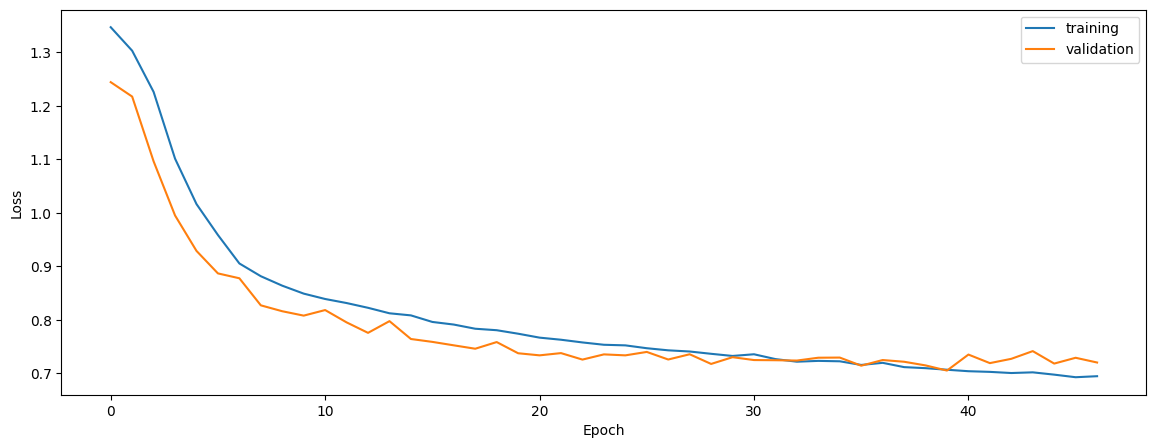

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.7158704083960757
0.7214796686746988
0.7043977138868287


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.7158704083960757
0.7214796686746988
0.7043977138868287


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7144130642619054
0.7154802508526791
0.7016297138525678


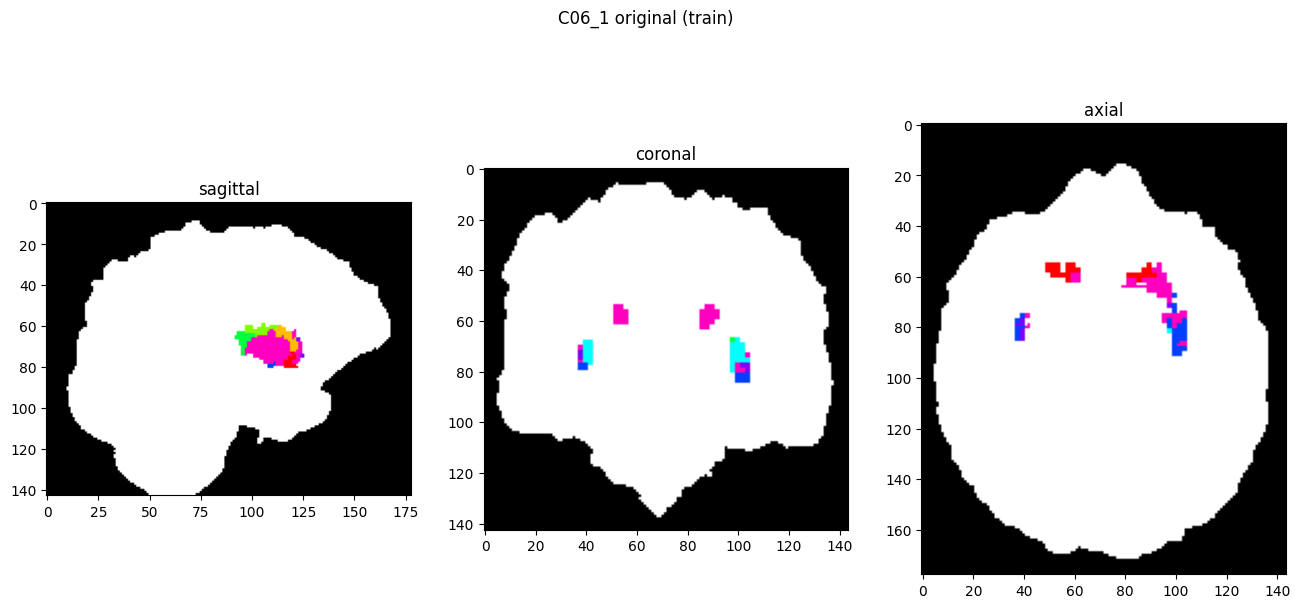

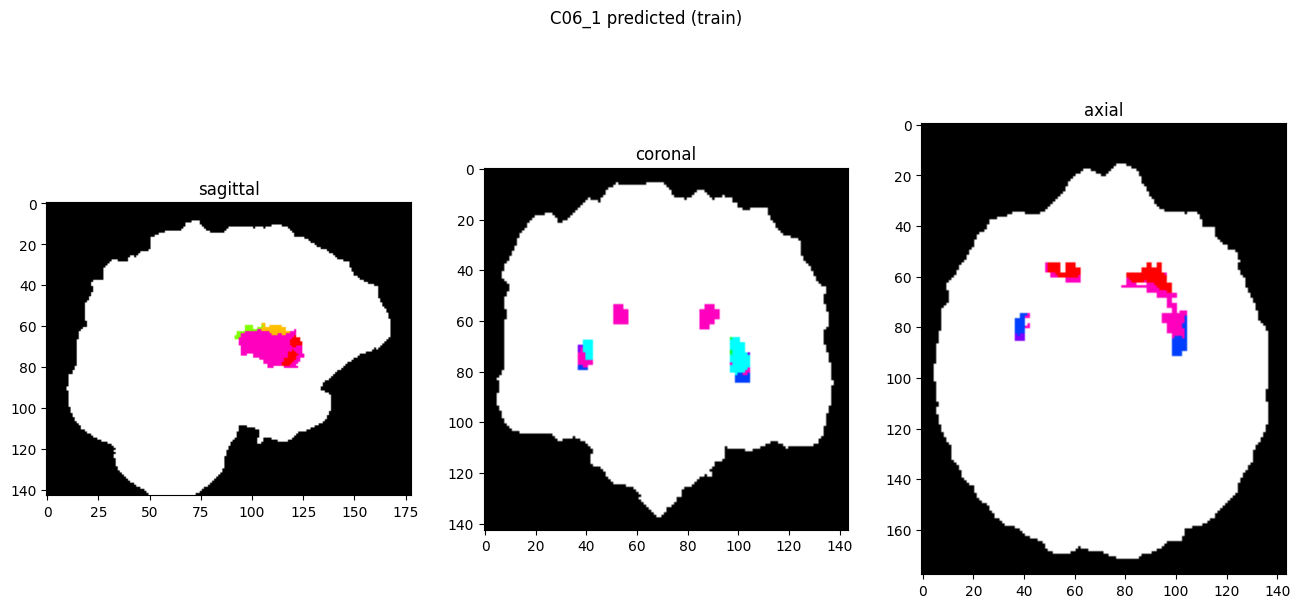

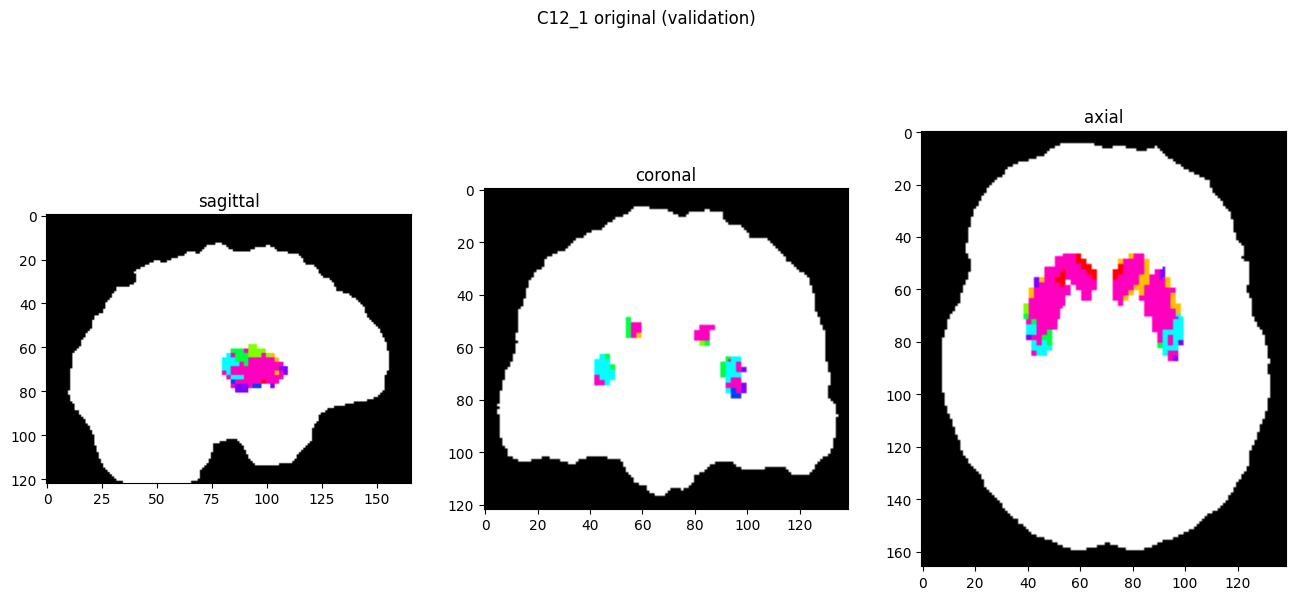

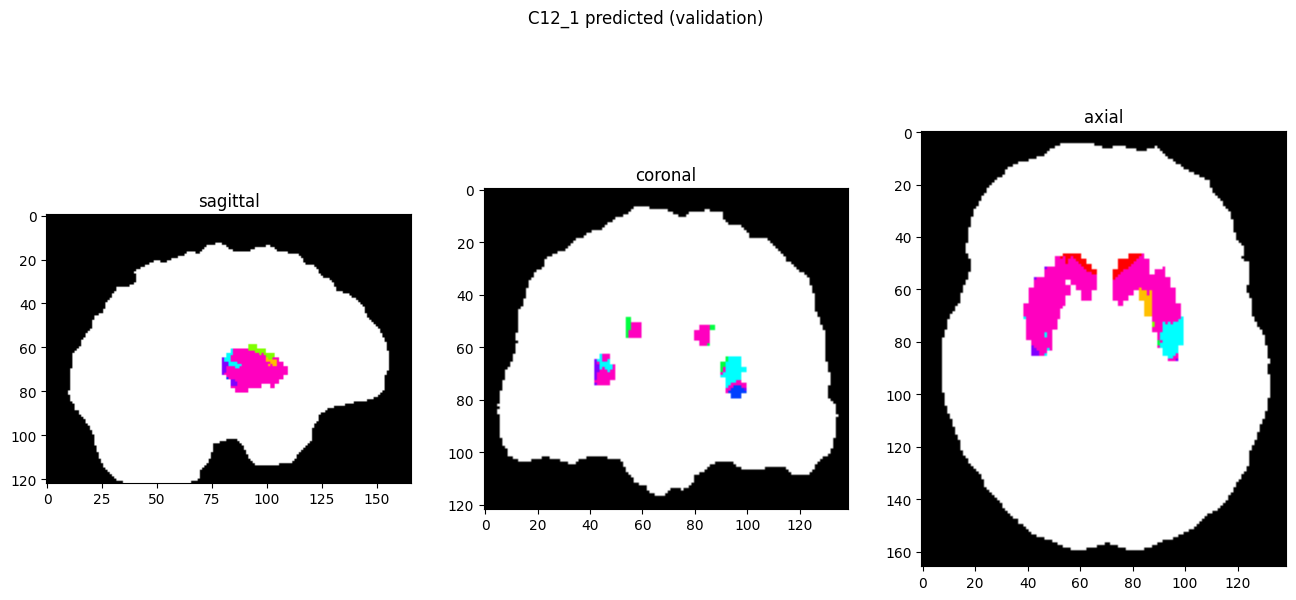

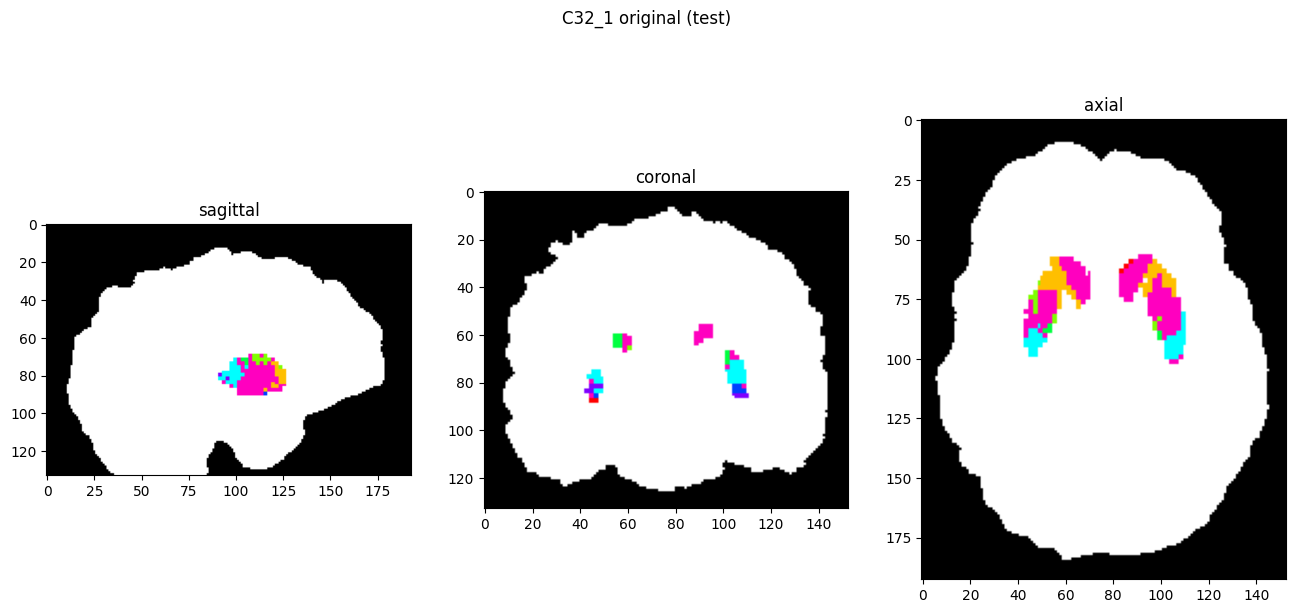

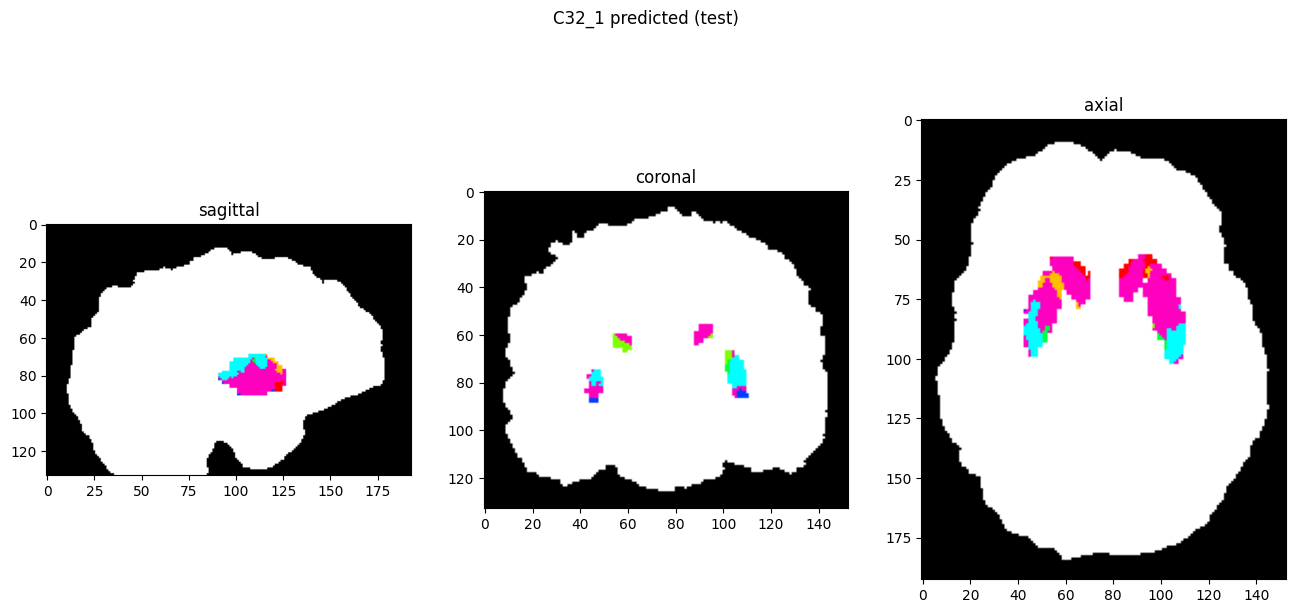

In [10]:
showResults(model, gen, threshold=0)